**Libraries Set up and Data processing**

In [67]:
%pip install vaderSentiment
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import random
import re
import numpy as np
import pandas as pd
import nltk
import spacy
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import Dataset  
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import torch.nn as nn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight



# Initialize NLP tools
nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_sm")
sentiment_analyzer = SentimentIntensityAnalyzer()

ImportError: cannot import name 'get_tags' from 'sklearn.utils' (/Users/pere-ereogunbanjo/Sea_Gold/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py)

In [2]:
# Loading film Scripts
DATASET_PATH = "/Users/pere-ereogunbanjo/Documents/raw_texts"
script_files = os.listdir(DATASET_PATH)

scripts = {}
for file in script_files:
    file_path = os.path.join(DATASET_PATH, file)
    if os.path.isfile(file_path):  # Check if it's a file
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            scripts[file] = f.read()


In [3]:
# Preprocessing the scripts to remove special characters and normalise space
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Creating a DataFrame
df = pd.DataFrame(list(scripts.items()), columns=['filename', 'script'])
df['processed_script'] = df['script'].apply(preprocess_text)


**Sentiment Analysis and Label Assignment**

In [4]:
# Sentiment Analysis Using Vader

df = pd.DataFrame(list(scripts.items()), columns=['filename', 'script'])

# Function to get sentiment scores
def get_sentiment_scores(text):
    return sentiment_analyzer.polarity_scores(text)

# Apply sentiment analysis and assign labels
df['sentiment_scores'] = df['script'].apply(get_sentiment_scores)
df['labels'] = df['sentiment_scores'].apply(lambda x: 1 if x['compound'] > 0.05 else (0 if x['compound'] < -0.05 else None))

# Dropping rows with missing labels
df.dropna(subset=['labels'], inplace=True)
df['labels'] = df['labels'].astype(int)

# Display the DataFrame
print(df)

                                   filename  \
0                     Dark City_1055019.txt   
1        Slay the Dreamer IMDb_11144100.txt   
2     The Deep End of the Ocean_0120646.txt   
3                          Salt_0944835.txt   
4               The Truman Show_0120382.txt   
...                                     ...   
2854          If I Had a Hammer_0210742.txt   
2855             Fortune Cookie_0210688.txt   
2856  Its A Wonderful Lifetime_12551106.txt   
2857               Rocky Balboa_0479143.txt   
2858             Final Analysis_0104265.txt   

                                                 script  \
0     \n\n\n\n\n\n\n\n\n\n\n\n\n                    ...   
1     Leonard Hill Films\n\n4500 Wilshire Blvd.\n\nL...   
2     The Deep End of the Ocean(1996)   \n\nINT. HOU...   
3     SALT\n\nBy\nKurt Wimmer\n\nCurrent revisions b...   
4     ‘\n\nnel RUMAN:....\n\nA Screen Play\nby\nAndr...   
...                                                 ...   
2854  April 18, 1999\n

In [5]:
# Display results
print(df[['filename', 'sentiment_scores', 'labels']].head())

                                filename  \
0                  Dark City_1055019.txt   
1     Slay the Dreamer IMDb_11144100.txt   
2  The Deep End of the Ocean_0120646.txt   
3                       Salt_0944835.txt   
4            The Truman Show_0120382.txt   

                                    sentiment_scores  labels  
0  {'neg': 0.097, 'neu': 0.832, 'pos': 0.071, 'co...       0  
1  {'neg': 0.082, 'neu': 0.815, 'pos': 0.103, 'co...       1  
2  {'neg': 0.065, 'neu': 0.806, 'pos': 0.129, 'co...       1  
3  {'neg': 0.101, 'neu': 0.822, 'pos': 0.077, 'co...       0  
4  {'neg': 0.068, 'neu': 0.854, 'pos': 0.078, 'co...       1  


**Merging Scripts with Metadata**

In [6]:
# Load the Movie Sripts Metadata
metadata_path = "/Users/pere-ereogunbanjo/Documents/movie_meta_data.csv"
metadata_df = pd.read_csv(metadata_path)

In [7]:
# Keeping only relevant columns and Standardizing for merging
metadata_df = metadata_df[['title', 'year', 'genres', 'imdb user rating', 'metascore', 'awards', 'countries']].copy()
df['filename_clean'] = df['filename'].str.replace(r"_\d+\.txt$", "", regex=True).str.lower().str.strip()
metadata_df.loc[:, 'title_clean'] = metadata_df['title'].str.lower().str.strip()

# Merging processed scripts with metadata
merged_df = df.merge(metadata_df, left_on='filename_clean', right_on='title_clean', how='inner')
merged_df.drop(columns=['title_clean'], inplace=True)

In [8]:
print(df.head())

                                filename  \
0                  Dark City_1055019.txt   
1     Slay the Dreamer IMDb_11144100.txt   
2  The Deep End of the Ocean_0120646.txt   
3                       Salt_0944835.txt   
4            The Truman Show_0120382.txt   

                                              script  \
0  \n\n\n\n\n\n\n\n\n\n\n\n\n                    ...   
1  Leonard Hill Films\n\n4500 Wilshire Blvd.\n\nL...   
2  The Deep End of the Ocean(1996)   \n\nINT. HOU...   
3  SALT\n\nBy\nKurt Wimmer\n\nCurrent revisions b...   
4  ‘\n\nnel RUMAN:....\n\nA Screen Play\nby\nAndr...   

                                    sentiment_scores  labels  \
0  {'neg': 0.097, 'neu': 0.832, 'pos': 0.071, 'co...       0   
1  {'neg': 0.082, 'neu': 0.815, 'pos': 0.103, 'co...       1   
2  {'neg': 0.065, 'neu': 0.806, 'pos': 0.129, 'co...       1   
3  {'neg': 0.101, 'neu': 0.822, 'pos': 0.077, 'co...       0   
4  {'neg': 0.068, 'neu': 0.854, 'pos': 0.078, 'co...       1   

             

In [9]:
# Ensuring the 'processed_script' column is present
if 'processed_script' not in merged_df.columns:
    merged_df['processed_script'] = merged_df['script'].apply(preprocess_text)


In [58]:
print(df.info())  # Check data types and missing values
print(df.isnull().sum())  # Count missing values per column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10 non-null     object
 1   label   10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes
None
text     0
label    0
dtype: int64


In [57]:
merged_df.to_csv("final_movie_scripts_dataset.csv", index=False)
print("Final dataset saved as final_movie_scripts_dataset.csv")


Final dataset saved as final_movie_scripts_dataset.csv


In [74]:
print(merged_df.columns)

Index(['filename', 'script', 'sentiment_scores', 'labels', 'filename_clean',
       'title', 'year', 'genres', 'imdb user rating', 'metascore', 'awards',
       'countries', 'processed_script', 'genres_cleaned', 'country_cleaned',
       'decade', 'main_genre', 'Metascore_Category'],
      dtype='object')


In [75]:
print(merged_df.head())

                                filename  \
0                  Dark City_1055019.txt   
1  The Deep End of the Ocean_0120646.txt   
2                       Salt_0944835.txt   
3            The Truman Show_0120382.txt   
4                       1408_0450385.txt   

                                              script  \
0  \n\n\n\n\n\n\n\n\n\n\n\n\n                    ...   
1  The Deep End of the Ocean(1996)   \n\nINT. HOU...   
2  SALT\n\nBy\nKurt Wimmer\n\nCurrent revisions b...   
3  ‘\n\nnel RUMAN:....\n\nA Screen Play\nby\nAndr...   
4  1408\n\nWritten by\nScott Alexander & Larry Ka...   

                                    sentiment_scores  labels  \
0  {'neg': 0.097, 'neu': 0.832, 'pos': 0.071, 'co...       0   
1  {'neg': 0.065, 'neu': 0.806, 'pos': 0.129, 'co...       1   
2  {'neg': 0.101, 'neu': 0.822, 'pos': 0.077, 'co...       0   
3  {'neg': 0.068, 'neu': 0.854, 'pos': 0.078, 'co...       1   
4  {'neg': 0.125, 'neu': 0.787, 'pos': 0.089, 'co...       0   

             

In [10]:
# Manually check sentiment scores for a specific script
script_text = df.loc[0, 'script']
sentiment_scores = sentiment_analyzer.polarity_scores(script_text)
print(sentiment_scores)

{'neg': 0.097, 'neu': 0.832, 'pos': 0.071, 'compound': -1.0}


**Exploratory Data Analysis(EDA)**

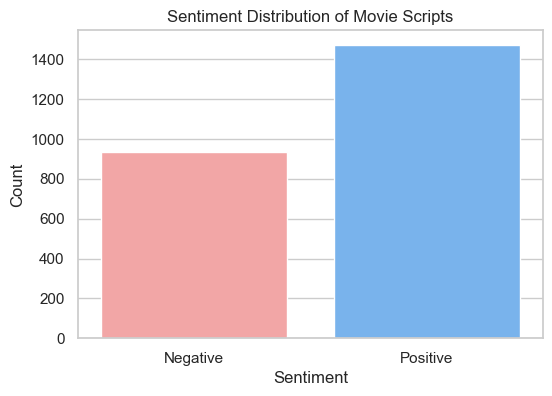

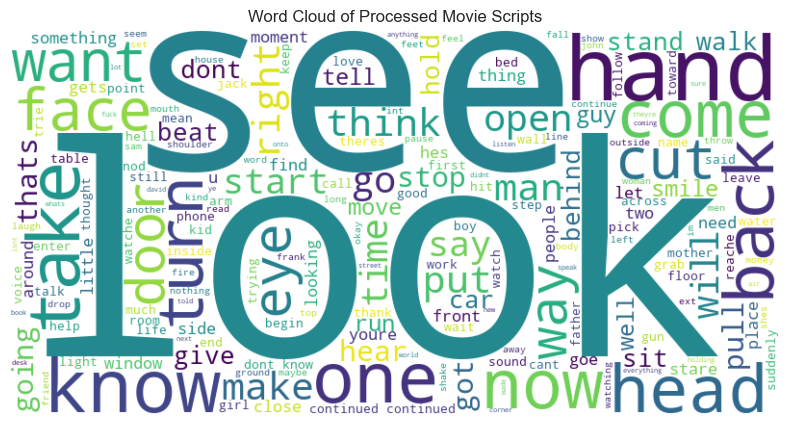

In [26]:
# Exploratory Data Analysis
sns.set(style="whitegrid", palette="pastel")

# Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='labels', data=merged_df, hue='labels', palette=['#ff9999', '#66b3ff'], legend=False)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Sentiment Distribution of Movie Scripts")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(merged_df['processed_script'].tolist()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Processed Movie Scripts")
plt.show()


/var/folders/p3/8zh3t2sd5kn2lm08fdvl01cw0000gn/T/ipykernel_56026/806782640.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


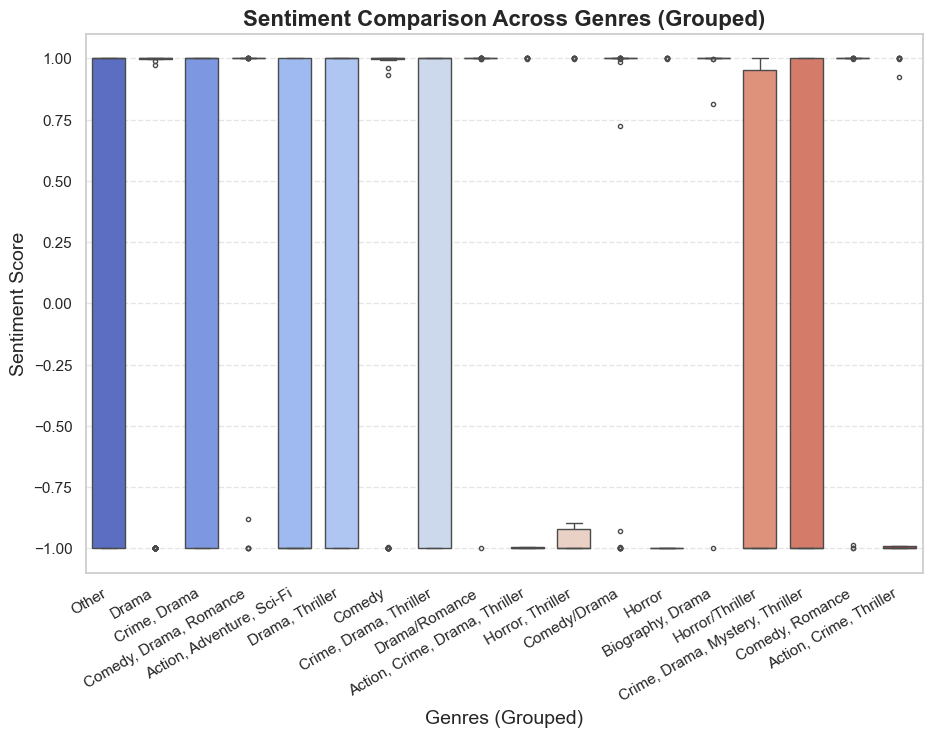

In [27]:

# Getting genre counts
genre_counts = merged_df['genres'].value_counts()

# Grouping rare genres (less than 20 occurrences) into "Other"
merged_df['genres_cleaned'] = merged_df['genres'].apply(lambda x: x if pd.notna(x) and genre_counts[x] > 20 else "Other")

# Manually merging some similar genres to reduce unique categories
genre_mapping = {
    "Action, Adventure": "Action/Adventure",
    "Drama, Romance": "Drama/Romance",
    "Horror, Mystery, Thriller": "Horror/Thriller",
    "Comedy, Drama": "Comedy/Drama",
    "Biography, Drama, History": "Biography/History",
    "Sci-Fi, Fantasy": "Sci-Fi/Fantasy"
}

merged_df['genres_cleaned'] = merged_df['genres_cleaned'].replace(genre_mapping)

# Setting figure size dynamically based on the number of genres
plt.figure(figsize=(min(18, len(merged_df['genres_cleaned'].unique()) * 0.6), 7))

# Creating the boxplot
sns.boxplot(
    x='genres_cleaned',
    y=merged_df['sentiment_scores'].apply(lambda x: x['compound']),
    data=merged_df,
    palette="coolwarm",
    width=0.7,  # Reduce width slightly
    fliersize=3  # Adjust outlier size
)

# Rotate x-axis labels dynamically
plt.xticks(rotation=30, ha="right", fontsize=11)

# Titles and labels
plt.title("Sentiment Comparison Across Genres (Grouped)", fontsize=16, fontweight="bold")
plt.xlabel("Genres (Grouped)", fontsize=14)
plt.ylabel("Sentiment Score", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.show()


/var/folders/p3/8zh3t2sd5kn2lm08fdvl01cw0000gn/T/ipykernel_56026/3473847617.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_countries.values, y=selected_countries.index, palette="coolwarm")


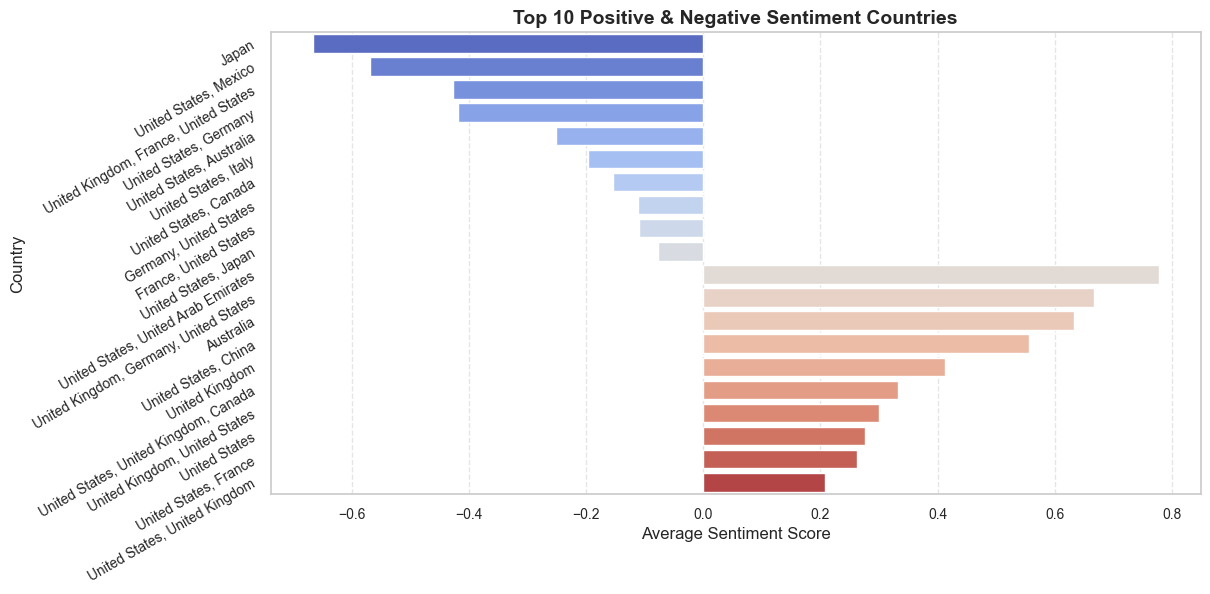

In [28]:


# Computing average sentiment for each country
country_sentiment = merged_df.groupby('countries')['sentiment_scores'].apply(lambda x: np.mean([score['compound'] for score in x]))

# Filtering out countries that appear less than 5 times and handling NaN values
threshold = 5
country_counts = merged_df['countries'].value_counts()
merged_df['country_cleaned'] = merged_df['countries'].apply(lambda x: x if pd.notna(x) and country_counts[x] >= threshold else "Other")

# Recompute sentiment with cleaned country names
country_sentiment = merged_df.groupby("country_cleaned")['sentiment_scores'].apply(lambda x: np.mean([score['compound'] for score in x]))

# Select top 10 most positive and top 10 most negative sentiment countries
top_10 = country_sentiment.nlargest(10)  # Highest sentiment
bottom_10 = country_sentiment.nsmallest(10)  # Lowest sentiment

# Combine both sets
selected_countries = pd.concat([bottom_10, top_10])

# Plot the improved visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=selected_countries.values, y=selected_countries.index, palette="coolwarm")

plt.title("Top 10 Positive & Negative Sentiment Countries", fontsize=14, fontweight='bold')
plt.xlabel("Average Sentiment Score", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(rotation=30, fontsize=10)  # Rotate labels for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()


Pearson Correlation: 0.02 (p-value: 0.3179)


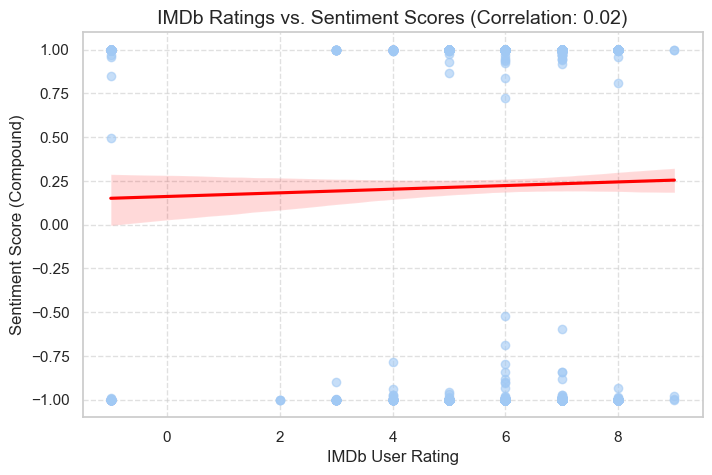

In [29]:


# Converting IMDb ratings to numeric
merged_df['imdb user rating'] = pd.to_numeric(merged_df['imdb user rating'], errors='coerce')

# Droping NaN values for proper analysis
filtered_df = merged_df.dropna(subset=['imdb user rating', 'sentiment_scores'])

# Extract compound sentiment scores
filtered_df['sentiment_compound'] = filtered_df['sentiment_scores'].apply(lambda x: x['compound'])

# Compute Pearson correlation
correlation, p_value = stats.pearsonr(filtered_df['imdb user rating'], filtered_df['sentiment_compound'])

# Scatter Plot with Regression Line
plt.figure(figsize=(8, 5))
sns.regplot(x='imdb user rating', y='sentiment_compound', data=filtered_df, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title(f"IMDb Ratings vs. Sentiment Scores (Correlation: {correlation:.2f})", fontsize=14)
plt.xlabel("IMDb User Rating", fontsize=12)
plt.ylabel("Sentiment Score (Compound)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Display the correlation coefficient
print(f"Pearson Correlation: {correlation:.2f} (p-value: {p_value:.4f})")

plt.show()


Sentiment by Decade:
decade
-10      0.200080
 1910    0.333267
 1920   -0.142593
 1930    0.805952
 1940    0.828460
 1950    0.555852
 1960    0.302533
 1970    0.252262
 1980    0.170890
 1990    0.085930
 2000    0.154605
 2010    0.317946
 2020   -0.036496
Name: sentiment_scores, dtype: float64


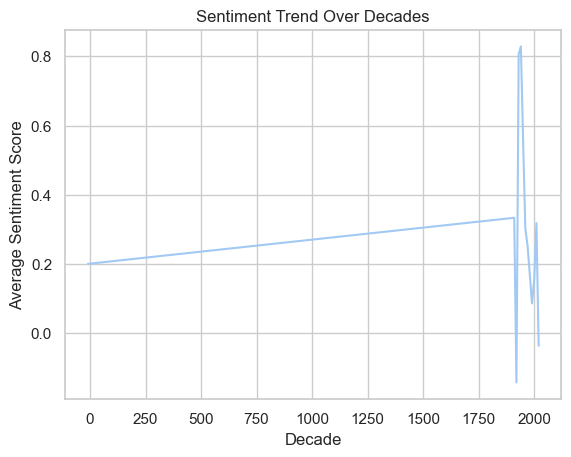

In [30]:
# Group by decade
merged_df['decade'] = (merged_df['year'] // 10) * 10
decade_sentiment = merged_df.groupby('decade')['sentiment_scores'].apply(lambda x: np.mean([score['compound'] for score in x]))

# Display decade-wise sentiment trend
print("Sentiment by Decade:")
print(decade_sentiment)

# Plotting sentiment trend over decades
sns.lineplot(x=decade_sentiment.index, y=decade_sentiment.values)
plt.title("Sentiment Trend Over Decades")
plt.xlabel("Decade")
plt.ylabel("Average Sentiment Score")
plt.show()


Top 5 Positive Genres:
main_genre
Game-Show    1.00000
Western      1.00000
History      1.00000
Film-Noir    0.99995
Musical      0.99970
Name: sentiment_scores, dtype: float64

Top 5 Negative Genres:
main_genre
News      -0.999700
Horror    -0.541392
Fantasy   -0.499780
Action    -0.313456
Crime      0.093356
Name: sentiment_scores, dtype: float64


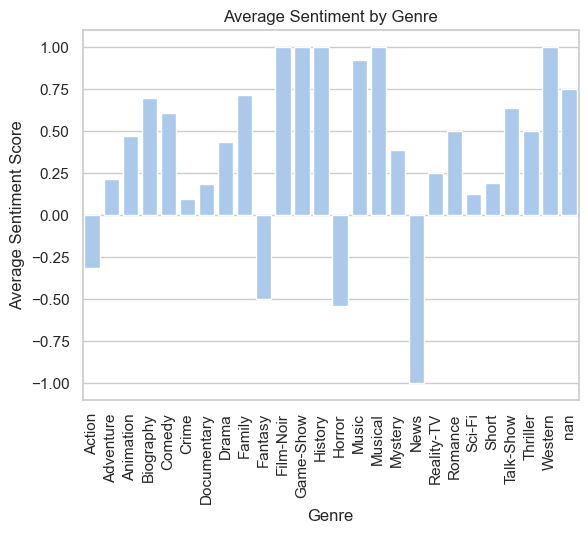

In [31]:
# Calculating the average compound sentiment scores for each genre
merged_df['main_genre'] = merged_df['genres'].astype(str).apply(lambda x: x.split(',')[0] if ',' in x else x)
genre_sentiment = merged_df.groupby('main_genre')['sentiment_scores'].apply(lambda x: np.mean([score['compound'] for score in x]))

# Sortting and displaying top genres with the most positive and negative sentiments
print("Top 5 Positive Genres:")
print(genre_sentiment.sort_values(ascending=False).head(5))

print("\nTop 5 Negative Genres:")
print(genre_sentiment.sort_values().head(5))

# Plotting genre sentiment
sns.barplot(x=genre_sentiment.index, y=genre_sentiment.values)
plt.xticks(rotation=90)
plt.title("Average Sentiment by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Sentiment Score")
plt.show()

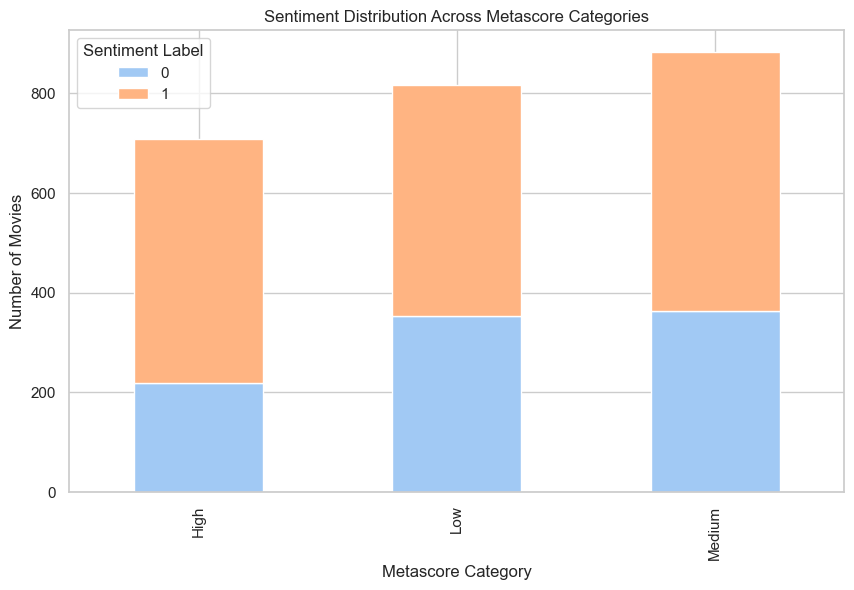

In [32]:
# Sentiment Distribution Across Metascore Categories
def categorize_metascore(score):
    if score >= 70:
        return 'High'
    elif score >= 40:
        return 'Medium'
    else:
        return 'Low'

merged_df['Metascore_Category'] = merged_df['metascore'].apply(categorize_metascore)
sentiment_metascore = merged_df.groupby(['Metascore_Category', 'labels']).size().unstack()
sentiment_metascore.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Distribution Across Metascore Categories")
plt.xlabel("Metascore Category")
plt.ylabel("Number of Movies")
plt.legend(title="Sentiment Label")
plt.show()

**Training the Model/Emotion Detection with Bert**

In [33]:


# Checking GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loading Tokenizer
tokenizer = BertTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")

texts = ["I can still enjoy the smell of it", "It's too hot in here for any man who still has blood in his veins.", "Just having fun trying to guess what they are.."]
labels = [1, 0, 1]  # Example sentiment labels (1=Positive, 0=Negative)

# Converting to Hugging Face Dataset 
dataset = Dataset.from_dict({"text": texts, "labels": labels})

# Tokenization function
def tokenize_function(examples):
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    tokens["labels"] = examples["labels"]  
    return tokens

# Applying tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Train-Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
best_hyperparams = {'lr': 2e-5, 'batch_size': 16}

# Ensuring collate_fn handles labels properly in dataLoader
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]).to(device)
    attention_mask = torch.stack([torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]).to(device)
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long).to(device)  
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], collate_fn=collate_fn)

# Loading Pretrained BERT Model
num_labels = 6  # Emotion classification (anger, fear, joy, sadness, surprise, neutral)
model = BertForSequenceClassification.from_pretrained(
    "bhadresh-savani/bert-base-uncased-emotion",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
).to(device)

# Define Optimizer & Loss Function
optimizer = AdamW(model.parameters(), lr=best_hyperparams['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

# Training Loop
num_epochs = 6
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Moving batch to device and moving labels to device
        inputs = {key: batch[key].to(device) for key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)  

        # Forward pass
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f" Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print(" Training Complete")

# Save fine-tuned model
model.save_pretrained("fine_tuned_bert_film_sentiment_model")
tokenizer.save_pretrained("fine_tuned_bert_film_sentiment_model")

# Emotion Detection Function
def emotion_analysis(text):
    emotions = ["anger", "fear", "joy", "sadness", "surprise", "neutral"]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    emotion_index = torch.argmax(probabilities, dim=-1).item()
    return emotions[emotion_index]

# Testing Emotion Detection
sample_text = """
So you're a private detective.
I didn't know they existed except
in books, or else they were little
greedy men snooping around hotels.
My, you're a mess, aren't you?
"""
predicted_emotion = emotion_analysis(sample_text)
print(f" Predicted Emotion: {predicted_emotion}")

# Handling Full Movie Scripts
texts = merged_df['processed_script'].tolist()
labels = merged_df['labels'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Creating Final DataLoader
train_loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
print("DataLoader setup complete.")


Using device: cpu


/Users/pere-ereogunbanjo/Sea_Gold/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 3/3 [00:00<00:00, 993.68 examples/s]


 Epoch 1, Loss: 3.4833
 Epoch 2, Loss: 1.9434
 Epoch 3, Loss: 0.8722
 Epoch 4, Loss: 0.1562
 Epoch 5, Loss: 0.1023
 Epoch 6, Loss: 0.0666
 Training Complete
 Predicted Emotion: sadness
DataLoader setup complete.


Testing on a Training Script

In [34]:

# Loading Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")
model = BertForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion").to(device)

def split_script_by_scenes(script_text):
    """Splits a movie script into scenes using common screenplay markers."""
    scene_markers = ["FADE IN:", "FADE OUT:", "INT.", "EXT.", "CUT TO:", "DISSOLVE TO:", "SMASH CUT TO:"]
    scenes = []
    current_scene = []

    lines = script_text.split("\n")
    for line in lines:
        if any(marker in line for marker in scene_markers):
            if current_scene:
                scenes.append("\n".join(current_scene))
                current_scene = []
        current_scene.append(line)

    if current_scene:
        scenes.append("\n".join(current_scene))

    return scenes

def analyze_script_emotions(script_text):
    """Performs emotion analysis on each scene and aggregates results."""
    scenes = split_script_by_scenes(script_text)
    emotions = ["anger", "fear", "joy", "sadness", "surprise", "neutral"]

    # Store cumulative emotion scores
    emotion_scores = torch.zeros(len(emotions)).to(device)

    scene_results = []

    for i, scene in enumerate(scenes):
        # Tokenize the scene
        inputs = tokenizer(scene, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Convert logits to probabilities
        probabilities = F.softmax(outputs.logits, dim=-1).squeeze()

        # Add to cumulative emotion scores
        emotion_scores += probabilities

        # Store scene-wise results
        dominant_emotion_index = torch.argmax(probabilities).item()
        dominant_emotion = emotions[dominant_emotion_index]
        scene_results.append(f"Scene {i+1}: {dominant_emotion}")

    # Normalize emotion scores across all scenes
    emotion_scores /= len(scenes)

    # Find overall dominant emotion for the entire script
    overall_emotion_index = torch.argmax(emotion_scores).item()
    overall_emotion = emotions[overall_emotion_index]

    # Convert scores to readable format
    emotion_distribution = {emotions[i]: round(emotion_scores[i].item(), 4) for i in range(len(emotions))}

    return overall_emotion, emotion_distribution, scene_results

#  Inserted Full Movie Script Here:
script_text = """

     FADE IN:

     Through the window of a moving vehicle, we see a series of
     small, middle-class houses.  This could be any suburban street
     in America.


     INT. CITY BUS - DAY

     A boy is seated near the back of a moving bus.  This is TODD
     BOWDEN, 15, as All-American as they come.  He stares out at the
     other passengers indifferently.  Then something catches his eye.


     EXT. RESIDENTIAL STREET - SANTO DONATO - DAY

     TITLE: SANTO DONATO, CA  FEBRUARY 1984

     Todd pedals his bike down a quiet street and pulls up to an
     unassuming bungalow set far back on its lot.  This is the kind
     of house one would hardly notice driving through the peaceful
     suburban community of Santo Donato.  Todd gets off his bike and
     heads up the front steps.  On the way, he bends down to pick up
     the L.A. Times.

     Two signs, in laminated plastic, are secured neatly above the
     door bell.  The first reads: "ARTHUR DENKER".  The second reads:
     "NO SOLICITORS, NO PEDDLERS, NO SALESMEN".

     Todd RINGS the bell.  Nothing.  He looks at his watch.  It is
     twelve past ten.  He RINGS again, this time longer.  Still
     nothing.  Finally, Todd leans on the tiny button, staring at his
     watch as he does so.  After more than a minute of SOLID RINGING,
     a voice is heard from within.

                          DUSSANDER (O.S.)
             All right.  All right.  I'm coming.  Let it
             go!

     Todd lets go as a chain behind the heavy door starts to rattle.
     Then it opens.  An old man stands behind the screen.  He is KURT
     DUSSANDER, a.k.a. Arthur Denker.  Mid-seventies.  Standing there
     in his bathrobe and slippers, a cigarette smashed in his mouth,
     he looks like a cross between Boris Karloff and Albert Einstein.
     Dussander stares at Todd, who tries to speak, but suddenly
     cannot.

                          DUSSANDER
                    (continuing)
             A boy.  I don't need anything, boy.  Can't
             you read?  I thought all American boys could
             read.  Don't be a nuisance, now.  Good day.

     The door begins to close.  Todd waits till the last moment
     before speaking.

                          TODD
             Don't forget your paper, Mr. Dussander.

     The door stops.  Dussander opens it slowly.  He unlatches the
     screen and slips his fingers around the paper.  Todd does not
     let go.

                          DUSSANDER
             Give me my newspaper.

                          TODD
             Sure thing, Mr. Dussander.

     Dussander snatches the paper away and closes the screen door.
     Quickly, almost imperceptibly, the old man's eyes survey the
     area: across the street, up and down the sidewalk, the boy's
     bicycle.

                          DUSSANDER
             My name is Denker.  See?
                    (pointing)
             Denker.  Perhaps you cannot read after all.
             What a pity.  Good day.

     As the front door closes, Todd speaks rapidly into the narrowing gap.

                          TODD
             Bergen-Belsen, January '43 to June '43.
             Auschwitz, June '43 to June '44.  Then you
             went to Patin.

     The door stops, still partly open.

                          TODD (CONT'D)
             After the war, you escaped to Buenos Aires.
             From 1950 to '52 you were in Cuba, and
             then... From 1952 to '58... I don't know.  No
             one does.  But in 1965, you popped up in West
             Berlin, where they almost got you.

     The door opens wider.

                          DUSSANDER
             Listen, boy.  I don't know what is the matter
             with you.  But I don't have time for this
             game.  Now, get out of here before I call the
             police.

                          TODD
             Call them if you want.

                          DUSSANDER
             Fine.

     The heavy door slams shut.

                          TODD
             It's okay by me Herr Kommandant.  I'm sure
             the police would love to meet the "Blood-
             fiend of Patin."

     In a flash the front door is open, so is the screen.  Dussander
     is through the doorway and descending upon Todd with the rolled
     umbrella raised to strike him.  Todd stumbles back against the
     porch rail.

                          DUSSANDER
             You get away from this house, God damn you!
             I'll beat you all the way home.

     But Todd regains his composure quickly.  He brushes himself off
     and levels his eyes at the old man who now hardly seems the
     threat he was a few seconds ago.

                          TODD
             After 1965, no one saw you again... Until I
             did.  Three weeks ago on the downtown bus. If
             you want to call the cops, go right ahead.
             I'II wait on the steps.

                          DUSSANDER
             You'll do no such thing.

                          TODD
             I won't?  Listen, old man, if I want to start
             screaming right here, I will.  If I want to
             ride down to the police station and bring the
             cops back myself, then I will.  I will do
             what ever I want.  Do you understand?
                    (pause)
             But if you like, I could come in for a
             minute.  We could talk.

     Pause.

                          DUSSANDER
             I'd be out of my mind to let an insane boy
             like you into my home.

     Pause.

                          DUSSANDER (CONT'D)
             Is that what you want, to come into my home?
             So be it.  There is no arguing with crazy
             people.

     Dussander turns and steps back through the screen door.  He
     stops at the threshold of the house and turns.  He is holding
     the screen door open with one leg, the front door open with the
     other.  He looks straight ahead.  A moment later, Todd steps
     into the house.


     INT. DUSSANDER'S HOUSE - DAY

     Dussander's home is what you would expect of a single, poor, old
     man.  Nothing fancy, nothing out of the ordinary.  Todd looks
     around, perhaps half-expecting to find a Nazi flag or an oil
     painting of Der Fuehrer hanging above the mantle.  But he
     doesn't, and moves into the living room where an old picture of
     a woman sits framed on an end table.

                          DUSSANDER
             My wife.  She died in 1955 of lung disease.
             At that time I was working at the Menschler
             Motor Works in Essen.  I was heartbroken.

     Todd's attention drifts away and his fingers slip over to a
     lampshade next to the photograph.  He begins to feel it as
     though he were inspecting it for something.

                          DUSSANDER (CONT'D)
             Stop that!

     Todd jumps back a little but then recovers.

                          TODD
             Tell me, wasn't it Ilse Koch who made the
             lampshades out of human skin?

                          DUSSANDER
             Now I don't know what you're talking about.

                          TODD
             Sure you do, Mr. Dussander.

                          DUSSANDER
             Denker.  Denker.  Denker.  You don't listen,
             boy.  The television has fried your brain.

     Pause.

                          TODD
             Your hands are shaking.

                          DUSSANDER
             Yes, they're shaking.  I'm old.  We all
             shake.  You are most tiresome, and rude.  Now
             if you have a point I wish you'd come to it.

                          TODD
             We're in no rush.  If I thought you had
             plans, I'd say cancel them, but since I know
             you don't...

                          DUSSANDER
             You know nothing of my business --

                          TODD
             What business?  You sit in that ugly chair
             and watch soap operas all day.  Except on
             Friday afternoons when you walk down to the
             movie theater.  And twice a week you take the
             bus downtown to do your shopping.  You always
             use the express lane because you never have
             more than ten items.

                          DUSSANDER
             You have been following me?

                          TODD
             Of course, I followed you.  You think I
             normally go around to peoples' houses and
             accuse them of being Nazi fugitives?

                          DUSSANDER
             Perhaps for me you made an exception.

                          TODD
             No, for you I had to be sure.  For Kurt
             Dussander I had to be absolutely certain.
             ...Now, I am, and that's why I'm here.

     Todd sits on the sofa.

                          DUSSANDER
             Oh, yes, I see now.  As I am this ex-Nazi
             fellow, as you say, then this must be the
             part where I offer you my hidden stash of
             gold, taken from the mouths of old Jewish
             men, of course, which I keep buried in the
             basement.  Isn't that right, boy?  Well, I'm
             afraid you're wasting your time. I have no
             money.  If I did I might even give you some
             just to be done with this nonsense.

                          TODD
             I don't need money.  You don't have any
             anyway.  At least, I don't think so.  You
             probably had to spend it all to sneak in the
             country.  A good American passport is
             expensive on the black market, that I know.

                          DUSSANDER
             Do you?  Good for you.

                          TODD
             Yes, I do.  I know it all, Dussander.  You're
             my One Great Interest.

                          DUSSANDER
             Your what?

                          TODD
             My One Great Interest.  Well, not you
             personally, but, ...well, it's something I
             learned back in eighth grade.  Our teacher,
             Miss Harmon, she said we'd have to find our
             One Great Interest in life.  You know, the
             thing that would really grab us.  Once we did
             that, everything would fall into place.  Like
             hers, she said, wasn't teaching, but
             collecting nineteenth-century postcards.  I
             guess there's no money in that, so she has to
             be a teacher.  Anyway, she told us to start
             thinking about it.  So I did, but nothing
             happened.  Until the following summer, in
             Ronny Pegler's garage.  That's where I found
             it.


     INT. RONNY PEGLER'S GARAGE - DAY

     Todd and RONNY, both 13, rummage through several large boxes in
     the corner of the garage.  We see that the boxes are filled with
     old war magazines.  Ronny tosses several of them to the ground
     as he digs for his dad's old copies of Penthouse.  Ronny selects
     one Penthouse and rifles through it.  He discards it a moment
     later.

                          RONNY
             One of these has three girls doing it <i>at the
             same time</i>.

     But the old war magazines catch Todd's attention.  He picks one
     up curiously and carefully flips through the tattered pages.  We
     see a few of the photographs:  Nazi storm troopers, prisoners
     behind barbed wire, the ovens.

                          RONNY (CONT'D)
             I got it!  Check this out. ...Todd, look.

                          TODD
             Hang on a sec.

     As young Todd stares into this secret world, his voice comes
     in...

                          TODD (CONT'D)
             It was all there... pictures of stuff I'd
             never seen, stuff they <i>never</i> put in the books
             anymore, especially the ones they give us to
             read.  And here were <i>stacks</i> of them.


     INT. DUSSANDER'S LIVING ROOM - DAY

     Todd speaks excitedly.  Dussander, very bored, clearly indulges
     him.

                          TODD
             It... <i>grabbed</i> me.  It was just like Miss
             Harmon said.  I couldn't believe it.  But
             there it was, the camps, the uniforms, the
             ...the way they saluted each other.  But what
             am I telling you for?  You know more about
             this stuff than anybody.

                          DUSSANDER
             Yes, what are you telling me for?

                          TODD
                    (ignoring him)
             Then last year I wrote my big term paper on
             Dachau.  I got an A+.  It was the only A+ she
             gave.  I mean I always do real well.  A's on
             everything.  That's why I'm accelerated.

                          DUSSANDER
             Accelerated?

                          TODD
             You know, accelerated.  I skipped two grades,
             second and ninth.  I didn't need them.
             That's why I'm already a junior.

     Dussander sits.

                          DUSSANDER
             I see...

                          TODD
             Some kids resent me for it.  That's not
             important.  Anyway, my paper really floored
             my history teacher.  I guess because I got
             through all those books without throwing up.
             But I learned something.  I learned that when
             you talk about the camps now, you have to
             remember to sound really disgusted.  I mean,
             you can't just say what happened like the
             magazines did and leave it at that.  If I
             tried that the teacher would have freaked and
             called my parents in.


     INT. RONNY PEGLER'S GARAGE - DUSK

     Todd sits on one of the boxes surrounded by dozens of the old
     magazines.  The door to the house opens and Ronny, looking
     cross, pokes his head out.

                          RONNY
             Todd, your mom's on the phone.  She says you
             have to come home for dinner.  ...Todd?

     Todd, lost in the sea of old photographs, doesn't notice Ronny
     at first.  Then he looks up at him.  In his eyes is a glint of a
     darkness that we will come to know better.

                          TODD
             What?

                          RONNY
                    (suddenly wary of Todd)
             Your mom's on the phone.

     ANGLE on Todd.


     INT. DUSSANDER'S LIVING ROOM - DAY

                          TODD
             Nowadays you have to... soften it.

                          DUSSANDER
             Why do I care about this?

                          TODD
             Because, I don't want it softened.

     Todd hops up and begins to pace the floor. Dussander stares at
     him blankly, unsure of where this is going.

                          DUSSANDER
             I am sure you trouble your parents to no end.

                          TODD
             Actually, I'm pretty low maintenance.  That's
             what my dad says.

                          DUSSANDER
             You told your parents about me, then?

                          TODD
             You think I'm crazy?

                          DUSSANDER
             I think you're crackers, but go on.  I'm
             riveted.

     Todd looks deep into Dussander's eyes.  Dussander is
     uncomfortable.  Slowly, Todd reaches out and brushes his finger
     against Dussander's hand.  Dussander gets up.

                          DUSSANDER (CONT'D)
             What are you doing?

     Pause.

                          TODD
             And then it happened... I was on my way to
             the library.  It was raining...


     FLASHBACK: INT. CITY BUS - DAY

     Todd's voice narrates what we are seeing.  Todd, seated near the
     back of the bus, watches Dussander climb aboard.  Todd thinks
     nothing of it at first, but soon finds that he is unable to take
     his eyes off him.  Todd is trying to place the old man's face in
     his mind...

                          TODD (V.O.)
             You climbed on the bus and started this slow
             walk down the aisle.  Just like you were
             examining a new batch of inmates.  I don't
             think anybody gave you a second glance but
             me, but somehow ...people seemed to move out
             of your way.  And under your arm you carried
             a rolled up umbrella.  But what really did
             it, what really set me off was the coat.  You
             were wearing this long black rain coat.  My
             mind suddenly flipped back to a picture of
             you taken at Patin.  You in your S.S.
             greatcoat with a riding crop under your arm.


     INT. DUSSANDER'S LIVING ROOM - DAY

                          TODD
             It was incredible.

     Dussander stares back at him flatly.

                          DUSSANDER
             All of this... because of a rain coat?

                          TODD
             Well, it wasn't <i>that</i> easy.  I mean, I had to
             really check up on it.  And every picture of
             you in those books is forty years old, at
             least.  I went back to the library to find
             the picture.  And then I matched it with the
             photos I took.

                          DUSSANDER
             You took photographs of me?

                          TODD
             Yeah, I got this little camera.  Fits right
             in the palm of my hand.

                          DUSSANDER
                    (crunches cigarette into ashtray)
             Clever boy.

                          TODD
             But even then I couldn't be sure.  I needed
             real proof.  So I went to the mall and bought
             a fingerprint kit from the hobby shop and a
             book that tells you what you're supposed to
             look for and then dusted your mailbox while
             you were at the movies.  Pretty smart, huh?

                          DUSSANDER
             You... put dust on my mailbox?  For
             fingerprints?  You took photographs of me?
             What else did you do?... I don't believe any
             of this.

                          TODD
             I already had a copy of your fingerprints.
             They're on your want sheet from the Israeli
             government.  It's on database at UC Irvine.
             Can you believe that?

                          DUSSANDER
             Bourbon.

     He storms toward the kitchen and stops.

                          DUSSANDER (CONT'D)
             Would you care for a drink, boy?

                          TODD
             Sure, you got a Coke?

                          DUSSANDER
             No <i>Kok</i>.

                          TODD
             Milk?

                          DUSSANDER
             Milk.

     Dussander disappears into the kitchen.  Todd stands alone in the
     living room.

     He lets out a long, nervous breath, showing for the first time
     the presence of something other than the cold confidence he has
     been putting up for Dussander.  He knows he has crossed into
     dangerous territory from which there is no going back.  But
     after a moment he composes himself; he has come this far.  The
     sternness returns to his eyes.  Todd is all business.  He takes
     a breath, and then speaks loudly enough for Dussander to hear
     him in the kitchen.

                          TODD
             It takes eight good matches, they're called
             compares, actually, for a fingerprint to get
             accepted in court.

                          DUSSANDER (O.S.)
             Is that right?


     FLASHBACK: EXT. DUSSANDER'S FRONT PORCH - DAY

     Todd steps up onto the porch and looks around calmly.  He pulls
     the powder and brush from his pocket and begins to examine the
     mailbox for prints.

                          TODD (V.O.)
             Yeah, there were two sets of prints.  The
             first I figured were the mailman's.  Once I
             knew what I was looking for, yours were easy
             to spot.


     INT. DUSSANDER'S LIVING ROOM - DAY

                          DUSSANDER (O.S.)
             You should be a detective.

     The SOUNDS of a refrigerator opening and closing come from the
     kitchen.  Drinks being poured.  Todd begins to move slowly
     toward the kitchen.

                          TODD
             Maybe I will... Mom thinks I'd be good at it.


     INT. DUSSANDER'S KITCHEN - DAY

     He reaches the doorway just as Dussander turns around with the drinks.

                          TODD
             I found fourteen compares.

     Dussander approaches him carrying a tumbler of milk and a glass
     of bourbon.  He hands the tumbler to Todd, who brings it up to
     his lips and hesitates.

                          TODD (CONT'D)
             You have some.

                          DUSSANDER
             Good <i>Gott</i>.

     He snatches the cup and swallows twice.

                          DUSSANDER (CONT'D)
             You see?  It's milk, boy.  From Dairylee
             Farms.  On the carton is a picture of a
             smiling cow.

     Todd pauses and then begins to drink.

                          DUSSANDER (CONT'D)
                    (more to himself than Todd)
             ...And two missing children.
                    (pause)
             Boy what you have done, I have to explain
             this to you because clearly you don't
             understand, what you have done is a
             violation.

                          TODD
             A violation?

                          DUSSANDER
             Yes.

                          TODD
             Kind of like those experiments with the
             decompression chamber.  Now, that was a
             violation, Dussander.

                          DUSSANDER
             That fucking name.  Enough of that.  I demand
             it.

                          TODD
             You what?

                          DUSSANDER
             I demand --

                          TODD
             You demand nothing from me.  Ever.  Get it?

     Pause.

                          DUSSANDER
             Boy, I will tell you this once more, and for
             the last time.  My name is Arthur Denker.  It
             has never been anything else.  It has never
             even been Americanized.  If you must know,
             and apparently you must, I was named by my
             father who greatly admired the stories of
             Arthur Conan Doyle.  I did serve in the
             reserves, I admit, and in the late thirties,
             when I was first married, I supported Hitler.
             I supported him most, I suppose, because for
             the first time in years there was work and
             there was tobacco. ...Would you like a
             cigarette?

                          TODD
             No.  My dad used to smoke.  Mom made him
             quit.  Now he's addicted to Nicorette...
             that's nicotine gum.

     Dussander turns toward the counter and pulls a kitchen match
     from a cabinet.  He lights his cigarette with his back to Todd.

                          DUSSANDER
             Nicotine gum.

     Dussander's eyes drift to the collection of kitchen knives
     neatly stuffed in their block on the counter in front of him.
     He lingers a moment, pulls deeply on the cigarette, then turns
     and continues.

                          DUSSANDER (CONT'D)
             Anyway, Hitler lost his mind at the end,
             directing phantom armies at the whim of his
             astrologer.  He even gave his dog, Blondi, a
             death capsule.  On May 2nd, 1945, my regiment
             surrendered to the Americans.  I remember
             that a private named Gonzales gave me a
             chocolate bar.  I wept.

     Bored, Todd sinks into a chair at the table.

                          DUSSANDER (CONT'D)
             I was interned at Essen where I was treated
             very well.  We listened to the Nuremberg
             trials on the radio and when Goering
             committed suicide, I bought half a bottle of
             schnaps and got drunk.  When I was released,
             I put wheels on cars at the Essen Motor Works
             until I retired in 1963.  In 1967 I emigrated
             here, to California, and became a U.S.
             Citizen.  I am as American as you are.  I
             vote.  No Buenos Aires, no Berlin, no <i>koo-ba</i>
"""

# Run Emotion Analysis on Full Script
overall_emotion, emotion_distribution, scene_results = analyze_script_emotions(script_text)

print(f"\n **Overall Movie Emotion:** {overall_emotion}")
print(f" **Emotion Score Breakdown:** {emotion_distribution}")
print("\n**Scene-wise Emotion Analysis:**")
for result in scene_results:
    print(result)



 **Overall Movie Emotion:** surprise
 **Emotion Score Breakdown:** {'anger': 0.0851, 'fear': 0.2556, 'joy': 0.0298, 'sadness': 0.2012, 'surprise': 0.4094, 'neutral': 0.0189}

**Scene-wise Emotion Analysis:**
Scene 1: sadness
Scene 2: surprise
Scene 3: surprise
Scene 4: fear
Scene 5: surprise
Scene 6: anger
Scene 7: sadness
Scene 8: surprise
Scene 9: surprise
Scene 10: surprise
Scene 11: sadness
Scene 12: fear
Scene 13: fear
Scene 14: fear


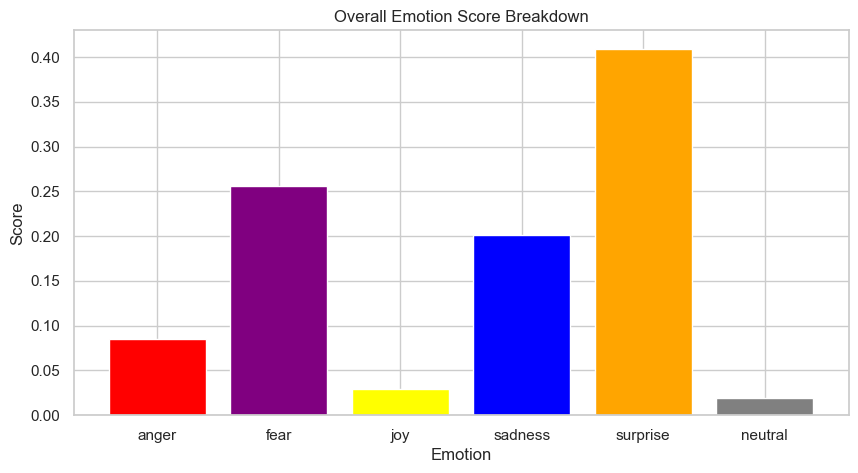

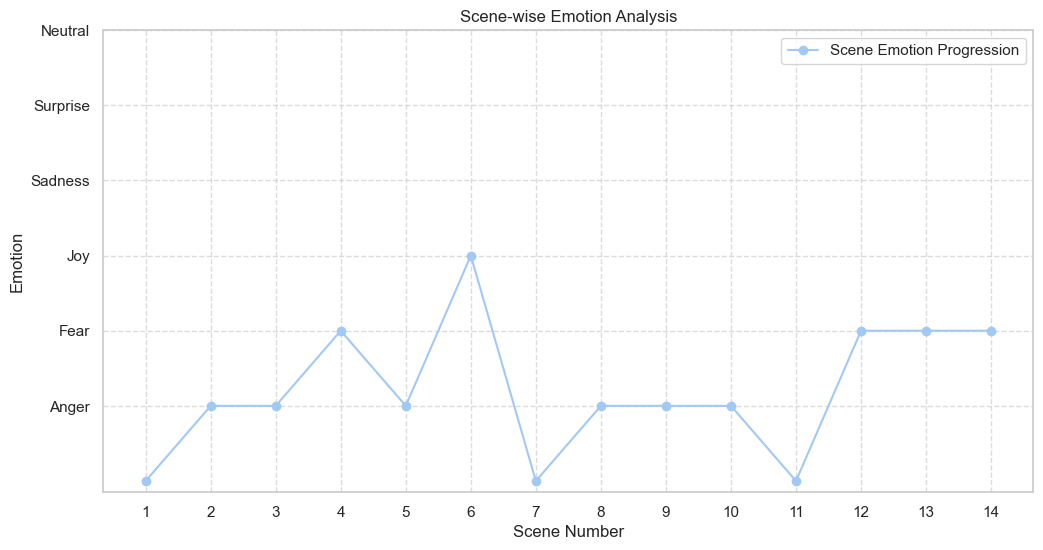

In [37]:
# ✅ Preparing data for visualization
scenes = list(range(1, len(scene_results) + 1))
scene_emotion_values = [emotion_analysis(scene) for scene in split_script_by_scenes(script_text)]

# Define emotion scores dictionary
emotion_scores = {
    'anger': 0.0851,
    'fear': 0.2556,
    'joy': 0.0298,
    'sadness': 0.2012,
    'surprise': 0.4094,
    'neutral': 0.0189
}

# Plot Overall Emotion Score Breakdown
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(emotion_scores.keys(), emotion_scores.values(), color=['red', 'purple', 'yellow', 'blue', 'orange', 'gray'])
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.title('Overall Emotion Score Breakdown')
plt.show()

# Scene-wise Emotion Analysis
plt.figure(figsize=(12, 6))
plt.plot(scenes, scene_emotion_values, marker='o', linestyle='-', color='b', label='Scene Emotion Progression')
plt.xticks(scenes)
plt.yticks(range(1, 7), labels=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Neutral'])  # Updated y-axis labels
plt.xlabel('Scene Number')
plt.ylabel('Emotion')
plt.title('Scene-wise Emotion Analysis')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Testing on New Movie Script**

In [ ]:

# Load Pretrained Tokenizer and Model
MODEL_NAME = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME).to(device)

# The Movie Script: "A REAL PAIN" by Jesse Eisenberg
movie_script = """
A REAL PAIN
by
Jesse Eisenberg
FINAL DRAFT
INT. JFK AIRPORT - MORNING
As the credits roll, we very slowly zoom in on a young man
sitting alone on a bench at a busy airport.
CUE: Chopin’s Nocturne Op. 9 No. 2
We get glimpses of the young man's face as morning travelers
pass in front of him.
This is BENJI KAPLAN. borders on melancholy.
He has an absent look on his face that
When we finally arrive in close-up, the title appears over
his face: A REAL PAIN.
EXT. BROOKLYN STREET - DAY
In a verdant Brooklyn Heights neighborhood, DAVID hustles
down the street.
He is on his phone, leaving a message for someone.
DAVID
Hey Benji, it's me. I’m just
leaving my apartment. Remember we
gotta be there three hours early.
Just ring me when you get this.
EXT. BQE - DAY
Following David’s Uber from behind as it's stuck in traffic.
INT. UBER - DAY
David is in the back seat, harried and leaving a series of
messages:
DAVID
Hey Benji, I hope you left already.
I'm stuck in a little traffic on
the BQE in case you can avoid it.
Just ring me when you get this.
ANOTHER MESSAGE:
DAVID
Benji, it's me. Good news, traffic
just cleared up, in case you were
worried. Anyway, ring me when you
get this.
2
2
AND ANOTHER:
DAVID
Yo, Benji, it's me. I'm sorry I'm
leaving so many messages. You can
disregard them cause I'll be there
soon and I can't wait to see you.
And I will not leave you another
message.
INT. JFK AIRPORT - DAY
David arrives at the airport, leaving another message as he
heads toward a check-in kiosk—
DAVID
Hey Benji, I just got to the
airport. I really hope you left
already or are on your way. Just
ring me when you get this.
He hangs up and approaches a kiosk and begins checking in—
Benji approaches from behind. He’s carrying a huge purple
hiking backpack.
BENJI
Dude.
DAVID
Benji! Yo.
BENJI
What’s up cuz!
DAVID
(hugging him)
Come here. It’s so good to see you.
BENJI
Yo, step back! Lemme look at you!
David steps back to be evaluated by Benji.
BENJI
Turn around! picture!
Let me get the whole
David laughs and does a cute little spin.
BENJI
Shit, man! Look at you -- all
healthy, wealthy and wise!
3
3
DAVID
Thank you, thank you.
(back to business)
We should probably check you in. I
did a thing online but-
BENJI
Oh no, I’m good. while ago.
I checked in a
Did you? DAVID
When did you get here?
BENJI
Few hours ago.
DAVID
Really? The flight's not for
another two hours.
BENJI
Yeah, but they open the airport
super early. You can just hang out.
DAVID
Oh.
BENJI
And you meet the craziest people
here. I met this guy Kelvin who
was from Brunei. Fucking Brunei! I
never met anyone from Brunei. Dude
was telling me all about his
business, I think he’s actually an
arms dealer but he seemed totally
at peace with the whole thing.
DAVID
Wait, who?
BENJI
Kelvin.
DAVID
Oh, right. And did you eat
anything?
BENJI
Yeah, a while ago.
DAVID
Okay, I’m gonna wanna get something
before we take off if that’s cool.
4
4
BENJI
Don’t worry. I picked you up a
yogurt.
(takes a yogurt out of his
pocket)
It’s a little warm.
DAVID
Did you really get this for me?
BENJI
Of course, dude. I figured you’d
be rushing around and everything.
DAVID
Thank you, Benji.
David prints his ticket and they begin walking to the gate.
BENJI
I also got some shit for us for
when we get in. Like: very, very
good shit.
DAVID
You're not taking weed into Poland,
right? Benji?
BENJI
They don't give a shit about that
stuff, man.
DAVID
I think they very much do give a
shit about that stuff.
BENJI
Oh, like they’re gonna arrest two
Jews in Poland for a little weed.
That’s a good look for the Polish
people.
DAVID
All right, try to keep it down-
BENJI
They can’t touch us, dude. We
basically got government immunity
there. The prodigal sons return--
INT. JFK AIRPORT HALLWAY - DAY
From behind, we see the two cousins walking toward security—
5
5
As they pass a garbage, David subtly tosses out the yogurt.
INT. JFK AIRPORT SECURITY — DAY
On the security line, the boys place their bags on the
conveyor belt.
David eyes Benji’s bag, nervously. ease -- he makes eyes with the cute TSA AGENT.
Benji seems completely at
BENJI
Hey, what’s up.
David clears security and watches from a distance as:
Benji charms the TSA agent. He's animated and funny.
David is in awe of his cousin’s charisma. bag and hustles up to David.
Benji grabs his
BENJI
Jasmine is so dope.
DAVID
Who?
BENJI
The TSA girl. Her dad does
security for the Knicks.
INT. JFK AIRPORT GATE - DAY
David and Benji wait at the gate. Benji eyes it:
David is eating trail mix.
DAVID
Do you want some? for me-
Priya made it
BENJI
Oh, sure.
Benji casually takes the bag and digs in.
DAVID
Yo, so, how you been, man?
BENJI
Honestly? I’ve been…
(closes his eyes and takes
a deep breath)
...great. Like really great.
6
6
DAVID
Oh.
BENJI
Yeah.
DAVID
Really?
BENJI
Yeah, definitely.
DAVID
Do you wanna talk about anything?
BENJI
Like what?
DAVID
Um... like... the last few months?
BENJI
What about 'em?
David wants to bring something up but can't. him, something unspoken passing between them.
Benji stares at
DAVID
Do you wanna go over our tour
itinerary or anything?
BENJI
Oh, yeah, sure.
David takes out a pamphlet. Benji grabs it and hands Dave his
trail mix.
BENJI
You mind holdin this for a minute?
DAVID
Sure.
BENJI
Eat as much as you want.
DAVID
Thanks.
(beat)
Don’t you think it’ll be nice for
us to see where Grandma was from?
Where she lived?
7
7
BENJI
Yeah, maybe. Maybe. It just sucks
that she’s not here with us.
DAVID
Well, she was really suffering. The
last couple years.
BENJI
Yeah, I know. That sucks too.
Benji looks out the window, squinting into the sun.
CUE: Chopin’s Nocturne Op. 62 No. 2
INT. AIRPLANE - DAY
The boys approach their seats. David’s trail mix.
Benji’s still chomping on
BENJI
What seat do you have?
DAVID
Uh, 24C.
BENJI
I’m B. Looks like we got the
middle and window.
DAVID
Right.
BENJI
You mind takin the middle?
INT. AIRPLANE - DAY
A few minutes later, David is squished in the middle seat.
Benji is in the window and somehow comfortably spread out.
BENJI
How you feelin in there dude?
DAVID
It’s a little tight.
BENJI
(stretching)
Yeah...
8
8
DAVID
So are you still looking for a job?
BENJI
Nah. Are you gonna have to like
work the whole trip?
DAVID
Nope - I was able to take off
completely. I wanna be here. I
wanna be present.
BENJI
Cool cool. And are you still
selling shit online?
DAVID
Well, I don’t sell old jerseys on
ebay, I do digital ad sales. God,
I don’t think we’ve spoken since I
changed jobs. You know when you
see, like, an Ad Banner online?
BENJI
Yeah, I hate that shit.
DAVID
Hey, come on-
BENJI
No, I mean, everybody hates that
shit. Right?
DAVID
Um, maybe. Do they? I don’t know.
But I sell those.
BENJI
No, that’s cool, that’s cool -
you’re like making the world go
round. It’s not your fault, you’re
just part of a fucked up system.
DAVID
Well without online ads, a lot of
the sites you’re using for free
wouldn’t be able to exist. It’s
kind of the life blood of the
internet. I’m actually working on
a campaign I think you would really
like with this young start up-
In the front of the plane, the Polish flight attendant begins
a safety demonstration—
9
9
FLIGHT ATTENDANT PA
Ladies and gentleman, if you could
direct your attention to...
David lowers his voice but keeps talking to Benji—
DAVID
So it’s a bunch of really sharp
kids who--
BENJI
Yo, dude. I think they want us to
pay attention.
DAVID
Yeah, I just wanted to tell you
about this—
BENJI
Eh, it’s kinda rude.
DAVID
Seriously?
BENJI
Yeah, man, they’re just tryin to do
their jobs.
David is embarrassed. He looks on as Benji is completely
engaged with the safety demo.
The flight attendant makes a little joke about seatbelts.
Benji laughs heartily.
CUE: Chopin’s Nocturne Op. 9 No. 1
INT. AIRPLANE - NIGHT
Later on the plane, David is awake and exhausted. He looks
over to Benji who is slumped against the window, in a deep
comfortable sleep.
Two small, empty bottles of wine sit on Benji's tray.
LATER
David is on his phone watching a video of his son.
DAVID (ON VIDEO)
How many floors is the Empire State
Building?
10
10
ABE (ON VIDEO)
103!
DAVID (ON VIDEO)
Burj Khalifa?
ABE (ON VIDEO)
155! No, 156. 156.
DAVID (ON VIDEO)
Hudson Yards?
112. ABE(ON VIDEO)
But the balcony is on 100.
David rewinds the video and rewatches it, missing his son.
LATER
David digs a bottle of prescription pills out of his bag. He
has a few drops left in a water bottle and swallows one pill.
LATER
The plane lands. He’s bleary eyed. on his face.
The lights come on. David hasn’t slept.
Benji is sleeping with a pained expression
DAVID
Yo, Benji, Benji.
Benji stirs awake.
INT. WARSAW AIRPORT - EARLY MORNING
The boys walk through the airport, both exhausted from the
flight.
DAVID
You wanna get some breakfast?
Benji just shakes his head. He has a dark look in his eyes.
INT. WARSAW AIRPORT CUSTOMS AREA - MORNING
The boys walk through the “Nothing to Declare” side of
customs.
11
11
David is silently panicking as he watches Benji’s bag go
through a sensor. David makes nervous eye contact with the
serious Polish TSA Agent.
Benji is unfazed as his bag emerges on the other side.
INT. WARSAW AIRPORT - MORNING
After they’ve cleared customs. Benji looks bleak.
DAVID
Are you okay?
BENJI
(groggily)
What? I don't know.
(suddenly bright)
Hey, there’s our guy--
Benji points to a Polish DRIVER holding a sign that says
“Heritage Tours - KAPLAN.
” Benji bounds over to him.
BENJI
Yo! What's up dude?
INT. CAR - MORNING
The boys are in the car, heading into town. Benji is staring
out the window; David is staring at his phone, AirPods in his
ears, watching the video of his son.
Benji elbows David. David takes out an AirPod.
BENJI
What are you looking at?
DAVID
Oh nothing, just this little video.
BENJI
Of what?
DAVID
(bashful)
Oh, it’s stupid. I think I’m
already homesick. It’s just Abe.
He’s obsessed with buildings now,
he wants to know the height of
every sky scraper. It’s kind of,
like, all-encompassing.
Benji nods and turns back outside. After a moment:
12
12
BENJI
Yo, lemme see it?
DAVID
The video?
BENJI
Yeah, can I see it?
DAVID
Sure, yeah. Of course.
David gives Benji one of his AirPods. They both watch the
video together.
Benji scrolls back and plays it again. David is surprised.
He notices that Benji has tears in his eyes.
BENJI
He’s fuckin gorgeous, man. You’re
lucky.
DAVID
Thanks.
Benji looks back out the window.
EXT. WARSAW - MORNING
They arrive at an upscale chain - the Warsaw Central Hotel.
INT. WARSAW HOTEL - MORNING
They approach the front desk.
RECEPTIONIST
Dzien dobry, welcome to the Warsaw
Central Hotel.
DAVID
Hi, yes. We’re checking in — we’re
with the Heritage Tour. Kaplan,
Benjamin and David. I have our
passports here.
RECEPTIONIST
Yes, of course. Welcome. You're
the final ones to arrive. And I
think I have a package for you.
It's been sitting here for many
days-
13
13
BENJI
Yeah, that's for me, thanks man.
The receptionist hands over a shoddily wrapped little box.
David is baffled as he receives the room keys--
RECEPTIONIST
You're on the fifth floor. And
there's a group meeting in thirty
minutes.
DAVID
Thank you so much.
David gathers the passports and keys and begins walking to
the elevator, eyeing Benji's box:
DAVID
What the hell is that?
BENJI
It's the weed. I told you, it's
good stuff. It's from Todd, this
fuckin barber in Ithica.
DAVID
Wait- you mailed yourself weed?
BENJI
I mailed us weed.
DAVID
Oh! I thought you were taking it
through the airport!
BENJI
Really?
DAVID
Yeah, really! Did you not see how
nervous I was?
BENJI
I did. I just thought that was you.
INT. WARSAW HOTEL HALLWAY - DAY
The boys exit the elevator and begin walking toward their
room.
Benji suddenly swings his arm around David’s neck, lovingly
rough.
14
14
BENJI
I’m so fuckin happy to be here with
you.
DAVID
Me too.
INT. WARSAW HOTEL ROOM - DAY
The boys enter their room, begin unloading their gear, taking
off their layers—
DAVID
We got a half hour. gonna need a shower.
I’m definitely
BENJI
Yes sir! Good idea.
David takes his socks off and sniffs. BENJI
Yo, dude. I totally forgot. You
have super nice feet.
DAVID
Benji notices:
Do I?
BENJI
Yeah and they’ve aged really,
really well. Your toes are like
mad straight. It’s nice.
DAVID
Thanks, man.
BENJI
No weird feet knuckles or stray
hairs. Very classy.
DAVID
Okay, thank you. really evaluated them.
I guess I never
BENJI
You never evaluated your own feet?
Damn. They’re graceful as shit.
Just like grandma’s.
DAVID
You remember grandma’s feet?
15
15
BENJI
Of course dude. She’d always wear
those plastic fuckin pink sandals
from Target. She strutted that hot
shit all over town!
DAVID
Huh. I never noticed.
Benji sits on the bed next to David.
BENJI
Yo, Davie, sometimes when I look at
you, I see her.
DAVID
I look like an old Jewish woman?
BENJI
No, man. You just look wise. It’s
beautiful.
David chokes up, to his surprise. He looks away, embarrassed.
DAVID
All right, I gotta shower.
BENJI
Cool. You mind if I shower first?
Sure. half hour.
DAVID
We just gotta be down in a
BENJI
Copy that. Can I borrow your phone?
DAVID
For what?
BENJI
I like to listen to music in the
shower.
DAVID
Don’t you have a phone?
BENJI
Yeah, but it doesn’t play music.
DAVID
Uh, okay —
David hands Benji his phone and Benji goes in the bathroom -
16
16
David lies on the bed, doesn’t know what to do with himself.
He hears Benji start playing music. Benji cycles through
multiple songs to find a good one. David is frustrated.
DAVID
You okay?
Benji finally settles on The Uniques' "My Conversation.
BENJI
”
Yup!
TWENTY MINS LATER
Another reggae song is playing from the bathroom.
David is lying on the bed, still waiting for the shower.
He stares at his bare feet, evaluating them. David’s face, ZOOM in on his feet. We ZOOM in on
Time seems to slow down.
Suddenly, Benji sticks his head out from the bathroom, blow-
drying his hair and shouting over the noise.
BENJI
We should probably head down.
INT. WARSAW HOTEL HALLWAY - MORNING
The two guys walk down the hallway. Benji is freshly
showered and relaxed. David is sweaty and exhausted.
INT. WARSAW LOBBY - MORNING
The guys walk through the hotel lobby.
As they near the restaurant, they see JAMES, a young British
tour guide, finishing a conversation with a hotel employee:
JAMES
Dzięki bardzo, Marta.
(to the boys)
Let me guess: David and Benjamin.
DAVID
Hi, yeah. You're James?
17
17
JAMES
Yes! Hi! I didn't mean to accost
you! I just wanted to intercept
you in case you couldn't find us.
DAVID
Oh, thanks. little late.
And I'm sorry we're a
BENJI
Yeah, we just wanted to shower
before we came down.
INT. WARSAW HOTEL RESTAURANT - DAY
James leads the guys towards a corner of the restaurant:
JAMES
We’re a relatively small group,
which will be nice and intimate.
They arrive at a table of four other tourists, who James
addresses:
JAMES
Success! I found them. Everyone,
this is Benji and David.
DAVID
Hi.
BENJI
Yo, what’s up everybody.
The group kind of nods toward the boys.
JAMES
Sit, sit, sit. So: I was just
about to ramble on about myself.
Hopefully you won’t be too sick of
me by the end of the week.
Some titters from the group.
Benji joins in laughing heartily, like he’s been there the
whole time. David clocks him.
JAMES
As I was saying, I'm James. I'll be
your British tour guide through
Poland. You'll have to excuse the
posh accent, it's all a ruse.
(some polite chuckles)
18
18
JAMES (CONT'D)
JAMES (CONT'D)
I’m a scholar of Eastern European
studies at Oxford. I am obsessed
with this part of the world and, in
particular, the Jewish experience,
which is fascinating and tragic and
beautiful. I’m usually the only
non-Jew on these trips, so please
feel free to correct me on anything
that feels inauthentic to you or
your family’s experience. I can
also speak Polish -- albeit like a
precocious ten year old -- so I'm
happy to translate anything to make
your trip as meaningful and
personal and satisfying as it could
be. So, blah blah blah and I’ll
stop talking now. Who wants to go
next? Why are you here? What are
you interested in? Someone take
over!
MARCIA, 60s, sharp and wry:
MARCIA
I’ll be brave. I’ll go. Hi, I’m
Marcia Kramer. Originally from
Brooklyn, with two regrettable
decades in Los Angeles. I just
moved back to New York after a
divorce - sorry if I'm oversharing,
you'll notice I tend to do that -
and found that I was turning into
the kind of woman I always detested
- a lady who lunches, basically.
Benji appreciates her humor. David notices.
MARCIA
Uh, my mother was a survivor of the
camps and literally never spoke
about it. After she died, I kicked
myself for never pushing her to
tell me about her life. So I'm
here to see where she was from, to
honor her and to... well, to stop
kicking myself.
JAMES
Thank you for sharing that, Marcia.
And you should all feel free to
over- or under- share as much you
feel comfortable. Who’s next?
DIANE AND MARK BINDER, 60s.
19
19
DIANE
Uh hi, Diane and Mark Binder.
MARK
Hello.
DIANE
We’re boring. Uh, Recently retired.
From Shaker Heights. Mark’s family
was from here, down in Lublin, but
left way before the war, the turn
of the century.
MARK
We were Mayflower Jews, was always
my little joke.
Some chuckles.
DIANE
And we were always interested in
seeing where they lived, what this
place looked like. My family was
French — we were French Jews. And
Mark and I have already been to
Paris, so this was our next trip.
MARK
Yeah, not as glamorous, my side of
the family. Sorry about that.
Titters from the group. old Rwandan man.
ELOGE speaks up. He is a 39-year-
ELOGE
Hi, I’m Eloge. As you might have
guessed, I was not born Jewish.
A little titter from the group.
ELOGE
I guess you won’t be the only one
on this trip, James.
JAMES
Happy for the company, Eloge.
ELOGE
But I did convert to Judaism, about
ten years ago. I am actually
African born, Rwandan.
This is fucking music to Benji’s ears.
20
20
ELOGE
And to answer the inevitable
question that you might be
thinking, I am a survivor of the
genocide.
BENJI
Oh shit!
They turn to Benji.
BENJI
No, sorry. I mean it in a good way.
Like shit, wow. I’m just,
interested in people from other
places. I’m sorry. I’m just,
like, a fan. Keep going, man.
There’s an awkward pause. David is mortified.
DAVID
I’m sorry about that—
ELOGE
No, please, it’s actually very
refreshing. I’m happy when anyone
is interested in my country. Like
most places, it's more complicated
than the world gives it credit for.
What’s your name?
BENJI
Benji.
ELOGE
Benji, I am an open book.
BENJI
Rad.
David can’t believe Benji gets away with this shit.
ELOGE
Anyway, I do have a unique story.
My mother and I survived the war.
And I moved to Winnipeg with her
life savings sewn into the inside
of my jacket-
BENJI
Jesus, fuck.
21
21
ELOGE
And in Winnipeg, I was helped by
the Faintuchs, a Jewish family—
BENJI
Naturally.
A little laughter from the group. ELOGE
Yes, naturally, Benji. And when I
learned about Judaism and the story
of the Jewish people, I felt at
peace for the first time since the
war. And the more I learn about
the religion and the more people I
meet — lovely people such as
yourselves - the more I know I
made the right decision.
The group is stunned.
MARCIA
I didn’t think I would be crying
before the tour even started.
Everyone laughs as the tension breaks.
JAMES
Wow. Well, this is a first. Thank
you so much, Eloge.
There is a nice pause.
BENJI
Who the hell wants to follow that?
(off their laughter)
Okay, shit, I’ll go. So Davers and
I are cousins. Actually born three
weeks apart, which is kinda nuts.
A Zloty for anyone who guesses
which one of us older.
(they laugh)
Anyway, our dads are brothers.
We’re basically brothers, too,
right D? We used to be joined at
the hip
(Irish accent)
like feckin Katie and Eilish, isn’t
that right Dave-o?
DAVID
Oh, Jesus man, don’t say that.
Benji is charming them.
22
22
BENJI
Anyway, our Grandma Dory was from
here, she survived the war in the
craziest fuckin way. In basements,
hidden amongst the uncircumcised-
DAVID
Yeah and everyone else died- her
parents, her sisters, a brother.
BENJI
It was fucked, essentially, is what
it was. And we've always wanted to
come here to see where she was
from, see the house she grew up in.
DAVID
Yeah, that's why we’re leaving the
tour a day early, Benji insisted we
see her little town. They were
super close.
BENJI
She was the coolest - just this
fierce, no bullshit, fuckin take
charge chick.
David looks around — everyone’s nodding, seemingly okay with
Benji’s vulgarity.
BENJI
And I’ve been in kind of a funk
since she died.
MARCIA
I’m so sorry, Benji.
BENJI
Yo, thank you Marcia, you’re a
sweetheart. And things have been
kinda downhill for me. She was my
favorite person in the world.
(genuinely chokes up)
Shit, I’m sorry.
JAMES
No, that’s okay, Benji. It’s good
to remember. That’s what we're
here for.
BENJI
Thanks James.
23
23
JAMES
Of course.
DAVID
So, just to keep things on track:
Grandma Dory left some money in her
will for me and Benji to come here.
BENJI
And Dave could never find the time
cause he's got a high pressured job
selling ad banners to the internet.
DAVID
Yo, come on, man.
BENJI
But I've been in such a shit place
recently, so Dave swooped in, took
some time off and arranged for us
to join this geriatric Polish tour
with you fine people.
Everyone kind of chuckles and Benji puts his hand on David’s
shoulders. David sinks in his chair a bit.
BENJI
You know: She didn’t ask any of the
other cousins to come here. Just
us.
JAMES
That’s really lovely.
BENJI
Yeah, she knew the two of us have a
special connection, right
Davercakes?
DAVID
Yeah, I'm not really sure what she
knew. At the end. She was getting
a little senile.
BENJI
No, she knew.
(squeezes Dave’s shoulder)
She knew.
CUE: Chopin’s bombastic Etude Op. 10 No. 1
24
24
EXT. WARSAW - MONTAGE
A flurry of buildings, streets, signs, daily life in this
bustling city set to Chopin's racing Etude.
EXT. WARSAW GHETTO UPRISING MONUMENT - DAY
Greco-Roman heroes stare at us from the iconic Warsaw Ghetto
Uprising Monument. Close shots on the various faces of
martyrdom. Benji and David look up at the faces.
James gathers the group near the foot of the monument:
JAMES
If I can gather everyone over here?
Thank you. I always like to start
our tour at the Ghetto Uprising
Memorial. It’s a monument to the
Jewish heroes who fought back. In
two days, we’ll be visiting a
concentration camp so I think it’s
important to immediately dispel the
pernicious myth that these were a
people led like lambs to the
slaughter.
The group nods sagely. Benji and David share a look.
JAMES
This is going to be a tour about
pain, of course. Pain and suffering
and loss, to be sure, but it must
also be a tour that celebrates a
people. A most resilient people.
CUE: Nocturne Op. 9 No. 3
EXT. WARSAW STREET - DAY
The group walks along a street in front of a Soviet-era
apartment block.
EXT. WARSAW STREET - DAY
Through a window, we see Benji buying bottles of water in a
little market kiosk.
He exits the kiosk and distributes the waters to the group.
They are thankful.
25
25
As he arrives at David, he explains that he wasn't able to
pay for the waters because he doesn't have any money. David
sighs, hands him some Złotys and Benji bounds back in to pay.
EXT. KRASINSKI GARDEN - DAY
The gang walks through this peaceful park.
Mark and Diane are asking James questions and Eloge is cross
referencing what he sees with a little Polish guide book.
Marcia walks alone.
Benji and David lag behind. Benji is amped:
David is sweaty, exhausted;
BENJI
(in awe)
Look at this shit. We’d probably
live here if the war didn’t happen.
Isn't that fuckin crazy to think
about?
DAVID
Yeah, I don’t know, maybe.
BENJI
No, seriously. Like we think of
ourselves as these very American
creations, you know? And I guess
we are. I guess that’s, like, the
essence of America — people created
from other cultures. But in some
parallel, fuckin, black hole
universe, you and I are Polish and
we probably got, like, beards and
shit. And we, like, can’t shake
hands with women.
DAVID
Yeah, it's funny, whenever I see a
Hasidic guy on the street, I always
just think,
"there but for the
grace of no god...
"
BENJI
What?
DAVID
Oh, it's just like a dumb joke.
26
26
BENJI
That's cool, man.
(looking ahead)
Yo shit, look at her.
DAVID
What, who?
BENJI
That woman Marcia, she’s walkin
alone. We should go talk to her.
DAVID
We just met her.
BENJI
Yeah, but she’s got this, like,
deep sadness behind her eyes.
DAVID
She does?
BENJI
You didn’t notice that?
DAVID
During the introductions? I don't
know.
BENJI
We should go check on her.
DAVID
Benji, maybe she wants to be alone.
BENJI
No one wants to be alone, Dave.
I’m gonna go check it out.
Benji’s runs off to check on Marcia.
David is left alone, a little miffed. He watches as:
Benji catches up to Marcia. each other and Marcia seems emotional.
They are speaking animatedly to
David speeds up to join them but stutters when he hears:
MARCIA
People will eat you alive if you
give them a fuckin inch.
David watches as Benji nods knowingly and puts his hand on
Marcia’s shoulder.
27
27
Then Marcia reaches up and holds Benji’s hand. baffled.
Benji and Marcia walk like this for a bit. some kind of catharsis and Benji is comforting her.
David is
She clearly had
EXT. WALICOW STREET - DAY
The group walks through the ruins of Warsaw, which abut the
height of Central European modernity.
We see the mix of old and new, the bullet holes and the mid-
century rebuild.
EXT. PLAC GRZYBOWSKI - DAY
Benji precariously skips along stones, which jut out of a
pond.
Jump back to reveal that the group is patiently waiting for
him to finish his antics. No one seems to mind.
EXT. PLAC GRZYBOWSKI CAFE - DAY
David exits a cafe with a tray of food. Feeling unsocial, he
takes a seat alone.
After a moment, Benji comes out and spots David:
BENJI
Yo!
TEN MINUTES LATER
Benji and David sit across from each other, eating rye soup-
DAVID
What was going on with that woman?
BENJI
What do you mean?
DAVID
The woman with the 'sadness in her
eyes'
. Is she all right?
BENJI
Oh Marcia! Yeah, she’s in a really
weird place right now.
28
28
DAVID
She told you that?
BENJI
Yeah, I guess she thinks I can
relate since we've both lost
people.
DAVID
You mean our grandma?
BENJI
Yeah. Anyway, she's super fuckin
stressed right now because her
husband left her last May, like
completely out of the blue-
DAVID
Jesus—
BENJI
Yeah, not fun.
DAVID
No. And she just told you all this?
BENJI
Yeah. And now she’s seeing this new
guy, Darren, which you’d think
she’d be happy about, but he sounds
like a complete douchebag.
DAVID
Oh really, how?
BENJI
(hesitates)
Ah, I don’t know man. I don’t think
we should be talking about her
behind her back.
Oh, okay. DAVID
I was just asking.
BENJI
No, I know. Still.
There’s an uncomfortable pause. DAVID
Weird soup, right?
BENJI
They both slurp their soup.
I love it.
29
29
CUE: Chopin's Waltz No. 1 Op. 18
EXT. KREDYTOWA STREET - DAY
From high, we see the group walk through this bohemian drag.
EXT. ŚWIĘTOJERSKA STREET - DAY
The group passes a fragment of the old Ghetto Wall.
EXT. WARSAW UPRISING MONUMENT - DAY
The group approaches the dramatic Warsaw Uprising Monument--
massive bronze soldiers in battle positions.
JAMES
This monument truly speaks to the
tragic complexity of Polish
history. The Warsaw Uprising was
perhaps more tragic in the Russian
response to the uprising than the
German crushing of the rebellion.
On Benji and David, listening—
JAMES
These two supposed allies, brothers
against a common enemy. But
infighting and spite tore them
apart.
Back to James—
JAMES
You see, Stalin resented the
resistance as they’d fought him for
independence and so he stood back,
letting Germany crush the
resistance in 63 short days. It’s
harrowing. Anyway, I’m sure you
want to take pictures, it’s a
pretty spectacular sight. But
please come to me with any
questions, I’m all too happy to
talk about the puzzle of Polish
history.
Mark and Diane approach James with questions. pictures.
Benji approaches Eloge.
The rest take
30
30
BENJI
Yo, Eloge, when you’re done, could
you take a picture of me and Dave
posing with the guys?
ELOGE
Yes, of course.
DAVID
What?
BENJI
We should go pose with the guys,
it’ll be hysterical.
DAVID
Really? Doesn’t that seem, like,
disrespectful?
BENJI
How the fuck is it disrespectful?
We’re on their side! Fighting the
Ruskies and the Krauts!
DAVID
Yeah, I don’t know if we should-
BENJI
Okay, then just take a picture of
me, fighting with my Polish
brethren. Gentlemen, I’m going in.
Benji salutes and runs to the monument. cutely among the huge bronze soldiers.
DAVID
You look great, Benji. I got some
good shots.
BENJI
Yeah?? Does it look real?
DAVID
Well they’re twice the size of you.
And metal.
He positions himself
BENJI
I know! I need some back up! on up here with me, dude!
DAVID
Benji, no. Really. Please.
Come
31
31
BENJI
Eloge, you gonna enlist?
ELOGE
I’m not a fighter, Benji, thank
you.
BENJI
Okay, well you can be a medic or
something! Come on up! It’ll be
funny! Your mom will love the
pictures.
Eloge looks to David.
ELOGE
This is so silly.
DAVID
Yeah, I know.
ELOGE
(Handing David his phone)
Can you take a picture of me?
DAVID
Oh. Really? Sure, I guess so.
Eloge joins Benji under the monument.
BENJI
Okay, so you're the medic — maybe
you just jumped out of a copter and
you got a fuckin first aid kit and
you're patching up this guy's leg
here.
Eloge laughs and kneels next to one of the bronze soldiers,
“patching up his leg.
”
BENJI
Oh yeah! He’s got gangrene. Holy
shit! It’s fuckin oozing!
ELOGE
(in character)
Don’t worry. I have prepared for
this moment.
BENJI
Of course you have. We got a young
Florrie Nightingale over here!
David, you gettin all this?
32
32
David is taking pictures on both guys' phones.
DAVID
Yeah, I got it.
BENJI
Is it funny?
DAVID
It’s funny, yeah.
BENJI
You sure you don’t wanna come up
here? We could use the manpower.
DAVID
Nah, I’m good. from "central command.
I’ll just... watch
"
BENJI
Ha! That’s a good one Dave.
"Central Command!"
Suddenly, Mark appears at the monument, posing next to Benji
and Eloge.
MARK
Men? Can I join up?
BENJI
You bet, Marky Mark!
MARK
Diane? You getting this?
BENJI
Hey! We got another man. We’re
gonna take this hill.
David takes pictures. He enjoys seeing Benji so happy but is
also looking over his shoulder for security.
BENJI
Jesus, this is a real fuckin'
sausage party. Marcia, come on up
here!
MARCIA
I don’t know.
BENJI
Marcia Marcia Marcia! Your country
needs you!
33
33
MARCIA
You’re very persuasive, Benji.
BENJI
I know! Give your phone to Davie,
he’s a great photographer.
Marcia gives her phone to David and heads up to the monument.
BENJI
You wanna work with Eloge on this
dude’s leg?
MARCIA
No, I’m a fighter. Gimme a gun.
Ho ho ho! BENJI
Look at you!
Marcia pretends to be a soldier, finding it funny and
awkward.
David is now taking pictures with three people’s phones.
BENJI
Okay, we got these fuckin Nazis
right where we want ‘em. We need
all hands on deck. Diane, James!
Come on. Dave’ll take the
pictures. It’ll be hysterical.
Diane brings her phone to David.
DIANE
I can’t believe I’m doing this.
Thank you, David.
DAVID
Sure.
Diane runs up next to her husband. with his phone.
James approaches David
JAMES
You sure don’t want to go up?
DAVID
Uh, yeah, I’m great. I got some
good shots earlier when it was
empty, so…
JAMES
Oh, I feel bad, this is your tour.
34
34
BENJI
(a British accent)
Jimothy! We need a gunnah’ from
the RAF!
JAMES
I’m coming!
(to David:)
And you really don’t mind taking a
picture?
DAVID
No, it’s fine.
James hands David his phone and joins the group. Now
everyone is posing on the monument except David who has to
take pictures with five cameras.
BENJI
Okay, everyone pick a pose and
freeze in it so Dave could take a
picture. Is that cool with you
Dave?
DAVID
Yup.
They all freeze as David takes a picture on each phone. It’s
awkward for him as he has to put the phones in his pocket to
make sure he gets a shot on each one.
BENJI
You almost done Dave? My arms are
gettin tired.
DAVID
Yeah, I got it.
David takes a shot with the last phone.
BENJI
Okay, men! Stand down!
They all kind of laugh and walk off the monument.
BENJI
You were all incredibly brave.
Unfortunately, we lost the war big
time.
They all laugh as Benji approaches David.
35
35
BENJI
Thank you so much, dude. That was
so fuckin fun.
EXT. WARSAW HOTEL - NIGHT
The group enters the hotel, the nice energy from the day
lingering in the air. David feels a bit left out.
INT. WARSAW HOTEL ELEVATOR — NIGHT
David and Benji ride up in the elevator with Eloge, Diane and
Mark. It stops on Benji and David's floor.
BENJI
This is us. Good night you freaks.
Long day tomorrow.
They ad lib goodnights to Benji.
EXT. WARSAW HOTEL HOTEL HALLWAY - NIGHT
The boys walk down the hall towards the room.
INT. WARSAW HOTEL ROOM - NIGHT
David and Benji enter their room.
BENJI
Hey Dave.
DAVID
Yeah?
BENJI
Come in the bathroom with me for a
sec.
DAVID
What? Why?
INT. WARSAW HOTEL BATHROOM - NIGHT
David squeezes into the cramped bathroom. door.
Benji closes the
DAVID
Why are we in here?
36
36
BENJI
(huddling up intensely)
I just wanna thank you so much for
doin this with me. I know it was
tough for you to take off work,
leave your little boy. But I didn’t
realize I how much I needed this.
DAVID
Well that’s great, man. to... see you happy. been a tough few months-
I’m happy
I know it's
BENJI
--And I also wanted to say that I
know you’re not the most
comfortable person with groups and
people and social shit like that.
DAVID
I’m not?
BENJI
No. So it’s amazing that you’re
here and puttin yourself out there
so boldly for me.
DAVID
Seriously?
BENJI
Yeah.
DAVID
Thanks, man.
BENJI
Good. Now let’s go back out there
and share a J.
INT. WARSAW HOTEL ROOM - NIGHT
Benji exits the bathroom walks straight to the window and
opens it. But it only opens a few inches.
BENJI
Yo, look at this fuckin
infantilizing, corporate bullshit.
DAVID
What do you mean?
37
37
BENJI
We can’t smoke with this shit open
two inches.
DAVID
Yo, I think I might just wanna
crash, man. We’ve been up for like
24 hours.
BENJI
Don’t say you’re going to sleep on
me, Davie. This is our first night
together in fuckin years.
DAVID
I don’t know. haven’t showered.
I’m exhausted and I
BENJI
Yo, the weed will help you sleep.
DAVID
Is it the kind that helps you
sleep?
BENJI
No, it’s the other kind.
(David laughs)
Listen: You take a shower — do
whatever you gotta do to feel like
you — and I’ll roll us a fat ass
blunt and we’ll go on the roof.
INT. WARSAW HOTEL ELEVATOR - NIGHT
David, freshly dressed and Benji, fat ass blunt in his ear,
ride the elevator. There’s a fun spirit in the air.
INT. WARSAW HOTEL HALLWAY OF TOP FLOOR — NIGHT
The boys exit the elevator.
BENJI
(like a dowser)
Okay, okay, which way are you?
DAVID
Uh, maybe they don’t make their
roof accessible for American
assholes trying to smoke weed--
But Benji is already walking down the hallway.
38
38
At the end of the hallway is a door with a sign in Polish and
an alarm.
BENJI
You think this is it?
DAVID
I think there’s a big fucking alarm
that’s gonna go off.
BENJI
So if it does, we just say we don’t
speak Polish. Which is true.
David is backing away.
DAVID
Benji, let’s just go back down.
Okay. BENJI
I guess you’re right, Dave.
Benji walks with David and then, suddenly, turns back and
runs toward the door, slamming it open—
DAVID
Benji!
But there’s no alarm. It’s quiet. David is relieved.
Benji looks at David with an electricity in his eyes.
BENJI
Apres vous...
INT. WARSAW HOTEL STAIRWELL - NIGHT
The boys giggle as they race up the stairwell.
Benji opens the door to the roof —
EXT. WARSAW HOTEL ROOF — NIGHT
The boys are at the edge of the roof, which overlooks Warsaw.
It’s gorgeous.
Benji exhales a huge hit, passes it to David, who takes a
hit. Passes it back.
BENJI
There’s my guy. dude?
How you feeling,
39
39
DAVID
(enjoying it)
I’m okay.
BENJI
(Intensely)
Yo. How you feeling dude?
DAVID
I feel good. I feel good.
BENJI
See? You just needed a little
drugs in your system.
Oh yeah? DAVID
That’s all I was missing?
BENJI
Yeah. You’re like an awesome guy
stuck inside the body of someone
who's always running late. And I
gotta fish that awesome guy out
every time I see you.
DAVID
Thank you, I guess?
BENJI
When I think of us, I think of us
walking around New York all night.
Seeing if we could make it through
til morning.
DAVID
You always did.
BENJI
And you’d always fall asleep
halfway through. We’d make it over
the Willie B and you’d conk out on
a bench in Chinatown.
DAVID
I know.
BENJI
You were kind of a light weight.
DAVID
I’m sorry.
BENJI
I’d have to stay up and keep watch.
40
40
DAVID
Oh.
BENJI
Make sure you weren’t pecked to
death by pigeons.
David laughs - but the mood has shifted a bit sour. David
looks at Benji as Benji exhales a huge puff.
INT. WARSAW HOTEL ELEVATOR - NIGHT
The boys ride back down the elevator in silence.
INT. WARSAW HOTEL ROOM - NIGHT
The boys lie on their separate beds. They’re eating chips
from the mini bar and Benji is nursing a little bottle of
vodka.
The TV is playing the cheesy hotel menu on a loop. stare at it, stoned and mesmerized.
They
BENJI
Dave.
DAVID
Yo.
Pause.
BENJI
I’m sorry I called you a light
weight.
DAVID
It’s okay. I’m sorry I would
always fall asleep.
BENJI
It’s okay. You had like a job and
a wife. You were awake all day,
doing important shit.
DAVID
Yeah, I guess.
BENJI
You’re not a light weight.
DAVID
Thanks Benji.
41
41
BENJI
You were the only person who even
tried to stay up with me.
Benji takes a swig of vodka and becomes contemplative:
BENJI
I always wanted to hang out at
night, when everyone else was gone -
to have the city to ourselves. But
I could never get anybody to come
with me.
They eat their chips in silence.
BENJI
I didn’t care that you fell asleep.
I was just happy you were there.
David nods, touched.
CUE: Chopin’s Nocturne Op. 15 No. 1
INT. WARSAW HOTEL ROOM - MORNING
David wakes up. He looks over to the other bed:
Benji is still sleeping. A few more mini vodka bottles lie
around his head.
INT. WARSAW HOTEL BATHROOM - MORNING
David is in the bathroom, whispering on FaceTime with Priya.
She’s telling him a story about Abe and he’s laughing.
David is in the shower. Shaving.
David swallows one of his pills, drinking from the faucet.
INT. WARSAW HOTEL ROOM - MORNING
David reenters the room, freshly showered. Benji is still
sleeping. David stands over his cousin, looking at him.
In his sleep, Benji has a pained look on his face.
DAVID
Benji.
(Benji sleepily swats him)
Benji, dude. We gotta go. Train’s
in an hour. Everyone’s downstairs.
42
42
Benji groans.
INT. WARSAW HOTEL HALLWAY - MORNING
Benji reluctantly trudging through the hall, following David.
EXT. WARSAW HOTEL - MORNING
The group is waiting outside for the boys.
DAVID
Hi, guys. Sorry we’re a little
late.
Benji perks up when he sees everyone, his erratic charisma
suddenly alighting.
BENJI
Dave literally woke me up two
minutes ago. Ha.
INT. WARSAW TRAIN STATION - DAY
The group walks through the train station. all in like a little kid.
Benji takes it
INT. WARSAW TRAIN STATION PLATFORM - DAY
The group approaches the train. front.
James leads them to the
JAMES
Luckily, included in your tour fee,
we all get first class seats — not
too bad, huh?
MARCIA
Ooh, fancy.
DIANE
Love the exchange rate.
As they board the train, David looks happy, Benji looks
skeptical.
EXT. TRAIN - DAY
Moving southeast through Central Poland’s Countryside.
43
43
INT. TRAIN - DAY
The group rides in a sparsely filled first class car. They
each have a nice breakfast meal on trays in front of them and
are eating their food as they listen to James.
JAMES
And if we have time, I think
Underground Lublin is a
fascinating, if overhyped,
destination. But the real heart of
the city is the Grodzka gate...
As James continues, Benji turns and whispers to David.
BENJI
Yo dude, I think we should move.
DAVID
What?
BENJI
I think we should move to a
different train car.
DAVID
What do you mean?
BENJI
Don’t you feel weird being in a
first class car?
DAVID
No. We paid for it. It’s not
hurting anybody.
BENJI
Dude. We are Jews on a train in
Poland. Think about it.
James notices Benji-
JAMES
Benji, is everything okay?
DAVID
Yes, it’s fine. We’re fine. Sorry
about that.
BENJI
Yeah, sorry about that J.
44
44
JAMES
Of course. No worries. So as I
was saying, the lantern was not ex—
Benji can’t help himself. He addresses the group-
BENJI
I just feel like — is no one else
feeling this?
Pause--
MARCIA
Feeling what?
BENJI
Just the creepy feeling of being,
like, royalty on this train, you
know? Does anyone not see the
irony here?
DAVID
Benji, please -
BENJI
Like eating this fancy food?
Sitting up here when, eighty years
ago we would have been herded into
the backs of these things like
fuckin’ cattle—
MARCIA
Oh, come on, Benji, stop that—
DAVID
Yeah, I don’t think everyone wants
to hear that—
BENJI
Well, why not—
DAVID
Because it’s depressing--
JAMES
No it’s okay. If I may: Benji
raises an interesting sensitivity.
People often have the experience,
coming here on these tours, staying
in nice hotels, eating nice food,
while exploring the horrors of
their family’s lives.
The group takes this in. Benji nods, feeling validated.
45
45
JAMES
There’s certainly feelings of
discomfort and even a kind of
guilt, of comparing their lives to
those who--
MARK
I don’t feel guilt.
JAMES
Nor should you.
MARK
Why would I feel guilt?
JAMES
I’m not suggesting you should, Mark-
Benji is reactivated!
BENJI
Because our lives are so fuckin
pampered and privileged! Like we
completely cut ourselves off from
anyone’s else true pain — like the
actual experience of being shoved
into a train car, your fuckin head
bashed in--
MARK
So what are we supposed to do about
that?
DIANE
Mark, please--
BENJI
Uh, I don’t know-- Acknowledge it
maybe? Try to feel it in some way?
DAVID
Benji, why are you doing this?
BENJI
I’m just sayin how I feel, Dave.
DAVID
And why is that important now?
Some titters from the group.
46
46
BENJI
Yo, Dave, you used to feel
everything. He was such an
adorable, anxious kid!
DAVID
Benji, Jesus--
BENJI
We went to Jewy sleep-away camp
together and he cried the whole
first week cause he was homesick.
Literally the whole week.
DAVID
Benji, what the fuck!
BENJI
And I would have to hug him to
sleep and talk about his sweet
fuckin mom to calm him down. And
now look at him. Comfortable,
buttoned up, topiaries his wild ass
Jew fro into submission.
DAVID
Benji!
BENJI
It’s all mad impressive.
The group is mildly appalled.
BENJI
You’re all mad impressive. But I
think I’m gonna move to the back of
the train.
MARK
I don’t think you’ll find much
suffering back there either.
DIANE
-Mark, stop it.
Benji, deflated, walks away. him go, mystified by his behavior.
David turns back and watches
JAMES
I’m sorry if that was uncomfortable
for anyone. These triggers
certainly do arise anywhere.
Usually not on a moving train, but-
47
47
Some laughter from the group -
DAVID
Hey, James? back there. food.
I should probably go
At least bring him his
JAMES
Of course. Of course. You know
where to get off?
DAVID
Yeah, Lublin Glowny? I must be
mispronouncing it.
JAMES
Don’t worry – you’re very close.
It’s the next stop.
David picks up Benji’s food tray and heads back.
INT. TRAIN CAR - DAY
David is walking through a more crowded part of the train,
looking for Benji. He doesn’t see him.
INT. SECOND TRAIN CAR - DAY
David enters the next car. sitting alone.
David sits next to him. Halfway down, he sees Benji,
It’s a quiet and sweet moment.
DAVID
Hey man.
David undoes Benji's tray and sets his food down.
BENJI
Thanks.
DAVID
Are you okay?
BENJI
(sadly)
Everyone just wants to have a
fuckin joyride, you know?
DAVID
What do you mean?
48
48
BENJI
People can’t just walk around the
world being… happy all the time.
DAVID
(gently)
It’s okay, man.
Benji digs into his food. David leans back, tired.
EXT. POLAND COUNTRYSIDE - DAY
The train speeds past us in various locations.
INT. TRAIN - DAY
Moving down the aisle, we find David fast asleep in his seat,
Benji just watching him.
The train pulls into a station and David startles awake.
BENJI
(calmly)
Hey man.
DAVID
Did I fall asleep?
BENJI
Yeah, you did.
DAVID
All right, well let’s go. Come on.
David grabs his bag and heads for the exit. looking guilty.
Benji follows,
EXT. KRASNIK PLATFORM - DAY
The boys emerge onto the platform and begin walking toward
the exit. Behind them, the train pulls away.
David looks around the platform.
DAVID
I guess everyone’s waiting outside
for us.
BENJI
Hey Dave.
49
49
DAVID
Yeah?
BENJI
We’re not at the right train
station.
DAVID
What do you mean?
David looks around. “Krasnik.
”
He sees the large station sign says,
DAVID
Oh shit. What the fuck is Krasnik?
We’re supposed to get off at
Lublin.
BENJI
Yeah, you were out pretty fuckin
cold.
DAVID
You mean, we passed Lublin already?
BENJI
A while ago.
DAVID
And you didn’t wake me up?
BENJI
You were gettin such a good nap,
dude.
DAVID
Jesus!
BENJI
Dave, you were drooling and snoring
and everything, I couldn’t bring
myself to wake you up.
DAVID
You have like the most fucked up
sense of priorities.
David begins walking toward the station exit. Benji hustles
up—
BENJI
Dave, come on. Don’t be mad at me.
50
50
DAVID
How could I not be mad at you?
BENJI
Cause I was staring at you sleepin.
And you were snoring so weirdly and
loudly and everyone was lookin and
some people were laughing and I was
just thinkin: this is my cousin,
Davey. I’m not ashamed of him.
This is Davey On The Bench in
Chinatown. This is the cousin I
used to have all to myself.
David softens and turns back around.
DAVID
All right, so what do we do now?
BENJI
Oh, I already worked all that shit
out.
DAVID
Did you?
BENJI
Yeah, while you were sleeping.
DAVID
Great. What do you got?
BENJI
Lublin was the last stop, right?
So we hop onto the train on the
other side of the platform, going
in the opposite direction. And
that’ll take us back to Lublin.
Just email James and tell him we
got a little sidetracked.
DAVID
Huh. Okay.
BENJI
And we don’t even need to get
tickets.
DAVID
What do you mean?
BENJI
I mean, we’re only tryin to go one
stop, right?
51
51
BENJI (CONT'D)
BENJI (CONT'D)
We just gotta avoid the conductor
til we get there. I do shit like
this all the time upstate. It’s
fuckin fool proof.
(looks across the
platform)
All right - here we go!
MOMENTS LATER
The boys sprint around to the train on the opposing platform.
A CONDUCTOR is near a car at the front.
DAVID
We should just buy tickets like
normal people.
BENJI
No time. Come on!
The boys run down the platform to enter the back of the
train. Benji nods to David like they’re preparing for a bank
heist and they hop on.
INT. TRAIN - DAY
The boys move through the train, heading towards the front.
BENJI
We stay moving, we stay light, we
stay agile. He’s gonna be coming
through the train, takin tickets.
We pass him — probably somewhere
around the middle of the train- and
we tell him we’re goin to the
bathroom. Then he’s gonna get to
the back of the train and start
heading back up toward the front
lookin for stragglers.
DAVID
We’re the stragglers?
BENJI
Yes. And by the time he gets to
the front, the train’ll be in the
station and we’ll be home free.
DAVID
This is so fucking stupid.
52
52
BENJI
No, what’s stupid is the
corporatization of travel.
Ensuring the rich move around the
world to propagate their elitist
loins while the poor stay cut off
from society.
DAVID
That’s good - we can argue Marxism
when they’re hauling us off to
Siberia.
BENJI
Siberia’s in Russia, Dave.
They enter the next car—
DAVID
This is ridiculous. Tickets are
probably like twelve bucks!
BENJI
It’s the principle of the thing.
We shouldn’t have to pay for train
tickets in Poland. This is our
country!
DAVID
No it’s not! It WAS our country.
They kicked us out because they
thought we were cheap!
The boys enter the next car. David is increasingly nervous.
They see the conductor enter from the other side.
CONDUCTOR
(In Polish)
Tickets. Have your tickets ready.
BENJI
This is it, buddy. natural.
Stay calm, act
They approach the conductor:
BENJI
Hi! Just bathroom. Me and cousin
go to just bathroom, thank you.
CONDUCTOR
(In perfect English)
Bathroom’s on either side.
53
53
BENJI
With thanks. Thank you.
DAVID
Yes, thank you.
The boys exit the car and catch their breath in the
vestibule.
DAVID
Jesus, my heart’s in my fucking
throat!
BENJI
Feels good, doesn’t it? not out of the woods yet. But we’re
We get
to the front and take shelter til
we get to our stop.
As the boys make their way through the cars, something
loosens inside David. We move past Benji and closer on David
as a nostalgic smile grows on his face.
INT. FRONT CAR - DAY
The boys enter the front car and find seats. They plop down,
ecstatic.
DAVID
We made it.
BENJI
Don’t fall asleep on me again,
brother.
DAVID
I won’t.
(Looks around)
Hey Benji.
BENJI
Yeah.
DAVID
We’re in first class.
Benji looks around, thinks about it.
BENJI
Yeah, but we fuckin earned it.
54
54
EXT. LUBLIN STATION — DAY
The train pulls into the Lublin Glowny Station. walk along the platform, looking for the exit.
The boys
EXT. LUBLIN STATION - DAY
The boys emerge to find James and the group, in various
stages of irritation.
BENJI
Hey everybody. I’m super sorry
we’re late. Dave fell asleep.
EXT. STAIRS TO CASTLE - DAY
The group ascends the massive staircase that leads to the
castle.
JAMES
I want today to be as vibrant as it
is melancholic. Lublin has such a
rich Jewish history. It was
actually called The Jewish Oxford.
It was diverse, intellectually and
culturally. It was progressive,
open, welcoming. And it’s hard to
say whether the Jewish community
was attracted to Lublin for these
reasons or if the Jewish community
was responsible for these local
virtues. It’s probably a little of
both.
But I want today to feel
enlightening. To understand the
scope and importance of Jewish
contributions. This is the Lublin
of Rebbe Horowitz, the Seer of
Lublin, of Isaac Bashevis Singer,
of poets, writers, merchants,
intellectuals.
EXT. BRIDGE FROM ZAMKOWA STREET - DAY
The group walks along the gorgeous bridge to the gate. approaches Eloge:
David
DAVID
So, you’re like really religious?
55
55
ELOGE
Yes, I am David.
DAVID
That’s amazing to me.
ELOGE
Is it?
DAVID
Yeah. You do all the customs?
ELOGE
Not all, but I do keep Shabbat.
It’s mediative, it gives me a
chance to unwind, to refocus. you?
And
DAVID
No. The whole thing always seemed
like a little archaic and arbitrary
and mechanical to me. No offense.
ELOGE
None taken, but I think it would
really benefit you.
DAVID
You mean like benefit everyone or,
like, me specifically?
ELOGE
You specifically.
Up ahead, Marcia approaches Benji. David looks on--
MARCIA
Benji-
BENJI
Yo.
MARCIA
(chuckling)
“Yo.
"
They walk a little bit. They like each other’s company.
MARCIA
I wanted to say that I’ve been
thinking about what you said on the
train. About understanding
suffering. It really stirred me.
56
56
BENJI
Yo, seriously Marcia?
MARCIA
Yes.
BENJI
Dope.
MARCIA
You know, last year, my daughter
married a very rich man-
BENJI
-Oh fuck-
MARCIA
-And she can barely have a
conversation with any depth
anymore. She’s lost any
perspective on the real world.
BENJI
Of course she has! Money’s like
fuckin heroin for boring people.
MARCIA
Well, I don’t know what that means.
But it’s so easy to float through
life, forgetting how lucky we are.
BENJI
Exactly!
DAVID
See, Benji? Look at that! You’re
an inspiration.
Marcia side-eyes David as Eloge approaches.
ELOGE
Hi, yes, I’m eavesdropping, is that
okay?
BENJI
Of course, Eloge, come on in!
Eloge sidles up, David getting sidelined—
ELOGE
I want to echo what Marcia said, if
that’s all right.
57
57
BENJI
Really?
DAVID
Really?
ELOGE
Yes, of course. I find myself
constantly baffled by the way the
world seems to carry on like there
aren't a million reasons to mourn,
to be shocked, to be appalled.
BENJI
Yo, that’s what I’m saying!
David can’t believe Benji is getting this reaction. reinserts himself-
He
DAVID
I don’t know. If we wept for every
sad thing in the world, what would
that accomplish?
BENJI
Uh, maybe sad shit wouldn’t
constantly happen?
MARCIA
Exactly. David, we numb ourselves
to avoid thinking about the impact
we have-
ELOGE
Ignoring the proverbial slaughter
house to enjoy the steak, as it
were-
BENJI
Yes, Eloge! analogy.
Damn, that’s a good
DAVID
And I get all that. It just seems
like there’s a time and a place for
grieving and maybe it’s-
BENJI
Dave, we’re on a fuckin Holocaust
tour. If now isn’t the time and
place to grieve, to open up, then I
don’t know what to tell you, man.
Benji walks on and his new minions, Eloge and Marcia.
58
58
David slows down, contemplating. gate.
They approach the central
JAMES
If I can get everyone’s attention.
This is the famous Grodzka Gate or,
as it was once known, The Jewish
Gate. On the other side of this
gate was the Jewish Quarter. As we
walk through, I want you to try to
imagine what life must have been
like here hundreds of years ago.
The parking lots, the hair salons,
the recently paved roads used to be
Jewish houses, synagogues, shops.
Try to avoid conjuring images of
the horrors-to-come and just
imagine a vibrant city.
On David and Benji, passing through light patches of the dark
tunnel—
JAMES
Try to imagine what could have
been, the promise, the hope—
The group passes through the tunnel, emerging into the light.
EXT. LUBLIN - MONTAGE
Nocturne Op. 9 No. 2 plays over the following:
JAMES (VO)
The memories of Jewish life are
here, but they’re hidden around
this city, moments trapped in
amber. There aren’t monuments or
statues. The only synagogue is a
now-defunct second floor office
building. But there are little
moments of history frozen in time,
peeking out, waiting for us.
Emblems of a people, of stories, of
contributions.
As he speaks, we see a montage of shots from around the city:
-An unremarkable grocery store with a plaque above the door
JAMES (VO)
A former Yiddish theater.
-A medical academy building, the site of a former Yeshiva
59
59
JAMES (VO)
A former Yeshiva.
-Hebrew letters in relief on the side of a building
JAMES (VO)
A former Hebrew printing house.
EXT. GRAVEL STREET - AFTERNOON
In a wide tableau, the group ambles along this uneven path at
the edge of town. Benji throws his arm around David and
pinches his cheek.
EXT. CEMETERY – DUSK
At the top of the hill is the Jewish cemetery, a rough patch
of land with scattered tombstones.
The group naturally fans out, taking it all in. lingers around James--
Eloge
JAMES
So there’s a bit of a discrepancy
about the founding of the cemetery
but most have it pegged at 1541.
Think about that. Before the
founding of the United States,
before Shakespeare, before the
locomotive. And, if I may, the
oldest tombstone in all of Poland
is actually here.
ELOGE
Ah, yes, Kopleman, right?
JAMES
Ding ding ding. That’s right,
Eloge.
ELOGE
I read about it this morning.
Don’t be too impressed.
JAMES
He’s actually buried right back
here. It’s rather unremarkable if
you don’t know the history—
As James and Eloge continue, Benji rolls his eyes at David.
60
60
David responds with a quizzical expression, like “What’s
wrong?”
Benji claps one hand together and motions toward James, as if
to say “James won’t shut the fuck up.
”
David looks at Benji like,
“Who the fuck cares?”
Benji responds with an expression like,
“I fucking care.
”
Benji starts heading over to James. David knows it’s not
good.
BENJI
Hey James, Eloge—
DAVID
Oh shit—
BENJI
Yo, James.
DAVID
Benji--
JAMES
Yes, Benji.
BENJI
You’re like completely
knowledgeable about all this shit
and it’s mad impressive and we all
know that now but like –
DAVID
Benji- stop it.
BENJI
But like these are real people.
These are not little factoids lying
under here. Okay? They’re not
history lessons.
DAVID
Benji, calm down.
BENJI
Hold up, Davie.
JAMES
I’m sorry, Benji, did I say
something to upset you?
61
61
BENJI
I mean, you know your shit, don’t
get me wrong. And Eloge, you
totally know your shit, which is
doubly impressive. But it’s just
like, the constant barrage of stats
is kinda making this trip a little
cold, you know?
Eloge looks down at the ground, embarrassed.
JAMES
(trying for levity)
I’m sorry. It’s the Brit in me.
BENJI
And, like, part of the problem, if
we’re bein honest right now, with
the tour is that we’ve been cut off
from anything real.
JAMES
Excuse me?
DAVID
Benji- what the hell-
BENJI
Don’t take this the wrong way or
anything, but we’ve just been going
from one touristy thing to another,
not meeting anyone who’s actually
Polish-
JAMES
Benji, I’m sorry to say this, but
that’s kind of what these tours
are. You signed up for this tour.
BENJI
Dave signed up for the tour.
James is incredibly uncomfortable. He looks to David, who is
mortified. After a pause, Benji releases the tension--
BENJI
And it’s a mostly amazing tour,
Jimbo. Like, really. I’m lovin it
and it’s totally Dave’s speed. But
maybe just chill with the facts and
figures for a little bit. Is that
cool?
62
62
JAMES
(regaining his composure)
Yes, we could certainly tone it
down for a bit, sure. In fact, I
was going to suggest that we all
place a small rock or pebble on Mr.
Kopleman’s stone.
DAVID
That sounds like a great idea.
BENJI
Yeah, dude, that’s what I’m talking
about. Thanks J. Thanks E.
JAMES
Of course.
ELOGE
Yes.
James, still rattled, calls the group over to Kopleman.
JAMES
Um, if I can get everyone to join
me over here. This stone here is
thought to be the oldest tombstone
in Poland. It’s a man called Jacob
Kopleman Levi, who was a real
person. A real Polish person...
from Poland-
James and Benji exchange looks. “you can continue.
”
Benji nods a little like,
JAMES
And Benji had a wonderful idea of
taking a moment of silence and
placing a rock on Mr. Kopleman’s
grave. There are many theories as
to why Jews follow this tradition,
why they place stones on graves,
but I like to think it’s done to
say: You are not forgotten.
There’s a sweet pause—
BENJI
That was great James.
JAMES
Thank you, Benji. So, lets find
some nice stones, shall we?
63
63
MARCIA
I think that’s a lovely idea.
BENJI
Thanks Marcia.
The group begins looking for pebbles on the ground. finds two and offers one to Benji.
DAVID
You want this one?
BENJI
(dismissive)
No, it’s too small.
DAVID
David
Okay.
BENJI
But you can totally use it.
Benji finds two stones. He approaches Marcia.
BENJI
Yo, did you find one Marcia?
MARCIA
I did not, Benji.
BENJI
Take one of mine.
MARCIA
That’s very kind, thank you.
David notices their interaction. He feels irked by Benji.
David looks back to James and tries to apologize for Benji
with his eyes. James waves him off, like,
“Don’t worry about
it.
”
The group ends up forming a little line at Kopleman’s grave.
Mark and Diane place their stones down, followed by Eloge,
James and David. It’s all very somber and sweet.
Marcia and Benji approach. first.
Marcia places her stone down
David, Eloge and James watch as Benji jokes around with
Marcia:
64
64
BENJI
You’re gonna put it there?
MARCIA
Is there something wrong with where
I’m putting it?
BENJI
Everyone knows it’s sacrilege to
put a rock on the north side of a
grave.
MARCIA
Well, that’s fine because I’m an
atheist.
BENJI
Oooh, damn girl!
David shares looks with Eloge and James — they’re all pissed
that Benji’s allowed to change the mood whenever it suits
him.
As we pull back on the group on the hill, the sun is nearly
setting and music comes up:
It’s piano but for the first time, it’s not Chopin.
In fact, it sounds like a moody version of Hava Nagila. carries us into:
It
EXT. RESTAURANT - NIGHT
Establish a lively restaurant in old town Lublin.
INT. RESTAURANT - NIGHT
A pianist plays the familiar Hava Nagila. We move off of the
pianist to find our group sitting in this cozy, old style
restaurant. They are through dinner, sipping drinks. The
mood feels light, except Benji who is stewing.
MARCIA
And my father’s brother was the
real brains of the family. He was
rejected from medical school
because of quotas, you know, on
Jewish doctors or what have you.
I’m sorry — I’m just having trouble
competing with Hava Nagila--
65
65
JAMES
Yes, we stop here on every tour,
the food is wonderful, but the
music can be a little kitschy-
BENJI
Antisemitic pricks.
JAMES
(Annoyed by Benji but
being polite)
Well, I don’t know if it’s
antisemitic, the owners are Jewish.
But I do think they try to create a
kind of “authentic” atmosphere.
BENJI
Yeah, it’s totally authentic to
essentialize a 5000 year old
history with a jappy Bar Mitzvah
song. Please continue, Marcia.
MARCIA
I’ll try. So. My Uncle Sam
couldn’t go to medical school so he
became a pharmacist. The next best
thing in his mind. And he ended up
owning five pharmacies in and
around Chicago — and we’re talking
big places, with soda fountains and
the whole thing. And he started
what we now think of as a modern
drug store - with food and
electronics.
The group ad libs- impressed with Marcia's story.
And the piano player finishes the song.
MARCIA
Ah, now the song’s over. Just as
I’m done, my usual good timing.
JAMES
That story is amazing Marcia. The
ingenuity to create a pharmacy
because he was barred from medical
school speaks volumes about the
immigrant experience.
ELOGE
I can attest to that, absolutely.
66
66
DIANE
Oh yes, my great uncle came off the
boat from Poland, landed in
Galveston for some fakakta reason—
They all chuckle a bit.
DIANE
And made money by taking the
furniture that rich people threw
out on the street, refurbishing it
and reselling. True story-
MARK
And apparently he ended up selling
some of it back to the original
owners.
They all laugh —
BENJI
Rich people are fuckin idiots.
There’s a slight pause in the group as they’re thrown off by
Benji’s crassness. David picks up the mood--
DAVID
Well, our grandmother—
BENJI
Grandma Dory—
DAVID
Yeah, Grandma Dory, who’s house
we’re seeing on Thursday, was just
amazing too.
JAMES
Please regale us!
DAVID
Yeah, she was just one of these
bygone, realist types you don’t see
anymore. Blunt and tough— I was
scared shitless of her my whole
childhood.
BENJI
I was never scared of her.
DAVID
That’s true! She and Benji had
some special secret language. They
both said what was on their minds—
67
67
BENJI
No choice.
DAVID
And a similar kind of story to you
Marcia and to you Diane. She
survived the camps through a
thousand miracles and made her way
to New York. She wanted to design
dresses but couldn’t afford fashion
school so she got stuck working as
a secretary.
BENJI
Yeah, but she was like “fuck this.
”
She ended up taking over the whole
company.
DAVID
You’re making it sound like she led
a junta or something. She was just
super smart. I mean, it was a small
commercial real estate company.
BENJI
I used to speak to her every
Thursday. Literally every Thursday.
MARCIA
That’s nice, Benji. If my kids
call me once a month, it’s a shock.
BENJI
Oh, Marcia, I’m sorry, fuck them. I
wouldn’t miss a week. She was tough
on me. She was the only one in the
whole fuckin family who would keep
me honest. Everyone else just
disappeared when I needed them
most.
There’s a weird silence at the table because of his admission
and because David is being implicated.
JAMES
She sounds really special.
Benji nods to himself. also irritated.
David stares at Benji, guilty and
DAVID
But grandma never pitied herself —
she said she was grateful for her
struggle.
68
68
MARCIA
Well, that’s just it. She had
meaning in her life, look what she
endured, it gave her hope-
DAVID
Exactly. She used to tell me that
first generation immigrants work
some menial job — they drive cabs,
they deliver food — but they move
their family up to the middle
class. Then the second generation
goes to good schools, good
colleges, they become a lawyer or a
doctor. And the third generation
lives in their mother’s basement
and smokes pot all day.
David laughs a bit but then realizes what he just said. group is silently alarmed as they realize the grandma was
talking about Benji.
The
BENJI
She said that?
DAVID
Um… she was just speaking
generally.
BENJI
She really said that?
DAVID
I think she was just talking about
the immigrant experience.
BENJI
I lived in my mom’s basement.
DAVID
Yo, Benji, she was talking about
immigrants, that’s all.
BENJI
Huh. I didn’t think you ever
bothered to call her, Dave.
The group is feeling weird, David is insulted. Eloge helps:
ELOG
She sounds like a fascinating
person.
The group ad libs in agreement.
69
69
MARCIA
I think we should toast to her.
James, what’s the Polish word for
toasting?
JAMES
Ah, yes, na zdrowie. With
characteristic consonant blending.
MARCIA
To Grandma Dory—
They all lift their glasses.
ALL
To Grandma Dory. Na zdrowie.
They all take a sip except Benji who stands up and chugs his
entire huge glass of beer.
The group looks on as Benji binges. is awkward.
It takes a long time and
Benji walks away. BENJI
Well, I gotsta pee. I’ll be back-
There’s a heavy feeling at the table.
DAVID
I’m sorry about him.
DIANE
What a troubled young man.
ELOGE
He wants to be good – you can see
the spark, do you know what I mean?
MARCIA
Absolutely, Eloge.
MARK
Forgive me if I don’t see this
magical spark.
DIANE
Mark, stop it. whatever reason.
He’s tormented, for
MARCIA
Exactly. And god, he’s charming
and funny underneath all the…
mishigas.
70
70
DIANE
I feel bad for him.
MARCIA
Was he always like this?
DAVID
Yes! He’s always been like, up and
down. Like he’s sensitive and he
sees people so clearly but then you
say the wrong thing and something
switches. Sorry, maybe it’s not
appropriate to talk about him--
DIANE
What’s not appropriate? Stop it.
You obviously have a lot going on
with each other. And he’s clearly
in pain.
DAVID
I know, but isn’t everyone in pain
in some way? Look where we came
from. Look at what happened to our
families. Who isn’t wrought?
MARK
Well, you seem okay.
DAVID
I’m not. That’s the thing! I have
shit going on! I do. But I take a
pill for my fuckin OCD, I jog, I
meditate and I go to work and come
home at the end of the day. I move
forward. Because I know my pain is
unexceptional so I don’t feel the
need to burden everybody with it!
This lands with the group.
DAVID
I’m sorry I’m ranting. I’m just so
fucking exhausted by him sometimes.
I love him and I hate him and I
want to kill him and I want to be
him and I feel so lame around him
because he’s so fucking cool and
doesn’t give a shit and then just
being here with him is baffling
because like... How did this guy
come from the survivors of this
place?
(to Diane)
71
71
DAVID (CONT'D)
DAVID (CONT'D)
That your uncle had to sell used
furniture to rich assholes!
(to Marcia)
Or got rejected from Med School!
(to Eloge)
That you survived the most horrific
thing to happen on this planet in
the last thirty years!
(a beat)
That our grandmother survived when
the whole world was trying to kill
her! And I look at him and I just
wanna ask him! I just wanna ask him
and I just can’t! How could a
person who’s the product of a
thousand fucking miracles overdose
on a bottle of sleeping pills?!
The group is stunned.
MARCIA
What?
DIANE
What did you say?
DAVID
Yeah. He tried to... yeah. I
shouldn't have said anything.
JAMES
No, it's okay. David, I'm sorry.
ELOGE
How horrible.
My god. MARCIA
When did this happen?
DAVID
Like six months ago. My aunt Leah --
Benji’s mom -- found him on the
couch. I probably shouldn't have
said anything. And I know he looks
so charming and funny to you and
you're all gonna walk away with the
impression of this amazing man -
which he totally is in so many ways
- but when I picture him, it's
passed out on this ratty basement
couch and I'm in New York City with
my nice wife and adorable child and
it just fucking kills me.
72
72
David takes a sip of his beer.
DAVID
(wryly)
Sorry, I’m oversharing.
The group digests this bombshell but David feels a weight
lifted.
Suddenly, they hear the pianist again. they’re playing a jazz riff.
But this time,
DAVID
Jesus Christ, they’re back again—
They listen to the music for a second until Marcia peers past
David to see:
MARCIA
It’s him.
David turns around and looks:
A very drunk Benji is sitting at the piano. a jazz standard. It’s uncomplicated but deft and fun. He’s riffing on
He
has heart and some innate talent.
David watches him.
MARCIA
Did you know he plays piano?
DAVID
(somberly)
We used to take lessons together.
David watches Benji play. in a zone. Benji’s eyes are closed and he is
David doesn’t know how to take it but he’s moved.
The group watches Benji, a mixture of pity and awe.
INT. RESTAURANT - NIGHT
Benji is still playing, now flanked by Marcia and Diane. pan along the restaurant to find Dave sitting alone as the
other guys chat amongst themselves.
We
David stands up and decides to leave.
73
73
EXT. RESTAURANT - NIGHT
David emerges from the restaurant, alone. hear Benji's music from inside the restaurant.
He can faintly
65B 65B
As David begins walking back to the hotel, Benji's music
becomes more insistent and grating, needling it's way into
David's subconscious.
INT. LUBLIN HOTEL ENTRANCE - NIGHT
A bastardized version of Benji's music continues.
From inside the lobby, we see David enter the Lublin hotel.
INT. LUBLIN HOTEL ROOM - NIGHT
David enters the room and the music in his head abruptly
stops. He stands there in frustration for a minute.
He walks to his bag and fishes out one of his pills.
He dry swallows it. him choke a bit. It gets caught in his throat and makes
He hits at his throat, pissed and miserable-
LATER
It’s dark. David is still alone in the room. He’s calling
PRIYA on Facetime but she’s not picking up.
LATER
David is on the bed. on the bed.
He’s looking at his bare feet, thinking.
He takes his socks off and scoots back
INT. LUBLIN HOTEL ROOM - NIGHT
It's the middle of the night. David is sleeping.
He hears Benji enter the room and he stirs awake.
Not wanting to engage with Benji, David lies very still. He
hears Benji rifle through some stuff and then leave the room.
David is confused. He sits up — Benji is gone.
David looks at the clock — it’s 2:40 AM.
74
74
INT. LUBLIN HALLWAY - DAY
David peeks his head out the room and looks down the empty
hallway.
DAVID
Fuck...
INT. LUBLIN HOTEL ROOM - NIGHT
David is throwing on clothes, irritated.
INT. LUBLIN HALLWAY - MIDDLE OF THE NIGHT
David is walking through the hallway, looking for Benji.
INT. LUBLIN LOBBY - MIDDLE OF THE NIGHT
David is talking to the front desk, who haven’t seen Benji.
INT. LUBLIN HOTEL ROOM - MIDDLE OF THE NIGHT
David is stewing in his bed, pissed and worried about Benji.
INT. LUBLIN HOTEL ROOM - MORNING
David is sleeping, sitting up in bed. Suddenly, the room phone rings. DAVID
He had a rough night.
He startles awake.
Hello.
BENJI
(on the phone)
Dude, we’re all downstairs waitin
on you.
INT. LUBLIN HOTEL ELEVATOR – MORNING
David, now dressed, rides the elevator down. He’s pissed.
INT. LUBLIN LOBBY — MORNING
David exits the elevator and walks to the lobby:
Benji is there, sitting with the group.
75
75
BENJI
Mornin Davers. Your alarm clock
didn’t go off?
DAVID
(bitter)
No, my phone died because I didn’t
plug it in because I spent the
night looking for you. Where the
fuck were you?
BENJI
Dude, I’m sorry. You were fast
asleep when I left.
DAVID
Well you scared the shit outta me,
Benji.
BENJI
Oh, man, I’m sorry. hangin with Marcia. wake you up.
I was just
I didn’t wanna
James approaches the group —
JAMES
Morning, gang.
The group says good morning to James —
JAMES
Everybody’s down so early, I love
that. So. The van just pulled up.
It’s an eerily short drive.
They exit the hotel, David warily eyeing his cousin.
INT. VAN - DAY
The van drives on the outskirts of Lublin.
James is facing back to address the group.
David sits up front, Benji sits in the back.
JAMES
So, this is going to be a taxing
day. If you’ve never been to a
concentration camp, it can
obviously be pretty overwhelming.
76
76
JAMES (CONT'D)
JAMES (CONT'D)
But reactions fall along a broad
spectrum from numbing to complete
distress and everything in between.
As James continues, David looks back to Benji, who’s staring
out the window.
David looks out the window and sees the massive concentration
camp come into view—
EXT. MAJDANEK - DAY
The bus pulls in to the camp parking lot. It’s eerily
sparse. Majdanek is essentially a preserved camp, unadorned
with the museum style of other Holocaust sites.
JAMES (VO)
Well, it's weird to say it, but
we're here.
EXT. PARKING LOT - DAY
The group files off the van.
JAMES
Majdanek is literally only two
miles from the Lublin town square.
Can you imagine? Life was
continuing, a bustling city, two
miles from these grounds.
The group takes this in.
The group walks towards the entrance and we get a full sense
of the scope of this unnerving place.
Push past them to see the massive town just beyond the barbed
wire.
EXT. ENTRANCE AREA - DAY
The group walks toward the barracks.
JAMES
Before the Red Army entered
Majdanek, the Nazis had taken
nearly all of the prisoners to
camps in the West. In their haste,
the SS didn't destroy the evidence.
77
77
JAMES (CONT'D)
JAMES (CONT'D)
So, unlike other camps, Majdanek
is... well preserved, for lack of a
better phrase.
Benji and David look around, cowed by the enormity of the
place.
JAMES
I might be a little sparser with my
information overload today. But
that doesn’t mean I’m not more than
eager to answer any questions you
have. I think you’ll find, for
better or for worse, this place
speaks for itself.
The group traverses the endless path along the identically
unnerving barracks.
The following scenes play out simply. We might notice that
Benji and David begin on opposite sides of the group but
gradually and unconsciously draw closer together as the tour
progresses.
INT. BARRACKS - DAY
The group approaches the exhibition barrack.
JAMES
The barracks. Built to fit 250
people. Often housed 500 and
sometimes even beyond 1000.
LATER
James reads a passage from a survivor.
INT. UNDRESSING ROOM - DAY
The group stands in the bare windowless room.
JAMES
The undressing room.
INT. SHOWER ROOM - DAY
The group enters this dank, low ceiling room.
JAMES
The shower room.
78
78
LATER
James reads another harrowing personal recount.
INT. GAS CHAMBER - DAY
The group inside this considerably darker room.
JAMES
The gas chamber.
The group looks around silently, in various stages of nausea.
JAMES
The blue stains on the walls are
residue from Zyklon B.
Benji unconsciously puts his hand on David’s shoulder.
INT. CREMATORIUM – DAY
The group looks at the crematorium, body sized ovens,
completely preserved. James doesn’t say anything.
INT. SHOE DISPLAY BARRACK - DAY
In this barrack, there are a display of discarded victims’
shoes.
Benji and David are now standing next to each other. stare at the mound of shoes together. It’s overwhelming.
They
EXT. MAUSOLEUM - DAY
The group arrives at the enormous spaceship-like Mausoleum.
They stand under it, dwarfed by the structure. from behind in a wide.
We see them
INT. VAN - DAY
The group rides back to the hotel. stages of shell-shock.
They are all in various
As we move down the van, we see David sitting next to Benji.
Benji is staring out the window and openly crying.
David is heartbroken.
79
79
EXT. LUBLIN HOTEL - DAY
The group walks towards the entrance.
INT. LUBLIN HOTEL - DAY
The group enters the lobby.
JAMES
If we can gather up here for a
minute?
The group gathers around James in the lobby.
JAMES
How are we all feeling?
No one wants to respond.
MARCIA
I feel nauseous.
DIANE
Yeah, that sounds about right.
The group nods, understanding. James notices Eloge:
JAMES
Eloge, how are you doing? I know
you don’t have the same advantage
of distance.
ELOGE
I’m okay. I’m just glad I’m not
completely inured to this kind of
thing. I think that would be worse.
Marcia puts her hand on his shoulder.
JAMES
Well, I’m comforted that we all
shared that with each other. Now.
To change gears for a moment: I
don’t want to rush anybody. But we
are scheduled to leave quite soon
for Zamosc. But also — I wanted to
say: we are losing our boys!
Benji and David nod.
80
80
JAMES
That’s right — Benji and David are
staying here for the night and
finishing their pilgrimage to their
grandmother’s house tomorrow.
BENJI
Yeah man, shit, I’m gonna miss all
you guys. I feel like we’re a
weird little family.
DAVID
(rote)
Yeah me too, I feel that way too.
Thanks so much everyone.
The group ad libs goodbyes to Benji and David. as Marcia and Diane address Benji.
David watches
MARCIA
You’re a very special person.
BENJI
Shit, you too Marcia.
MARCIA
Oh, god, no I’m not. Anyway, you
have my information. Send me a
picture from your grandma’s house.
I’m genuinely curious.
DIANE
Take care of yourself, honey.
BENJI
Thanks D. And you take care of
this lug over here.
Benji taps Mark’s gut. Mark still hates him.
Marcia and Diane both say goodbye to David, but without any
fanfare or emotion.
As they do, David can only focus on Eloge speaking to Benji:
ELOGE
You’re like me, Benji. seeker.
You’re a
BENJI
You really think so?
ELOGE
Yes, I do.
81
81
BENJI
Yo, that means so much to me, man.
I feel like you were some kind of
brilliant sage in another life.
James approaches Benji, this is hard for him to say:
JAMES
Benji, I wanna say, I’ve been doing
these tours for five years and
you’re the first person that’s
given me any actionable feedback.
BENJI
You serious, man? What did I say?
JAMES
What do you mean? You told me that
we should be meeting people,
meeting local people, understanding
local culture.
Oh, yeah! man.
BENJI
(no recollection of it)
That would be awesome,
JAMES
And I resisted in the moment but I
haven’t been able put it out of my
mind. You lit a fire under me,
Benji. Your honesty is so rare and
so welcome.
BENJI
Shut up, come here.
Benji hugs James, who’s had his own private catharsis.
David watches them embrace:
With James' mop of hair buried in Benji's arms, it almost
looks like Benji is hugging David.
CUE: Chopin Nocturne Op. 9, No. 3
EXT. LUBLIN - AFTERNOON
The boys amble around Lublin. There’s a nice thawing between
them.
They walk above the Czechówka River mural, a parallel black
hole universe of the figures below.
82
82
EXT. OUTDOOR MARKET - AFTERNOON
At a makeshift bazaar, Benji tries on a funny Polish folk
hat. David snaps a picture of it.
Benji explains that’s he’s gonna buy the hat. David says,
“Why would you buy the hat? I just took the picture. really need to own that hat?”
Do you
MINUTES LATER
The boys leave the bazaar, Benji is wearing the hat.
EXT. HILL OVERLOOKING CITY - DUSK
The boys eat greasy shawarma and trudge up the hill. is setting behind them.
The sun
EXT. BREWERY STREET - NIGHT
The boys walk under illuminated flowers and butterflies.
Benji jumps to try to swat a butterfly - he doesn't even come
close as David laughs.
EXT. LUBLIN STREET OFFICE BUILDING - NIGHT
The boys are on the outskirts of town, surrounded by some
taller buildings.
BENJI
Check out this building.
DAVID
Yeah?
BENJI
It’s pretty fuckin tall.
DAVID
So?
BENJI
I got one last joint.
DAVID
How we gonna get up?
Benji nods over to the building as a SMOKER walks out and
lights up a cigarette.
83
83
INT. LUBLIN BUILDING LOBBY - NIGHT
A SECURITY GUARD leans against a desk. Pan off him to see
our smoker enter the building and, in tow, Benji and David,
like idiots trying to act casual.
They nod at the security guard who couldn't care less and
follow the smoker to the elevator bank.
INT. ELEVATOR - NIGHT
Benji and David enter the elevator with the smoker and press
the top floor.
They all wait in the elevator in an awkward silence. Benji
looks like an idiot in his hat. The smoker casually starts a
chat:
SMOKER
Cholera. Jutro ma padać.
BENJI
Cool.
EXT. ROOF - NIGHT
A quiet rooftop overlooking Lublin. We slowly pan to see a
rusty, industrial door. We now push steadily toward the
door, which begins jiggling. Suddenly, it pops open and the
boys emerge-
EXT. ROOF – NIGHT
At the edge of the roof, the guys pass a joint back and
forth. Benji’s still in his Polish hat.
BENJI
Yo, how you feeling, dude?
DAVID
I feel good, man. there today. I’m glad we went
Is that weird to say?
BENJI
No, broheim, you’re connecting to
real shit. It’s living. You need
to do more of that.
David nods and takes another hit. the distance.
He notices something in
84
84
DAVID
Shit, you know what I think that
is?
BENJI
What?
DAVID
Way down there: can you see it?
BENJI
(squinting)
Oh, shit—
DAVID
Yeah. It’s the camp.
Now we see it too. Over the boys’ shoulders, in the distance,
is the Majdanek concentration camp.
DAVID
It really is so close. the guard towers.
You can see
The guys, stoned, just stare at the camp from the perch above
the city.
BENJI
Fuckin creepy.
DAVID
Fuckin creepy.
There’s a calm pause. David still has the joint.
DAVID
So what are you thinking about
doing when you get back to
Binghamton?
BENJI
What do you mean?
DAVID
I mean, like, what's your plan?
Benji pauses, uncomfortable. He notices David has the joint.
BENJI
Yo, dude, gimme that if you’re just
gonna stare at it.
DAVID
Oh, sorry.
85
85
BENJI
It’s my last one.
DAVID
Sorry about that.
Benji takes a long drag.
BENJI
Yeah, so, like, when I get back,
it’s gonna be pretty busy.
DAVID
Oh yeah?
BENJI
Yeah, my buddy Tim is reroofing his
house and I’m probably gonna help
out with that. He’s got like a
shit ton of adobe but he has no
idea what the fuck he’s doing.
DAVID
(laughing)
Seriously?
BENJI
Yeah, but it’s gonna be sweet when
it’s finished, you know? It keeps
moisture out better than the
plastic, toxic shit they put on
bullshit suburban houses—
DAVID
That’s awesome, man.
BENJI
Yeah. It’s pretty rad.
They smoke.
DAVID
But that’s like, Tim’s house?
BENJI
What?
DAVID
I mean, you’re working on Tim’s
house.
BENJI
So?
86
86
They settle. DAVID
So, I mean, what are you gonna do?
BENJI
I don’t know man. asking me this shit?
Why are you
DAVID
Oh, sorry. I just wanted to make
sure you’re good and that you have
a plan. I think I’m just a little
stoned, sorry.
BENJI
That’s all right.
Benji stews, something not sitting right--
BENJI
So what are you gonna do when you
get back?
DAVID
Uh, go back to my job? family? The usual?
And my
BENJI
Cool, so I’ll look forward to
speaking to you in six months.
DAVID
What does that mean?
BENJI
You know what it means, man.
DAVID
Do I?
BENJI
Yo, I don’t wanna start anything.
DAVID
Cool. Then don’t.
Benji can’t hold it in anymore - he turns to David:
BENJI
You used to be like, different, you
know? You used to be so emotional.
You used to cry about everything.
87
87
DAVID
Yeah, I know. It was awful. Who the
fuck wants to cry about everything?
Benji finally turns to him-
BENJI
Dave! You’re not listening to me.
We used to be... man, we used to
be...
DAVID
Benji, I have a son and a wife and
a job. I can’t just, like, hang out
with you all night, every night.
BENJI
I don’t want that.
DAVID
Yes you do. You’re like an all
encompassing person, I don’t think
you realize—
BENJI
But you, like, literally never
visit me.
DAVID
You mean in Binghamton?
BENJI
Yeah, that’s where I live.
DAVID
Well, I’m busy. And I live in New
York City. Isn’t it easier for you
to come down to me?
BENJI
It’s the same fuckin distance,
Dave.
DAVID
Yeah, but it’s New York City, it’s
the more logical place to visit
than fucking Binghamton, all due
respect.
BENJI
What’s wrong with Binghamton?
88
88
DAVID
Nothing’s wrong with Binghamton.
You’re just purposely making me
look like an asshole for
questioning it.
BENJI
(Under his breath)
Yo, fuck off.
DAVID
Yo, you fuck off.
BENJI
Why don’t you care about me
anymore?
DAVID
What does that mean? I do fucking
care about you!
BENJI
I never hear from you anymore.
DAVID
I’m standing three inches from you!
We’re sharing the same fucking
joint in Poland!
BENJI
Yeah, but you only came here with
me because I tried to kill myself.
DAVID
No I didn’t.
BENJI
Yes you did.
DAVID
Benji. Don’t say that.
BENJI
You did, Dave!
DAVID
Yeah, well it scared the shit out
of me! I walk around with this
terrible image of you in my head
and, yeah, I don’t want to fucking
lose you, okay!? In my mind, you
are like a thousand feet tall and
constantly sawing off your own
legs.
89
89
DAVID (CONT'D)
DAVID (CONT'D)
And I put in so much effort -- so
much fucking effort - to just be
base level normal. To just hold
down a normal job selling "ad
banners to the internet"
, to have a
stable marriage with someone who's
a hundred times better looking than
me, to raise one child in the most
expensive city on earth. It all
feels like 24 hours of panic to
just have a base level of normalcy,
to just show up, to get to zero,
and I look at you and it scrambles
everything that makes any sense-
BENJI
Yo, dude--
DAVID
Don’t call me fucking “dude”!
Don’t call me that right now! I
mean: look at where we are!
There’s a silence. It’s very tense. David’s sudden surge of anger.
Benji is shocked by his
David calms down. He speaks quietly and with emotion:
DAVID
I don’t understand why you would
ever do anything so fucking stupid
to yourself...
(chokes back tears)
If I had your mind... Benji, if I
had your mind...
BENJI
What?
DAVID
If I had your mind, I’d be fucking
president.
BENJI
Dave...
DAVID
Do you see how people love you? Do
you see what happens when you walk
into a room?
Benji’s got tears in his eyes.
90
90
DAVID
I would give anything to know what
that feels like. To know what it
feels like to have charm. To feel
easy. To feel fun. To light up a
fucking room when I walk in.
Benji nods, trying not to cry.
DAVID
But you light up a room and then
you shit on everything inside of
it.
CUE: Chopin’s Nocturne Op. 55 No. 1
INT. LUBLIN HOTEL HALLWAY - NIGHT
In slow motion, following the boys as they make their way
back to their room.
INT. LUBLIN HOTEL ROOM - NIGHT
The boys enter their hotel room silently.
LATER
David is lying on his bed, reading on his phone. emerges from the bathroom, having showered.
The mood is bleak.
Benji
BENJI
You can go.
DAVID
Thanks.
David grabs his shit and walks into the bathroom. turns on.
The shower
LATER
The boys are asleep in their separate beds.
INT. LUBLIN HOTEL ROOM – MORNING
The next morning, David and Benji are packing up their stuff.
They don’t speak to each other.
91
91
INT. LOBBY DINING AREA - DAY
The boys silently eat their complimentary breakfast in the
hotel dining area.
David’s phone buzzes. He checks it.
DAVID
Taxi’s here.
INT. LUBLIN HOTEL - DAY
Through the window of the lobby, we see David and Benji load
their bags into the trunk of an old, colorful taxi.
EXT. COUNTRYSIDE - DAY
The taxi passes through the countryside, passing a little
road marker for Krasnystaw.
INT. TAXI - DAY
The boys are in the back of the taxi on the way to their
grandma’s town.
EXT. KRASNYSTAW TOWN SQUARE - DAY
The taxi pulls up to the town square. It’s got a quiet mid-
day feeling. Shops line the square along with simple, three
story apartment buildings. The guys step out of the taxi and
get their bags from the trunk.
EXT. TOWN SQUARE – DAY
The boys, holding their luggage, traverse the town square.
BENJI
Do you see a 25 anywhere?
DAVID
I don’t see any numbers anywhere.
(off his phone)
I think it might be around this
way:
92
92
EXT. SIDE STREET NEAR CHURCH - DAY
David leads Benji around the corner, passing the St. Francis
Xavier Church, which has a massive wooden cross erected in
the parking lot.
David directs them toward an alley.
EXT. ALLEY IN FRONT OF HOUSE - DAY
They approach a little alley that looks like it hasn't
changed in a hundred years.
DAVID
I guess that's it-
David points to a little address above a door - 25.
DAVID
Is that possible?
BENJI
It’s so... unremarkable.
DAVID
Yeah. I don't know what I pictured.
BENJI
Me neither.
They are trying to have a feeling about the place but it’s
not coming.
BENJI
You know, she slapped me once.
DAVID
What?
BENJI
Yeah, grandma slapped me.
DAVID
Shit, really?
BENJI
Yeah, I was late to meet her for
dinner. Just like 15 minutes. And
also I was pretty high. It was at
the Hudson restaurant. On third
Ave. In the purgatory of Murray
Hill.
93
93
DAVID
Right, I know it. BENJI
Did it hurt?
Yeah.
DAVID
Wow.
BENJI
But it was the best thing that ever
happened to me. I was literally
elated for a full 24 hours after
that.
DAVID
Why?
BENJI
I don’t know. I mean, it was at
this fuckin restaurant she went to
every week, everyone knew her
there, she dressed up mad formal
for it like it was a big occasion.
And, I don’t know, the fact that
she cared about me more than
looking good for the restaurant. I
don’t know. It made me happy.
David looks at his cousin and then plops his suitcase down.
DAVID
I got an idea.
BENJI
What?
DAVID
Let’s put a stone on the stoop.
BENJI
What do you mean?
DAVID
I mean let’s get a little stone and
put it on her stoop. To say we were
here. That she’s not forgotten.
BENJI
She’s not buried here.
94
94
DAVID
So what? This is the last place
she was in Poland. The last place
any of us were.
Benji is touched. stone on the ground.
They put their bags down and look for a
I found two. BENJI
DAVID
Here you go, man.
Thanks.
The boys approach the apartment and put their stones on the
front stoop, in front of the door.
They step back and look at what they’ve done. There’s a nice
feeling.
After a moment, they hear an older man calling out at them in
Polish.
BENJI
Yo, I think he’s yelling at us.
The boys look back: on the balcony across the alley, the
OLDER MAN is berating them in Polish.
David tries to reason with him.
DAVID
Hi. Sorry, sir. Americans.
Americans. English.
The man gestures for them to wait and walks into his
apartment.
BENJI
What the fuck was that about?
After a moment, the man emerges with his 20-year-old SON. points at the boys and then talks to his son in Polish. son nods.
He
The
SON
Hi, you speak English?
DAVID
Yeah, what’s the problem?
95
95
SON
Oh, yes, hello. My father said
that you placed rocks on the stoop
of the apartment.
BENJI
Yeah, we did. to live here. Our grandmother used
And she died.
SON
Oh. I’m sorry for your loss.
BENJI
Thanks, man.
Pause.
SON
So why did you put the rocks in
front of the door?
DAVID
Oh - it’s a Jewish tradition. When
you visit someone’s grave, you’re
supposed to place a stone on it. To
signify that you were there.
SON
Yes, but she is not buried under
the door. Right?
DAVID
No she’s not. It’s more of a
sentimental thing. Like a gesture.
SON
Oh, I see. Sentimental. I
understand. This is very sweet, I
think.
DAVID
Thanks.
The son explains all of this to the father in Polish. Benji
and David watch as the father talks for a long time to the
son. The son finally nods.
SON
Yes, I’m sorry. I understand your
situation. But my father says that
is a hazard to leave the stones.
An older woman lives there now.
She could trip.
96
96
David and Benji nod, a weird feeling of resignation. calmly walk to the stoop and remove the rocks. what to do with it, David puts it in his pocket.
Benji puts his rock in his pocket too.
It’s bittersweet.
CUE: Chopin Op. 15 No. 2
They
Not knowing
EXT. KRASNYTAW TOWN SQUARE - DAY
The boys walk through the town square with their bags.
They exit frame and the town continues on without them...
I/E. TAXI - NEAR KRASNYSTAW - DAY
The boys in a taxi on their way back to Warsaw Airport.
I/E. TAXI - WARSAW
We see the sign for Warsaw Chopin Airport.
The taxi turns off the exit.
INT. WARSAW AIRPORT - DAY
The boys walk through the airport. seem comfortable in each other’s presence.
They are not speaking but
INT. AIRPLANE - DAY
The boys are awake on the plane. thoughts.
Each lost in his own
INT. JFK GATE – DAY
The boys exit the gate with the other passengers.
They walk through the airport.
INT. JFK BAGGAGE AREA - DAY
The boys are near the exit of the airport.
97
97
DAVID
Hey, I was thinking: why don’t we
grab a cab back to the city and you
could come over for dinner?
BENJI
Yeah?
DAVID
Yeah, definitely. I know Priya
would want to see you and Abe would
love to tell you every fact about
the Empire State building.
Benji laughs.
BENJI
That’s tempting.
DAVID
Come on.
Benji looks around, considering.
BENJI
Eh, that’s okay, man.
DAVID
Really?
BENJI
Yeah.
DAVID
Okay. Well let’s at least split a
cab back to the city and I could
drop you at Penn Station for your
train upstate.
Benji thinks about it.
BENJI
You know, Dave? I think I’m
probably just gonna hang out here
for a bit.
DAVID
At the airport?
BENJI
Yeah. I kinda like it here. You
meet the craziest people.
98
98
DAVID
Are you serious?
BENJI
Yeah.
David looks at his cousin in the eyes... And then slaps him
right in the face.
Ow! BENJI
Jesus, what the fuck man!
DAVID
Oh! Shit, sorry!
BENJI
Why the fuck did you do that?
DAVID
Cause grandma! The restaurant!
You said it was the best thing that
ever happened to you.
BENJI
That was different! I was 18! I
needed direction!
DAVID
Oh- Sorry, Benji!
BENJI
Jesus! I can’t feel my ear.
DAVID
I’m so sorry, man. I’m so sorry.
Benji rubs the side of his face.
DAVID
She really loved you.
BENJI
She loved you too, Dave. She just
knew I needed a little more. You
were fuckin set and everyone knew
that.
DAVID
Really?
BENJI
Yeah, man. You’re Golden, Ponyboy.
99
99
DAVID
I am?
BENJI
You know that. Come here.
David is overwhelmed. It’s just what he needed to hear.
Benji pulls David into a hug. And whispers in his ear.
BENJI
I’m gonna be fine, man. Okay?
DAVID
You sure?
Benji pulls back and nods. David can’t take it.
BENJI
I’ll see you around cuz.
David brings Benji in for another hug. David has tears in his
eyes but he holds it together.
CUE: Chopin’s Etude Op. 25 No. 1
INT. CAB - DAY
David is in a cab going back home. window.
He is looking out the
INT. CAB - DAY
David passes LeFrak City and the massive Machpelah cemetery.
All this Jewish history right next door- upward mobility and
death, the cycle. David takes it all in, a part of it all.
EXT. BROOKLYN STREET - DAY
David walks down his street, towards his apartment.
He stops in front of his building, takes out the stone and
places it on his stoop.
INT. APARTMENT - DAY
David enters his apartment and drops his bags. to his family that he has come home.
He calls out
100
100
Priya and Abe run in and embrace him.
He lifts his son into the air.
He kisses his wife.
His life seems so nice.
INT. JFK AIRPORT - DAY
Back at the airport, in a repeat of our opening shot, we are
slowly zooming in on a crowd of travelers as the music rises.
As we zoom in, we notice that Benji is sitting alone on the
airport bench where we first met him.
He’s looking around, watching the strangers go by.
Anyone can be a friend.
We zoom closer and closer until his sweet face fills the
frame.
The title reappears over his face: A REAL PAIN.

"""

# Split the script into smaller chunks
def chunk_text(text, max_length=512):
    """Splits text into chunks that fit within the model's token limit."""
    sentences = text.split("\n")  # Split by lines
    chunks, current_chunk = [], []
    current_length = 0
    
    for sentence in sentences:
        tokenized_length = len(tokenizer.tokenize(sentence))  # Get token count
        if current_length + tokenized_length > max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_length = tokenized_length
        else:
            current_chunk.append(sentence)
            current_length += tokenized_length
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))  # Add last chunk
    
    return chunks

# Process the script in chunks
script_chunks = chunk_text(movie_script)

# Define emotion labels (from the BERT model)
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise", "neutral"]

# Run Emotion Detection
def detect_emotions(text):
    """Detects emotion from text using a BERT model."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    top_emotion = torch.argmax(probs, dim=-1).item()
    return emotion_labels[top_emotion], probs[0][top_emotion].item()

# Analyze emotions for each script chunk
results = []
for chunk in script_chunks:
    emotion, confidence = detect_emotions(chunk)
    results.append((chunk[:100] + "...", emotion, confidence))  # Store first 100 chars for reference

# Display results
df_results = pd.DataFrame(results, columns=["Text Snippet", "Predicted Emotion", "Confidence"])
print(df_results)  # To display results in text format
df_results.to_csv("emotion_analysis_results.csv", index=False)  # Save to a CSV file



/Users/pere-ereogunbanjo/Sea_Gold/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


                                         Text Snippet Predicted Emotion  \
0    A REAL PAIN by Jesse Eisenberg FINAL DRAFT IN...             anger   
1   David laughs and does a cute little spin. BENJ...              fear   
2   David eyes Benji’s bag, nervously. ease -- he ...              fear   
3   Benji is in the window and somehow comfortably...           sadness   
4   DAVID (ON VIDEO) How many floors is the Empire...          surprise   
5   Yeah, can I see it? DAVID Sure, yeah. Of cours...          surprise   
6   really well. Your toes are like mad straight. ...              fear   
7   Hi, yeah. You're James? 17 17 JAMES Yes! Hi! I...              fear   
8   the kind of woman I always detested - a lady w...              fear   
9   most places, it's more complicated than the wo...              fear   
10  David looks around — everyone’s nodding, seemi...               joy   
11  people led like lambs to the slaughter. The gr...              fear   
12  BENJI You didn’t noti

In [92]:
import os

# Ensure the directory exists
output_dir = "/Users/pere-ereogunbanjo/Sea_Gold"
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to the specified directory
output_path = os.path.join(output_dir, "emotion_analysis_results.csv")
df_results.to_csv(output_path, index=False)

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the CSV file into a DataFrame
df_results = pd.read_csv("/Users/pere-ereogunbanjo/Sea_Gold/emotion_analysis_results.csv")

# Assuming you have the true labels in a column named 'True Emotion'
# and the predicted labels in a column named 'Predicted Emotion'
true_labels = df_results['True Emotion']
predicted_labels = df_results['Predicted Emotion']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["anger", "fear", "joy", "sadness", "surprise", "neutral"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["anger", "fear", "joy", "sadness", "surprise", "neutral"], yticklabels=["anger", "fear", "joy", "sadness", "surprise", "neutral"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

KeyError: 'True Emotion'

In [40]:

# Loading Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")
model = BertForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion").to(device)

def split_script_by_scenes(script_text):
    """Splits a movie script into scenes using common screenplay markers."""
    scene_markers = ["FADE IN:", "FADE OUT:", "INT.", "EXT.", "CUT TO:", "DISSOLVE TO:", "SMASH CUT TO:"]
    scenes = []
    current_scene = []

    lines = script_text.split("\n")
    for line in lines:
        if any(marker in line for marker in scene_markers):
            if current_scene:
                scenes.append("\n".join(current_scene))
                current_scene = []
        current_scene.append(line)

    if current_scene:
        scenes.append("\n".join(current_scene))

    return scenes

def analyze_script_emotions(script_text):
    """Performs emotion analysis on each scene and aggregates results."""
    scenes = split_script_by_scenes(script_text)
    emotions = ["anger", "fear", "joy", "sadness", "surprise", "neutral"]

    # Store cumulative emotion scores
    emotion_scores = torch.zeros(len(emotions)).to(device)

    scene_results = []

    for i, scene in enumerate(scenes):
        # Tokenize the scene
        inputs = tokenizer(scene, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Convert logits to probabilities
        probabilities = F.softmax(outputs.logits, dim=-1).squeeze()

        # Add to cumulative emotion scores
        emotion_scores += probabilities

        # Store scene-wise results
        dominant_emotion_index = torch.argmax(probabilities).item()
        dominant_emotion = emotions[dominant_emotion_index]
        scene_results.append(f"Scene {i+1}: {dominant_emotion}")

    # Normalize emotion scores across all scenes
    emotion_scores /= len(scenes)

    # Find overall dominant emotion for the entire script
    overall_emotion_index = torch.argmax(emotion_scores).item()
    overall_emotion = emotions[overall_emotion_index]

    # Convert scores to readable format
    emotion_distribution = {emotions[i]: round(emotion_scores[i].item(), 4) for i in range(len(emotions))}

    return overall_emotion, emotion_distribution, scene_results

#  Inserted Full Movie Script Here:
script_text = """

    FADE IN:
FLAME
Out of the blackness a flame flickers to life. Into this warm light, pair of old and calloused hands bring a baby.
DILIOS (V.O.)
When the boy was born, like all Spartans, he was inspected.
The newborn is roughly turned and handled like a piece of fruit.
DILIOS (V.O.)
If he had been small or puny or sickly or misshapen, he would have been discarded.
From an unseen window a wind extinguishes the candle plunging us into darkness.
DILIOS (V.O.)
From the time he could stand he was baptized in the fire of combat.
A boy of three fights his father in mock battle with his mother looking on. They duel with wooden swords, but this is not a game. The boy's father knocks the sword out of the boy's hand with force, then pushes him to the ground. The boy grits his teeth, scrambles in the dusty ground for his sword, then rises ready to fight, his eyes wide and intense.
DILIOS (V.O.)
Taught never to retreat, never to surrender ... Taught that death on the battlefield in service to Sparta was the greatest glory he could achieve in his life.
The boy, now five, watches his father as he passes his hand across a three-foot bronze shield. His fingers gently tracing the dents and scars in the hammered metal.
DILIOS (V.O.)
At age 7, as is customary in Sparta, the boy was taken from his mother and plunged into a world of violence.
A woman cries, held by two other women. She weeps uncontrollably as her son is led away. Her body heaving as she watches him go.
EXT. SPARTANCOURTYARD - DAY
A Spartan boy of maybe eight is beaten by another boy of the same age.
DILIOS (V.O.)
Manufactured by 300 years of Spartan warrior society to create the finest soldiers the world has ever known, the Agoge, as it is called, forces the boy to fight ...
Time slows: Blood sprays from his mouth as he is struck again and again and again.
DILIOS (V.O.)
Starves them, forces them to steal and if necessary, to kill.
The boy stands out of breath, his body gleaming with sweat. Blood drips from his fists.
EXT. SPARTANCOURTYARD - DAY
A boy of eleven is tied at the wrists. His face pressed against a column as a handful of muscular, grim-faced soldiers watch. His back already bleeding as he is whipped again. His face is stone, emotionless.
DILIOS (V.O.)
By rod and lash the boy was punished, taught to show no pain, taught to show no mercy.
EXT. PINDOS MOUNTAINS - DUSK
Blue light crouches on black rocks. Snow drifts, defying gravity. A hand, blistered by the cold, clamors and climbs. The hand belongs to the boy, now twelve.
DILIOS (V.O.)
Constantly tested, tossed into the wild. Left to pit his wits and will against nature's fury.
Though starving and freezing, there is a nobility in the boy's gaze. Though his body shakes, his homespun tunic no match for the bitter cold, he is defiant.
DILIOS (V.O.)
He'd survived on roots, bugs and rodents, and now he was freezing to death. It was his initiation ... his time in the wild ... for he would return to his people a Spartan, or not at all.
The boy stumbles into a clearing surrounded on three sides by the stone faces of the canyon. He stands, peering into the gathering din. He grips the spear, lightly moving it back and forth from hand to hand. The spear is little more than a child's toy, a sharpened stick. The boy's eyes search the tree line, the darkness moves ... shadow gliding on muscle and sinew.
DILIOS (V.O.)
He hears a low growl. The hair on his arms stands up. Cold, hungry, defenseless. He is prey.
It tracks the boy and he knows it.
DILIOS (V.O.)
The wolf begins to circle the boy. Claws of black steel, fur as dark as night, eyes glowing red ... jewels from the pit of Hades itself.
The WOLF breathes in misty clouds, the swirling snow printed against its black fur.
GROWLING as it moves closer, circling, hunting.
WE SEE: The boy from between a narrow cut in the rock, just large enough for him to squeeze through~ His eyes are calm. His body has stopped shaking. He sees the crack in the black stone, and turns slowly, almost casually, toward it.
DILIOS (V.O.)
The giant wolf ... sniffing ... drooling ... savoring the scent of the meal to come. Does the boy run? Does he cower? Does he cry? No ... not this boy. He is calm.
The beast pauses, loading to spring. The boy leaps through the cut in the rock. The WOLF pounces, HOWLING as it charges!
Its jaws are inches from the boy's neck as he falls backward through the wound in the rock. The beast's body is stopped cold in the tight space. Thrashing, the wolf is pinned by the unforgiving stone. The boy rises slowly.
DILIOS (V.O.)
It is not fear that grips him, only a heightened sense of things.
The snow drifts around his feet.
TIME SLOWS.
The wolf's jaws GNASH! The boy exhales slowly.
DILIOS (V.O.)
The cold air in his lungs. The leafless poplars moving against the coming night.
His eyes look back toward the wolf, he nods his respect, then raises his spear.
DILIOS (V.O.)
His hands are steady, his form perfect.
The clouds part, and the just rising crescent moon, warm on the horizon, casts a shadow of the angry wolf on the cold rock. The boy sets himself, then strikes.
EXT. SPARTANCOURTYARD - DAY
A Spartan helmet lands heavily in the snow-covered courtyard, followed by the thick-muscled frame of a SPARTANGENERAL, who, after going to his knees, bows his head to the snow. Standing before him is the boy, draped in the freshly dressed pelt of a black wolf. As others enter the courtyard, they too fall to their knees, SHOUTING! Spears are raised.
CRIES of joy and reverence are heard as the boy raises his chin.
DILIOS (V.O.)
So the boy, given up for dead, returns to his people, to sacred Sparta, a King ...
EXT. THE CAMPFIRES OF WAR - NIGHT
Dozens of SPARTANHOPLITES sit and stand, transfixed by the agitated pacing Spartan whose fist is raised in dramatic punctuation. This is DILIOS (28), the storyteller. His gift. His curse. To conjure from his memory, from his imagining, that which men forgot, but need to remember.
DILIOS
... Our King! LEONIDAS!
The men visible in the firelight, and countless others in the darkness beyond ...
POUND their shields in unison and cry as one.
SPARTANS
LEONIDAS! LEONIDAS! LEONIDAS!
A HUSH falls over the band of Spartan warriors, their faces hard, bodies oiled for war. All listen as Dilios pauses. His voice lowers.
DILIOS
It has been more than thirty years since the wolf and the winter cold, and now, as then, a beast approaches, patient, and confident, savoring the meal to come. But this beast is made of men and horses, swords and spears.
Dilion scans his audience. The light from the fire moves across the capes of crimson and helmets of bronze. Dilion is a grim orator. His scarred and ruddy face bears witness to his own story.
DilIOS
It is an army of slaves, vast beyond imagining, ready to devour tiny Greece. Ready to snuff out the world's one hope for reason and justice.
There is brewing anger in the eyes of his listeners. Dilios sets his gaze to the fire.
DILIOS
The beast approaches, and it was King Leonidas himself who provoked it.
EXT. GREEK COUNTRYSIDE
Colorful Persian BANNERSSNAP! Pulling taut in the wind. * The earth is overturned under the charge of the Company of War horses. ARCHERS, SWORDSMEN and SHADOWED FORMS.
Riders all covered in thin patterned robes of gold and blue, embroidered silks, braided belts with long-shouldered capes flowing. Into the sunless dry scrub and wood where the path curves dark and cool they ride on ... They ride on!
EXT. SPARTA
No wall surrounds Sparta. The buildings have no flowered columns, no carved arches, no fluted gables, no recorded dates and wreathed tributes to the dead. No, this is Sparta. This is the simple elegance of an unadorned shelter.
WE SEE: The mounted Persian column appear in the stillness of the morning. A massive black horse rears and drops its frame, dust curling around its hooves. A PERSIAN MESSENGER with scarred face and sharpened teeth of gold settles the horses. His 20 men-at-arms fill in along his side.
MESSENGER
I bring word from the Great Xerxes, Conqueror of all the world.
The Spartan SENTRIES approach, slowly. One steps forward and sniffs the air, mocking the Persian force.
SENTRY/FL
Could we offer you a bath, Persian?
WE HEAR: Laughter from the other Spartans standing nearby.
SENTRYF/2
I am sure our women have a perfume you'll find agreeable.
The Persian Messenger pulls at the leather reins of his mount, sinking the bit into the horse's foaming mouth.
MESSENGER
Greek arrogance! It will be the death of you all. If it were not for diplomacy, I would rip the breath from your lungs.
He turns the horse in a tight circle and looks out at the CITIZENS of Sparta who are milling about, Helot farmers, masons, women and children watch as the Messenger glares down at them.
MESSENGER
Show me your King.
SENTRY #1
Our King is a busy man.
The Persian Messenger reaches into a waxed canvas bag that lays across the horse's neck.
WE SEE: The jeweled crowns of conquered nations. The Messenger lifts at the rope running through the bone-white eye sockets of a half-dozen human skulls.
MESSENGER
These Kings were busy men once.
The Messenger kicks at his horse, holding the skulls and royal headdresses for all to see.
MESSENGER
Be afraid. Sparta will burn to the ground. Only the word of King Leonidas can save it.
EXT. SPARTAN GARDEN
WE HEAR: The FLUTTER of HUMMINGBIRDS against the pale stone walls covered, thick and dark, with ivy and wild lilac. KING LEONIDAS (40), strong and lean, a king, a warrior, a father, rolls on the ground in simulated combat with his six-year-old boy, PLEISTARCHOS.
LEONIDAS
Remember, my son. The more you sweat here the less you will bleed in battle.
The boy dives at his father, missing the King's legs.
LEONIDAS
Follow your instincts.
Leonidas smiles.
LEONIDAS
Act without hesitation.
Again the boy tackles and they tumble over each other into the soft grass.
LEONIDAS
Hesitation creates fear.
They wrestle on ... continuing one of the ancient rituals of father and son.
LEONIDAS
Fear is always a constant. But accepting it will make you stronger.
Leonidas spins and grabs the boy's leg, pulling him to the ground. Leonidas looks across the garden to see his wife, QUEENGORGO(28), with her athletic frame, watching the two of them.
LEONIDAS
In the end, a Spartan's true strength is the warriors next to him. Give respect and honor and it will be returned to you.
Leonidas rolls the boy to his back.
LEONIDAS
First, you fight with your head.
WE SEE: A Spartan, Leonidas' CAPTAIN (45), broad-shouldered and fiercely loyal, speaking to Gorgo near stone pillars of the compound.
Pleistarchos arches, slips free and reverses to his father's back.
GORGO
Then you fight with your heart.
Gorgo lifts Pleistarchos off of his father.
LEONIDAS
What is it?
GORGO
Your father has things to attend to.
Leonidas rises to his feet.
LEONIDAS
to Pleistarchos
Bring me my sword.
The boy nods and goes.
GORGO
A Persian messenger awaits you.
Pleistarchos returns with a simple short sword of iron, its handle inlaid carnelian and amber. Leonidas arms himself and leans down, kissing his son on the forehead.
LEONIDAS
Do not forgot today's lesson.
PLEISTARCHOS
Respect and honor.
EXT. MARKETPLACE
The Persians wait in the full heat of the sun, watched by Spartan guards. Free women and children pass the narrow streets, carrying electrum vases, all shapes and sizes of glass and terra-cotta water vessels.
THERON, 36, a Spartan Councilman with noble features, a body of lean muscles and piercing eyes, retired from the battlefield for a life in politics, stands and speaks freely with the Messenger from the East as Leonidas and Gorgo approach.
GORGO
Councilman, you have found yourself needed, for once.
Theron allows the comment to disappear into the sounds of the market.
THERON
My King and Queen, I was just entertaining your guests.
LEONIDAS
I am sure.
Leonidas stands before the Persian Messenger.
LEONIDAS
Before you speak, Persian, know that in Sparta everyone, even a king's messenger, is held accountable for the words of his voice. Now, what message do you bring?
The Messenger opens his great arms, palms to the azure sky.
MESSENGER
Earth and water!
Leonidas narrows his eyes.
LEONIDAS
You rode all the way from Persia for earth and water?
The Persian holds to his message studying the King's face.
GORGO
Do not be coy or stupid, Persian. You can afford neither in Sparta.
The Persian turns to Gorgo, never having been spoken to by a woman in this tone.
MESSENGER
What makes this woman think she can speak among men?
GORGO
Because only Spartan women give birth to real men.
The Persian must swallow his pride along with the insult before his men.
LEONIDAS
Let us walk to cool our tongues.
Leonidas turns away, leaving the rest to follow the King's steps.
MESSENGER
If you value your lives over your complete annihilation, listen carefully, Leonidas. Xerxes conquers and controls everything that his eye rests upon.
The Messenger throws a look to Gorgo and continues.
MESSENGER
He leads a force so massive it shakes the earth with its march. Its number so vast it drinks the rivers dry.
The Spartan bodyguards watch the Persians carefully.
MESSENGER
All the God-King Xerxes requires is this, a simple offering of earth and water. A token of Sparta's submission to the will of Xerxes.
Leonidas stops in his tracks ...
LEONIDAS
Submission ... ? That's a bit of a problem. Rumor has it the Athenians have already turned you down. And if those philosophers and boy lovers found that kind of nerve ...
Theron moves forward.
THERON
We must be diplomatic.
Leonidas raises his hand.
LEONIDAS
... And Spartans have their reputation to consider.
MESSENGER
Choose your next words carefully, Leonidas. They may be your last as king.
Leonidas looks away from the Messenger's eyes and scans the Persian bodyguards, assessing their strength.
TIME SLOWS for our King. He watches the freedoms of his people.
WE HEAR: The sounds of CHILDREN'S LAUGHTER.
The simple pure life each have built for themselves. The words "earth and water" form quietly on his lips. He looks to his Queen, mother of his child.
TIME UNWRAPS
As Leonidas stares at the Messenger.
In one motion the King draws his sword, bringing it to the Persian's neck:
MESSENGER
Madman ... you're a madman!
The Spartan guards quickly follow their King and hold their weapons to the Persian force before them.
LEONIDAS
Earth and water.
Leonidas begins to back the Persian messenger up towards a deep open well.
LEONIDAS
You'll find plenty of both down there.
MESSENGER
No man, Persian or Greek, no man threatens a messenger.
LEONIDAS
You bring the crowns and heads of conquered kings to my city steps. You insult my Queen. You threaten my people with slavery and death. I've chosen my words carefully, Persian. I hear your message clearly. It is that of a war party!
Leonidas touches his sword onto the dark flesh of the Messenger.
MESSENGER
This is blasphemy!
Theron raises his hands in a desperate attempt to stop Leonidas.
THERON
This is madness.
Leonidas has the messenger's heels hanging above the void of the well. The Persians eye the Spartans nervously.
WE SEE: The sword lowering from the Persian's neck. Theron relaxes, thinking reason has prevailed. A warm wind plays against the King's robe. Leonidas looks at Gorgo, she nods, knowing full well what that nod brings to her King and Sparta. And with one great push against the Persian's chest ...
LEONIDAS
Madness? This is Sparta!
The Messenger's body falls away ... deep ... deep into the circular chasm. Theron steps back as the Spartan men unleash their savagery. Persian after Persian follows the first, resting where even their faint cries for mercy cannot be heard.
EXT. A ROCKYCLIFF ABOVE SPARTA - NIGHT
Lit by the almost full moon, Leonidas climbs hard, with clenched teeth, the steep rock face inaccessible to most.
A foot slips. Rocks come loose. His grip tightens and he climbs on, finally pulling himself and his sixty-pound leather satchel onto a small ledge where a cloaked figure stands.
The WIND pushes and pulls the torchlight this way and that. This is an EPHOR, a priest of the old gods, deformed by breeding. His face and body are covered with boils and lesions. His eyes are bleached white under the hoods of black.
DILIOS (V.O.)
The Ephors. Priests to the Old Gods, inbred swine, more creature than man. Creatures whom even a king must bribe ... and bed.
EPHOR #1
Welcome, Leonidas. We have been expecting you.
The FIRE ROARS in protest at the end of the torch. The Ephor turns and begins to climb an impossible set of stairs hewn out of the rock of the mountain. Leonidas shoulders the satchel and starts after his ungracious host up the stairs, which circle around a finger of rock toward a simple stone temple that glows at the summit.
INT. EPHORS' TEMPLE - NIGHT
Oil lanterns cast a warm light on EIGHT EPHORS, all as decrepit as their brother, who stand around Leonidas as he hastily lays out his plan. At the center of the temple is a low stone box filled with fine sand used by the Ephors to sketch down that which is fleeting to man and even more fleeting to the Gods. Leonidas pulls a wooden block across the sand to smooth its surface.
Then, with his finger, he begins to draw.
LEONIDAS
The Persians claim their forces number in the millions. I hope, for our sake, they exaggerate.
One of the Ephors interrupts the King, his arms crossed, his blistered face stern.
EPHOR #2
You insult the Gods with your arrogance, Leonidas. We are not a council of men. We serve the Gods, not the whim of a King. Before your plan is heard, what do you offer?
Leonidas is mid-line, drawing his battle plan in the sand. He looks up at the hooded figures. He lifts a finger slowly from the sand. He ducks the leather strap of his satchel and tosses it at the feet of the Ephors.
The gold spills out onto the stone floor.
Dipping his finger back into the sand, Leonidas sketches a primitive map.
LEONIDAS
We will use our superior fighting skills and the terrain of Greece herself to destroy them. We will march North to the coast. I will ...
EPHOR #1
It is August, Leonidas. The full moon approaches.
EPHOR #2
The sacred and ancient festival. Sparta wages no war at the time of the Carneia.
Leonidas is desperate, almost angry. He searches the dead eyes of the Ephors.
LEONIDAS
Sparta will burn! Her men will die at arms, and her women and children will be slaves or worse. This is not a campaign for land riches. It is a fight for our very lives!
Leonidas plunges his finger back into the sand and draws a line running perpendicular to his line representing the coast.
LEONIDAS
We will block the Persian coastal assault by replacing the great stone wall, built by the Phocians to protect Greece two hundred years ago, and funnel them into the mountain pass we call the Hot Gates.
Leonidas holds his hands up in front of his face as if they are the Hot Gates themselves.
LEONIDAS
In that narrow corridor their numbers will count for nothing.
The King pounds his fist into his open hand.
LEONIDAS
Xerxes' losses will be so great, his men so demoralized, he will have no choice but to abandon his campaign.
The Ephors move uneasily, looking back and forth between each other. Leonidas is mystified by their silence.
EPHOR #1
We must consult the Oracle. Trust the Gods, Leonidas.
LEONIDAS
I'd prefer you trust your reason.
The Ephor snaps back at Leonidas, pointing a misshapen finger at the kneeling King.
EPHOR #1
Your blasphemies have cost us quite enough already. Don't compound them. We will consult the oracle.
The Ephors turn away. Leonidas follows them. Carved into the stone, under a domed ceiling, is an altar. It is a stage fashioned to look like the hand of a God. In its palm, a beautiful YOUNGGIRL moves hypnotically.
Around the altar the Ephors stoke small fires which burn green with the smell of sulfur, careful not to breathe the smoke themselves, they retreat to the shadows.
DILIOS (V.O.)
Diseased old mystics ... worthless remnants of a time before Sparta's ascent from darkness ... remnants of a senseless tradition. Tradition even Leonidas cannot defy, for he must respect the word of the Ephors. That is the law.
Leonidas watches as the vapors engulf the girl. She begins to shake and convulse, her body thinly veiled by the sheerest of fabric. The firelight behind her reveals the beauty of her form and the tragedy of her plight.
DILIOS (V.O.)
... And no Spartan, subject or citizen, man or woman, slave or King, is above the law.
Then, through the darkness --
DRUMS! The girl's eyes roll back. Her body heaves and writhes. She moans and drools, her hips thrusting, her chest heaving. She
CRIES! Through her pleasure and pain. The beating of the drums quicken, as does the violence of her rapture.
Her veil clings to her sweaty form until finally she CRIES out!
DRUMS stop, and she collapses. After a moment, the Ephors run in extinguishing the fires. One of the Ephors leans close to the Oracle as another pulls a wooden block across the sand, erasing the King's plan.
DILIOS (V.O.)
The Ephors choose only the most beautiful Spartan girls to live among them as Oracles. Their beauty is their curse, for the old wretches have the needs of men ... and souls as black as hell.
Her breathing is shallow. The old Ephor can't resist letting his tongue lick across the Oracle's neck, tasting her salty skin, before he turns his deformed ear to her mouth, which whispers in trance. As he listens, he speaks in an ancient language spoken only by Ephors. She speaks as he translates.
EPHOR #1
Pray to the winds. Sparta will fall. All Greece will fall. Trust not in men. Honor the Gods. Honor the Carneia.
Leonidas shows nothing. A WIND HOWLS through the columns of the open temple. He looks into the faces of the Ephors, then turns into the darkness and is gone.
DILIOS (V.O.)
The King's climb down is harder. Pompous inbred swine ... worthless, diseased, rotten ...
INT. THE EPHORS' TEMPLE - MOMENTS LATER
Gold falls in showers. Printed onto the coins is the likeness of a Persian God or man.
DILIOS (V.O.)
... corrupt ...
The Ephors kneel, running their hands through the great pile of gold. Standing in the firelight, is Theron. At his side, a large PERSIAN, his body crisscrossed with chains and giant locks of ancient iron, tosses a handful of gold onto the pile.
Theron turns to the Persian.
THERON
Leonidas will not march. The word of the Oracle is final.
PERSIAN
What of your Spartan Council? Could they not vote to ignore these mystics' words.
THERON
The members of that Council are as superstitious as they are old. Your gold is well spent. When I am made ruler or all Greece and Sparta is its capital, her people and armies will serve the God King well.
PERSIAN
You have only to remove the Spartan Queen and its heir for your plan to be complete.
THERON
You need not instruct me in the course of my own treachery. This plan was born long before Xerxes turned his eye to Greece. It rose from my hatred of Leonidas' measured judgment ... It rose from my envy of his skill in battle ... It rose from my lust for the warmth of his young bride. All the hate in my soul will find itself manifested on his house, and his victories, his love, his freedom, his very blood will lie in ruin at my feet.
Theron turns to the Ephors.
THERON
This is but a token. Great Xerxes gives his thanks, oh wise and holy men. You are truly in the God King's favor now.
The Persian smiles, his face adorned with gold piercings, his eyes pale blue.
PERSIAN
Yes, for when Sparta burns, you will bathe in gold. Fresh oracles will be delivered to you daily, from every corner of the empire.
INT. LEONIDAS' BEDCHAMBER - NIGHT
The waxing gibbous moon shines onto the stone floor of the King's bedroom.
It is a second-story room overlooking a small courtyard. Beyond that, edged by moonlight, the roofs and houses of sleeping Sparta.
Leonidas leans of the frame of his balcony doorway, unable to sleep.
After a moment he sighs and moves to his bed, where his wife Gorgo sleeps soundly, the sheet down to her waist, revealing her strong feminine back, which shines with the warmth of August. Leonidas sits at the edge of the bed and lightly traces his finger along the contours of her body. She stirs, and now, sleepily, she stares up at him.
GORGO
Your lips can finish what your fingers have started ... Or has the Oracle robbed you of your desire as well?
LEONIDAS
It would take more than words of a drunken adolescent girl to rob me of my desire for you.
Gorgo smiles. The curls of her black hair fall softly across her neck and collarbone.
GORGO
Then why so distant?
LEONIDAS
Because it seems, though a slave and captive of lecherous old men, the Oracle's words could set fire to all that I love.
She reaches up to him, laying her hand to the side of his face.
GORGO
So that is why my King loses sleep and is forced from the warmth of his bed.
Gorgo furrows her brow in mock concern.
GORGO
There's only one woman's words that should affect the mood of my husband ... and those are mine.
He smiles, if only briefly. He is in pain and she can see it.
LEONIDAS
What must a King do to save his world, when the very laws he has sworn to protect, force him to do nothing?
Gorgo sits up. She is tender, yet intense. She looks into his eyes for a moment, then her expression softens.
GORGO
It is not a question of what a Spartan citizen should do, nor a husband, nor a King. Instead ask yourself, my dearest love, what should a free man do?
He looks at her. They are close. The moment stretches and he smiles. They kiss and fall back onto the bed. This is love between a Spartan King and his Queen. Their skin is wet. Their mouths hunger. Their muscles flex. It is not soft. It is passion personified. They love as they live.
EXT. SPARTAN BARRACKS
The sky is pale and clear to the east as 300 Spartans hold rank in a field of golden wheat. Leonidas and his Captain walk past the familiar face of Dilios, who nods to his king.
LEONIDAS
Is this all of them?
CAPTAIN
As you ordered. 300 with born sons to carry on their name.
A Spartan named STELIOS (28), lean and hard-bodied, speaks up from the line of soldiers.
STELIOS
We are with you, sir, to the death.
The Captain turns and barks at Stelios.
CAPTAIN
Hold your tongue, boy? Or I'll take you at your word.
Leonidas makes eye contact with Stelios, then points to a young Spartan, with the soft face of a child near the rear of the pack.
LEONIDAS
He is your own and too young to have felt a woman's warmth.
Leonidas stands before the baby-faced warrior.
CAPTAIN
I have others to replace him.
The Captain stands next to his King, and glances into the eyes of his son, ASTINOS (18).
CAPTAIN
He is as brave and ready as any. No younger than we were the first time you stood next to me in battle.
LEONIDAS
You are a good friend, but a better Captain, there is not.
Leonidas places his hand on the Captain's shoulder, as if to mark his selfless act.
In the morning light, a group of COUNCILMEN are led forward by Theron.
ELDER COUNCILMAN
My good King, the Oracle has spoken.
The group stands before Leonidas, trying to gain his attention.
COUNCILMAN
The Ephors have spoken. There must be no march.
Leonidas continues to view his men with a disciplined eye.
THERON
The law, my Lord. The Spartan Army must not go to War.
LEONIDAS
Nor shall it. You worry over nothing.
Theron and the councilmen view the assembly of warriors.
LEONIDAS
I have issued no such orders. These 300 are my personal bodyguards. Our army will stay in Sparta.
Leonidas looks away from his 300, to his Queen and child who have now joined the group.
LEONIDAS
We'll head North.
Gorgo pulls her son into her hip.
GORGO
The Hot Gates.
Leonidas looks at his family.
ELDER COUNCILMAN
What do we do?
THERON
What can we do?
LEONIDAS
You will listen to your queen in my absence. The throne of Sparta rests with her.
Leonidas lifts his shield and looks back at his 300 men. The Captain nods that his men are ready. Leonidas calls back to the Spartan Councilmen.
LEONIDAS
What can you do? Sparta will need sons.
Leonidas moves toward his men, to begin their long march North.
GORGO
Spartan!
Leonidas turns to his wife's voice.
LEONIDAS
Yes, my lady.
The Queen walks to him, lifting from her neck the simple leather necklace, attached is a wolf fang. Her husband's first boyhood enemy.
GORGO
Come back with your shield... or on it.
Leonidas bows slightly, as she passes the necklace over his head.
LEONIDAS
Yes, my lady.
There are no tears from her eyes, nor trembling in his voice.
DILIOS (V.O.)
Goodbye, my love. He doesn't say it. There is no room for softness, not in Sparta. No place for weakness.
Leonidas and his 300 start to march from Sparta.
DILIOS (V.O.)
Only the hard and strong may call themselves Spartans.
The King knows he will never see her again. He will never see Sparta again.
They march on!
DILIOS (V.O.)
Only the hard. Only the strong.
EXT. MOUNTAINS NEAR SPARTA
On a distant blade of rock, a LONE FIGURE, hobbled and bent, follows the Spartans as they move across the golden fields.
EXT. MOUNTAIN FOOTHILLS
WE HEAR: the sound of twin FLUTES and goat hide sandals against soil. In silence, they march over the sharp rocks and earth, looming steadily, weaving a small shapeless mass of men North.
DILIOS (V.O.)
We march. For our lands. For our families. For our freedoms.
On the broken ridgeline more men appear, other pockets of strong Hoplites from city-states that have heard the call to war.
DILIOS (V.O.)
Noisy Arcadians greet us with noisy complaints.
Leonidas leads his men and greets the Arcadians.
LEONIDAS
Daxos, a pleasant surprise.
DAXOS, a tree trunk of a man, circular shield strapped his back, leads the Arcadian force.
DAXOS
This morning's full of surprises, Leonidas.
His men look at the small Spartan numbers and begin to murmur among themselves.
ARCADIANS
We have been tricked ... There can't be more than a few hundred of them ... This is a surprise ...
DAXOS
Silence.
The men settle and listen... listen carefully to the words that will come.
DAXOS
We were told Sparta was on the warpath! We were eager to join forces.
LEONIDAS
If it is blood you seek, you are welcome to join us.
Daxos scans the Spartans, counting quickly the rows of men, unmoving under the weight of their armor as if carved from the mountain itself.
DAXOS
But you bring only this handful against Xerxes? I see I was wrong to expect Sparta's commitment to at least match our own!
Leonidas sits atop a smooth, moss-covered stone.
LEONIDAS
Doesn't it?
Leonidas glances to the Arcadians.
LEONIDAS
You there. What is your profession?
A small-framed ARCADIAN steps forward.
ARCADIAN #1
I am a potter, sir.
Leonidas points to another.
LEONIDAS
And you, Arcadian. What is your profession?
Another Arcadian responds from group.
ARCADIAN #2
A sculptor, sir.
Leonidas points again to the crowd.
LEONIDAS
And you?
ARCADIAN #3
A blacksmith.
Again the King points.
LEONIDAS
You?
ARCADIAN114
A baker.
Leonidas stands, turning to his 300.
LEONIDAS
Spartans! What is your profession?
From the silent mass of Spartan muscle, 300 spears and swords are raised to the sky, a collective battle cry exits each, thunder and fire that spits forth from their bellies.
SPARTANS
Haaawooo!
The Spartan weapons lower and raise again and again each time the men grow louder with their chant of war.
SPARTANS
Haaawooo!
Leonidas nods softly at his men and turns to Daxos.
LEONIDAS
You see, old friend? I brought more soldiers than you did.
INT. GORGO'S PRIVATE GARDEN - SPARTA - DUSK
On the ground, simple oil-fed cauldrons burn bright, casting shadows that dance along the branches of olive trees. Gorgo meets with a Spartan LOYALIST near the garden's roughly chiseled steps.
LOYALIST
Is such secrecy needed?
GORGO
When is one to trust beyond the walls of their own home? Even here, Theron has eyes and ears that fuel Sparta with doubt and fear.
LOYALIST
Don't worry. Leonidas and his men are strong.
GORGO
It is not his strength that worries me ... if Xerxes is not stopped ...
LOYALIST
He will be stopped.
GORGO
If Persians advance beyond the narrows to the North, they will leave no one to tell our story. They will grind Spartan bones to flour and serve them to their Army.
The Loyalist reflects on the Queen's words.
GORGO
I now bear the weight of the king's responsibility. If Leonidas fights for what he believes, so must I, here in Sparta.
Gorgo stands beneath an arbor of lavender.
LOYALIST
I can arrange for you to speak to the Council. Many would vote to commit all we have and follow Leonidas, but you must show them favor, explain why their King would betray the law of his land.
GORGO
Laws created by men who have never shown valor.
LOYALIST
Is it recklessness or valor? Without reason the Council can believe either.
Gorgo watches a Spartan guard on horseback ride out of the city into the blackness of night.
GORGO
I will go to the Council, and if it is reason they want, I will let them know.
LOYALIST
Know what, my Queen?
GORGO
How precious this liberty we enjoy is. Why freedom isn't free at all. It comes with the highest of costs. The cost of blood.
The Loyalist nods in agreement with his Queen.
LOYALIST
I'll bring together the city's council, and its chamber will be filled by your voice.
The Loyalist gathers himself and readies to leave.
GORGO
Why do you do this?
LOYALIST
Leonidas is my King, as well as yours.
The Loyalist bows his head and goes without sound, leaving the Queen to view the stars that spread across the obsidian night.
EXT. GREEK WAR CAMP - NIGHT
Most Spartans sleep, huddled near each other, laying over their bronze shields like massive rag dolls of war.
The Captain moves across the campsite to Leonidas. They watch the bursts of dying sparks jump out of the flames and vanish.
CAPTAIN
No sleep tonight?
LEONIDAS
Not for the King.
Leonidas studies the fire.
CAPTAIN
Too restless ... eager as a youth ... eager as a beardless wet-nosed cadet for battle.
Leonidas looks towards his men and then back to the Captain. They share a moment and nod, a moment only shared and understood by men who have given themselves fully to one thing their whole lives. Leonidas' voice quiets.
LEONIDAS
All my forty years have been a straight road to this one gleaming moment in destiny. This one radiant clash of shield and spear and sword and bone and flesh and blood.
Leonidas returns to the fire, watching it dance. The King's eyes close for a moment. Just a dream of sleep would be enough.
EXT. PINDOS MOUNTAINS
The day has turned and grey mist rises in ghostly shapes from the spine of the mountains. The band of brothers descends through the merciless heat. Astinos points to the ridgeline.
ASTINOS
We are being followed.
The silhouetted figure looms, watching the Spartans' progress.
LEONIDAS
It has followed us since Sparta.
CAPTAIN
A Persian scout?
The Spartans rest for a moment.
LEONIDAS
No. Its stride is more beast than man.
Stelios points to thin columns of black smoke on the blue horizon.
STELIOS
Look, my King.
EXT. GREEK VILLAGE
As the Spartans and Greeks enter. Buildings still smolder and fall to ash. A complete wasteland, void of hope and song, filled with smell of slaughtered livestock and the dead.
STELIOS
What happened here? Where are the people?
Leonidas scans the details of the destruction. Footprints in the wet earth, hooves of strange beasts, torn bits of a peasant's dress. Leonidas crouches, tracing with his finger the claw-like footprints in the blood-soaked earth.
LEONIDAS
Persians.
The Captain kneels next to Leonidas after surveying the scene.
CAPTAIN
I put their numbers at around twenty.
LEONIDAS
A scouting party ... But these footprints ... What could have ...
STELIOS
A child!
The Spartans turn to see the naked form of a CHILD. A phantom, her thin pale body, covered in dirt and dried blood. The mass of Greek warriors part as she moves between them and stands before Leonidas in silence.
LEONIDAS
Water.
CHILD
It's quiet now ... They ... they came with beasts from the blackness ... monsters ... dark-skinned ... cold eyes ... from my nightmares.
The Child is stoic in her telling of the tale.
CHILD
With their claws and fangs they grabbed them ... everyone ... everyone but me.
SPARTAN
I've found them.
A Spartan points to a massive wind-blown tree at the top of a hill.
The Child collapses at the feet of the King. Leonidas slowly lifts her into his arms.
He closes the eyes of the lifeless child and looks towards the lone ancient tree. Where VILLAGERS, MAN, WOMAN,CHILD have been strung out like Christmas ornaments, hundreds of Persian arrows pierced through their limbs and bodies.
STELIOS
Have the gods no mercy!
DAXOS
We are doomed.
CAPTAIN
Quiet yourself.
The Spartans and free Greeks move slowly towards the haunting tree. Leonidas stands without expression, holding the dead child.
DAXOS
The child speaks of the Persian ghosts, knows from the ancient times, bound by the myth and magic of the night ... They are the hunters of men's souls.
Some of the Greeks nervously look at each other.
DAXOS
They cannot be killed or defeated, not this darkness, not these immortals.
Leonidas lays the small child's frame at the base of the tree.
LEONIDAS
Immortals? We will put their name to the test.
EXT. HOT GATES - SUNSET
Leonidas pauses, watching the men stream down past him into the narrow canyon called the Hot Gate. The WIND HOWLS through the ancient cut in the mountains and the crimson Spartan capes ...
... SNAP like flags.
DILIOS (V.O.)
We march ... from Lakonia ... from sacred Sparta ... we march ... for Honor's sake ... for Glory's sake ... we march ... Into hell's mouth.we march.
Leonidas nods to a few passing brothers, dust swirls as the Captain and his son pass. Leonidas and the Captain share a moment which causes the Captain to slap a strong hand on his son's back, smile at him, a father and son joined in battle, and then turns back to Leonidas. The look of pride still on his face.
The Captain makes his way through the current of soldiers to stand next to his King, his friend.
As the troops thunder past, the two survey the landscape for a moment, looking down through the Hot Gates to the ocean. Dilios stops and points into the far distance.
DILIOS
Look! Persians!
Countless Persian ships bob like toys on an angry sea, pulling down distant sails in preparation for a coming storm. Black bellies of clouds mix with the last light of day.
DILIOS
Did you know the God King Xerxes requires no less than 8,000 slaves to move and assemble his personal compound. That the zoo of animals that accompany him consume over 100 tons of wheat, hay and meat a day. That their Persian war brothel is contained in over 80 tents and its number of concubines, goats and war boys outnumber us 3 to 1. And that the column of carts that bear the skins and barrels of fermented barley and wine is over 15 miles long.
CAPTAIN
Well, at least we'll die with the stench of Persian whores on our cocks and the taste of Persian wine on our lips.
LEONIDAS
Die perhaps ... or live forever.
CAPTAIN
An optimist.
LEONIDAS
I can afford to be ... I've got you on my side.
The Captain nods to his friend as the nearing soldiers clamor by ...
CAPTAIN
You do indeed. The burden of Kingship you bear alone, but our friendship we bear together.
Dilios takes a few steps past Leonidas, following the men who head down to the sea, then turns back to them.
DILIOS
Come, let's watch these motherless dogs as they are embraced by the loving arms of Greece herself.
Leonidas takes a look at the sky and then back to the Persian fleet.
LEONIDAS
True, it does look like rain.
EXT. SEA CLIFF
Lightning flashes across a violent sky, exploding the mast of a Persian trireme. The vessel is tossed on giant SURF, CRASHING it into the rocky coast.
DILIOS (V.O.)
Let the others scurry for cover. We rush to bear witness. The Gods play. Zeus stabs the sky with thunderbolts. Boreas howls, bullied... and batters the sea with hurricane wind.
Daxos joins Leonidas and his men as they stand above the sea on the cliff watching as one after another, the Persian fleet is smashed in SLOWMOTION, to kindling. Below, another bolt of lightning briefly illuminates faces of the countless drowning slave oarsmen gasping for breath among the splintered timbers of the Persian Armada.
DILIOS (V.O.)
Poseidon rises, rudely awakened, furious, his surf clawing at the stars.
The RAIN POUNDS against Leonidas' shield like war drums as he drinks in the carnage below.
DILIOS (V.O.)
Glorious.
Behind Leonidas, his men laugh. Cries of jubilation are heard. The men embrace and Daxos raises his fist in victory as another massive Persian ship explodes onto the rocks and again the surf surges made viscous by flesh and wood.
DILIOS (V.O.)
Laughter, song and praise for the Gods that will continue to the next day's dawn.
Then another flash of lightning as the men behind dance with time suspended, in ecstasy of jubilation. Leonidas, jaw set, face cold, stern and motionless, says nothing.
DILIOS (V.O.)
Only one among us keeps his Spartan reserve.
Leonidas slowly lowers his shield, allowing the rain to run down his unmoving face.
DILIOS (V.O.)
Only he.
THUNDER mixed with laughter and the pounding sea. The distant cries of a host of drowning Persians. Leonidas lifts his chin in slow motion to the rain and closes his eyes, breathes the salty air and turns back through his men to the Spartan camp.
DILIOS (V.O.)
Only our King.
EXT. NEAR THE PERSIAN CAMP - DAWN
A handful of Spartans moves silently through the misty forest at a pace impossibly fast for the lack of sound. No helmets, no shields.
FLASHES of red and steel between the trunks of mountain pines.
A Spartan points to the edge of a bluff just in front of them, the forest silhouetted by the bright sky, telling Daxos they have reached the overlook they had ventured into the woods to find.
He crawls on his belly until he is next to the Spartans who lie at the cliff's edge looking down on the Persian encampment. Daxos' breath catches in his throat as terror grips him staring down on the camp of his enemy.
WE SEE: the greatest gathering of men and animals the world has ever seen, for the valley below him, which stretches five miles across, bordered on one side by the sea and on the other by the mountains, contains from edge to edge a city of tents complete with roads that team with people and carts and horse and creatures no Greek eye has seen before. At the coast, countless thousands of ships are being unloaded and tended to. Vast legions of men march this way and that, the smoke from the tens of thousands of fires has created a cloud of black that drifts and clings over the nearby mountains.
DAXOS
I saw those ships smashed on the rocks. How can this be?
SPARTAN
We saw but a fraction of the monster that is Xerxes' army.
The Spartan smiles, shaking his head at the sheer spectacle.
DAXOS
We are doomed. There can be no victory here. Why do you smile?
SPARTAN
Arcadian, I have fought countless times ... Yet I have never met an adversary who could offer me what we Spartans call a Beautiful Death. I can only hope with all the world's warriors gathered against us that there might be one down there who's up to the task.
With that he slaps a hand on Daxos' back and laughs.
EXT. MOUNTAIN FOOTHILLS
WE SEE: a form, half-man/half-unknown, who has followed Leonidas. Its hunched back, gruesome and abstract, face rutted and worn like leather. EPHIALTES moves with a broken gait, mouth shaped like a gunshot wound, eyes uneven, wild with determination.
EPHIALTES
Honored father ... Smile down upon me from your place of rest. This day your son will prove himself.
Ephialtes' feet trample over the wild scrub and withered flowers sheathed in dust.
EPHIALTES
I will show you that you were not wrong to protect me. I will show you that I am worthy.
Ephialtes stops at the edge of a high cliff, cupping his misshapen hand towards his face, inhaling deeply, smelling, questioning the air itself.
EPHIALTES
Bastards.
WE HEAR: the sound of TROOPS marching in the distance.
A PERSIAN GENERAL carried atop a golden throne, surrounded by BODYGUARDS. He whips his slaves and pushes them on.
EPHIALTES
Persian bastards! We'll kill all of you.
Ephialtes grits his teeth and growls at the passing Persian display.
EPHIALTES
We Spartans will destroy you.
EXT. HOT GATES - DAWN
Morning calisthenics. Leonidas leans on his spear, watching. A summer WIND blows cool off the Aegean. Bodies straight, teeth clenched at the zenith of a military push up, they hold that pose.
On each of their backs stands another Spartan with shield, helmet, spear and cape. Muscles shake and quiver under 200 pounds of men and armor.
Daxos rushes into the Spartan campsite. Leonidas turns from his men who can be heard in the b.g.
Leonidas is calm, almost pleasant.
LEONIDAS
Daxos, you're up early for an Arcadian.
Daxos is scared, he points in the direction of the sea.
DAXOS
A Persian General approaches. You should come and speak to him. It is our one chance for survival.
The King nods slowly at Daxos.
DAXOS
You are the King. Your men are ill-prepared for the delicate matters of state. I fear the welcome that this ambassador will receive and the message it sends to Xerxes.
Leonidas smiles at Daxos.
LEONIDAS
No, on second thought, I am busy. My boys will meet him at the wall and I think you will find them quite prepared to show him a proper Spartan welcome.
EXT. SEASIDE ROAD
Persians advance up the primitive highway. The Persian General's gold litter, carried by twelve slaves at a dead run, suddenly slows as it approaches the Hot Gates. Fear grips the dark-skinned slaves who carry the General.
More afraid of what they see than the General's whip.
DILIOS (V.O.)
Perhaps King Xerxes sent his General to negotiate our surrender. Or perhaps he wonders why he has not heard from his scouts.
As they round the last bend, the Hot Gates still in the distance, they are greeted by two dozen dead Persian scouts. Each impaled by a spear so that it protrudes from his mouth. The shafts of the spears inside their bodies cause them to sit upright.
The dead scouts adorn the rocks and dirt mounds, a signpost to the General that he is headed in the right direction. His handful of bodyguards are frozen as they stare at the gruesome display.
EXT. MOUNTAIN FOOTHILLS
Ephialtes watches the Persian General and his column of men fade into the distance.
EPHIALTES
Destroy them, right up their camel-callused backsides.
Ephialtes spins and thrusts the sky with his. spear in mock battle.
EPHIALTES
Blessed Spartans! The boldest of men. The finest warriors in all the world!
He turns and opens his stride across the sharp rocks.
EPHIALTES
They will accept me. They must accept me. Father! Beloved Mother! You will see that you were right to protect me.
And now the creature runs.
The path is strange and solemn. Among the ferns and mountain oaks, granite shelves, ragged escarpments of stone and earth braced by the invisible hands of the Gods themselves.
He runs to warn his Spartans.
EXT. WALL OF THE DEAD
Near the entrance to the Hot Gates. The Persian General half-stands out of the ornate chair, borne on the shoulders of bleeding slaves, to better see who among his enemies are gathered at the wall which now acts as a barrier, funneling would-be attackers into the Hot Gates.
A large group of Spartans work at putting the finishing touches to the wall. Stelios puts a large rock in place at the top of the wall and, already sweating hard, glances at the approaching General who calls up to him.
GENERAL
You there! Who commands here?
Stelios stares down at him, then to the water below. He takes a breath and leaps fifty feet to the sea. His form is perfect. The General watches as he hits the water headfirst with barely a splash.
The General looks at the men as they work on the wall. No one has stopped. The General stands, frustrated, on the platform supported by slaves, and calls again to the men working on the wall.
GENERAL
I am the emissary of the Ruler of all the World, the God of Gods, the King of Kings and I demand by that authority that you show me your commander.
One or two of the Arcadians look over their shoulders at the Persian General.
GENERAL
Listen and learn, Spartans. I am tired of your petulance.
Stelios climbs the cliff face up out of the salt water. He leans against a boulder and begins sharpening his sword with a found stone.
GENERAL
Do you think that the paltry dozen you slew scares us or means anything to us? They are nothing to the great Xerxes. Why, these hills swarm with our scouts. They watch us even now. They move like shadows.
The men still work, moving the rocks, handing them to one another, ignoring the Persian General, who laughs a one-breath laugh and looks to his nervous men. He then points at the wall.
GENERAL
Do you think your pathetic wall will do anything except fall like a heap of dry leaves in the face of ...
His words catch in his throat as he sees that the wall before them is built not just out of stone.
WE SEE: Jammed between the boulders and rocks are the heads, limbs, and bodies of countless Persian scouts. Even their horses have not been spared. Their faces in grim crimson and black clotted blood against the gray of stones. The General and his-horrified bodyguards scan the wall which looms before them. A monument to death.
Stelios lowers his chin, glides his sharpening stone one last time down the length of his BLADE which --
RINGS with sparks and the song of iron on stone. The General struggles for something to say.
STELIOS
Our ancestors built this wall using ancient stones from the bosom of Greece herself and, with a little Spartan help, you Persians supplied the mortar.
GENERAL
You will pay for your barbarism.
And with that, he loads his whip to strike. Stelios, without hesitation, closes the distance to the General in a heartbeat. Rising in a powerful leap, his freshly sharpened sword FLASHES through the General's arm at the elbow.
The General's litter crashes to the ground. His slaves dive for the protection of nearby rocks. Stelios stands over the General as he grips his stump in pain, blood pumping between his fingers. Each of his bodyguards frozen at spear point by the now agitated Spartans.
GENERAL
My arm!
STELIOS
It's not yours anymore. Go now. Run along and tell your Xerxes he faces free men here. Not Slaves. Do it quickly before we decide to make this wall just a little bit bigger.
The General breathes a labored breath, swallows hard and narrows his brow.
GENERAL
Not slaves, no. Your women will be slaves, though. Your sons and daughters, and elders will be slaves. But not you. By noon this day you will be dead men.
Stelios is unmoved by the General's speech.
GENERAL
One hundred nations of the Persian Empire descend upon you.
The General is helped back to his golden perch and his slaves shoulder his lighter weight. He turns one last time, to the massive wall, to the men that built it, and the butcher that took his arm.
GENERAL
Our arrows will blot out the sun.
Stelios never changes his expression. His eyes are as cold as the bracing AEGEAN which CRASHES relentlessly on the cliffs below.
STELIOS
Then we will fight in the shade.
EXT. COASTAL HILLS
Leonidas and his Captain watch as the Persian Ambassador retreats back to Xerxes and his legions.
CAPTAIN
The wall is solid. It will do the job of channeling the Persians into the Hot Gates, and the rest of our defenses are nearly complete.
LEONIDAS
Captain, have the men found any route through the hills to our back?
CAPTAIN
None, sir.
Atop the brown stones and pale ground stands Ephialtes, like a broken creature.
EPHIALTES
There is such a route, good King.
Ephialtes lowers his bronze shield to reveal his entire body.
EPHIALTES
Just past that western ridge. It's an old goat path. The Persians could use it to outflank us.
The Captain steps forward and levels his spear at Ephialtes' frame.
CAPTAIN
Not one step closer, Monster.
Ephialtes bows his head towards Leonidas.
EPHIALTES
Wise King, I humbly request an audience.
The Captain stands firm.
CAPTAIN
I'll skewer you where you stand!
Leonidas lowers his spear in front of the Captain's chest, stopping him from advancing towards Ephialtes.
LEONIDAS
I gave no such order.
The Captain looks to his King away slowly, and backs watching Ephialtes as he returns to his men who prepare for the Persians.
LEONIDAS
Forgive the Captain. He is a good soldier ... but a bit short on manners.
Ephialtes squints and shortens his gaze to Leonidas.
EPHIALTES
There is nothing to forgive, brave King. I know what I look like.
LEONIDAS
You wear the crimson of a Spartan.
Ephialtes steps closer to the King, lifting his head with pride.
EPHIALTES
I am Ephialtes, born of Sparta. My mother's love led my parents to flee Sparta, lest I be discarded. My father became a shepherd ... but he taught me the warrior's way.
LEONIDAS
Your weapons and armor?
EPHIALTES
My father's, sir.
Silence lays between the King and the eager soul.
EPHIALTES
I beg you, bold King, to permit me to redeem my father's name by serving you ... in combat.
Leonidas leans onto a smooth, cool stone.
EPHIALTES
You will see ... Day and night my father trained me.
Ephialtes opens his stance and twirls the shaft of his spear, blurring the speed of its arc.
EPHIALTES
To feel no fear ... to show no pain ... to make spear and shield and sword as much a part of me as my own beating heart.
Ephialtes jabs his spear towards Persian camps in the the distance, breathing, growling at the imaginary men that fall before him.
EPHIALTES
You see? My arms are strong and my reach is long. I will earn my father's armor, noble King ... and reclaim my family's honor.
LEONIDAS
A fine thrust ...
EPHIALTES
I will kill many Persians!
Leonidas stands, shadow towering over the warped form of Ephialtes.
LEONIDAS
Raise your shield!
Ephialtes stops his attack.
EPHIALTES
Sir?
LEONIDAS
Raise your shield as high as you can.
Ephialtes lifts the shield. He is half hidden behind the circle of hammered bronze.
LEONIDAS
Your father should have taught you how our Phalanx works. We fight as a single impenetrable unit. That is the source of our strength.
Leonidas demonstrates the defensive stance.
LEONIDAS
Each Spartan protects the man to his left from thigh to neck with his shield. A single weak spot ... and the phalanx shatters.
Leonidas takes his hand to the top of Ephialtes' shield and measures the height, a good two feet shy of the needed mark.
LEONIDAS
From thigh to neck, Ephialtes.
The King shakes his head slowly as Ephialtes lowers his shield.
LEONIDAS
I am sorry, my friend, not all of us are made to be soldiers.
EPHIALTES
But I ...
Leonidas places his hand on the shoulder of Ephialtes.
LEONIDAS
If you want to help Sparta in its victory, you can clear the battlefield of the dead, tend the wounded, bring them water, but as for the fight itself, I cannot use you.
The King turns quietly away and heads down the slope of limestone towards his 300.
EPHIALTES
Mother, Father, you were wrong.
Ephialtes turns away, towards the cliff's edge.
EPHIALTES
You are wrong, Leonidas. You are wrong!
But the King continues, growing smaller in the distance.
Ephialtes turns and leaps from the cliff, disappearing from the high outcropping of rock, making not another sound.
The Captain watches as Leonidas crosses the folds of rock, windblown brush, shade-dappled grass, fine as thread.
LEONIDAS
to the Captain
Dispatch the Phocians to the goat path and pray to the Gods that nobody tells the Persians about it.
The Earth begins to shake and lift, rocks loosen and cascade down the cliff face. The Spartans and the other Greeks steady themselves.
The distant RUMBLING GROWS... STRONGER... LOUDER!
LEONIDAS
Battle formations!
Without hesitation the Spartan guard and others move quickly, grabbing their weapons.
DILIOS (V.O.)
For a beast approaches ... savoring the meal to come.
EXT. PERSIAN ENCAMPMENT
And from the very sea itself, the Persian tents and rally-points empty and break ground. They charge upwards through the valley. They come in hordes, forward, fast, over the rocks and shallows, they race on.
DILIOS (V.O.)
A force of men so massive it shakes the earth with its march.
Brown bearded forms, chest panels of crocodile cover ragged men, smoothed leather head covers adorned with seashells and human bones.
DILIOS (V.O.)
An Army so vast ... beyond imagining.
The Persians flow upward, through the valley floor and foothills of the mountains.
DILIOS (V.O.)
Poised to devour tiny Greece.
Like locusts the Persians swarm over the land, destroying beneath their advance all that holds life. Nothing is spared.
DILIOS (V.O.)
To snuff out the world's one hope for reason and justice.
EXT. HOT GATES
Armor is lifted. Leonidas runs forward, leading from the front. The Captain and his 300 follow him down the broken path.
CAPTAIN
Follow your King.
Stelios lets out a battle cry that ECHOES off the steep rock faces on either side of him. Dilios and the Captain's son join him as they drop down along the funnel of stone.
LEONIDAS
Earn your shields, boys.
They fork around obstacles, flow down en masse toward the Hot Gates. Over rocks they leap. Today there is no need to hunt ... the Spartan prey is before them ... one million of them!
EXT. WALLOF THE DEAD
WE HEAR: The sounds of HOOVES and HORSES, like distant thunder, GROWINGCLOSER! Blue-turbaned riders, atop sleek Arabian horses, dozens break the low hills and funnel past the wall of the dead. Now, hundreds of horses are in full gallop over the high grass. Riders lean forward on their mounts, eyes fierce, scanning for Greek blood.
EXT. HOT GATES
Leonidas settles himself as the rest of his men arrive.
They form quickly around their King, quieting their racing hearts, and listen to his words over the Persian juggernaut.
LEONIDAS
This is where we hold them!
The Spartans watch as the earth moves and undulates, heaves forward, alive with forms dressed in loose silk and cloth. They carry curved swords, ivory-handled daggers tucked into belts of gold. Horsemen whip the infantry forward, while others reach into wicker quivers that hold arrows from the East.
LEONIDAS
This is where we fight!
The Spartans lower their shields into a perfect phalanx, a solid wall of bronze from one side of the Hot Gates to the other. Each man protects the next, each with spear extended towards the Persian wave.
LEONIDAS
This is where they die!
The Persian funnel off the Wall of the Dead up the last steps of the Hot Gates.
LEONIDAS
Remember this day, men, for it will be yours for all time.
A snow-white Arabian and RIDER slows ... the mass of Xerxes' machine of war slows ... as the golden shields of Leonidas and his Spartans are revealed.
PERSIAN HORSEMAN
Spartans!
The air is heavy with the smells of leather, iron and sweat. Leonidas and his 300 do not move, only their breath can be heard against each other's backs.
PERSIAN HORSEMAN
Lay down your weapons!
WE SEE: From the Wall of the Dead appears the slow arc of a single javelin through the air. It settles quickly into the chest of the Persian Horseman, toppling him from his mount, dead before he touches Greek soil. Leonidas narrows his eyes to his enemies.
LEONIDAS
Persians ... Come and get them!
And with the defiance of the Gods themselves, Leonidas starts what many speak of but few have the heart for.
WAR BEGINS!
WE HEAR: First faint, then rising with the ranks, a low RUMBLING. Strange HORNS and CALLS TO WAR lift from the Persians, as if to warn of the Apocalypse that will follow.
CAPTAIN
Shoulder to shoulder.
The Spartan phalanx snaps to a perfect oak and bronze wall of defense.
Beneath the hammered bronze, eyes locked forward, towards the howling enemy.
The front rows of the Phalanx lower their lances of cornel wood and ash, eight feet from hand to razor-tipped end. This stand of men appears unworldly, as if some breathing metal beast that lays coiled, ready to attack.
The force of Persian RAIDERS drops down the last open space and funnels straight to Leonidas and his men.
CAPTAIN
Hold.
The Spartans brace for battle.
LEONIDAS
Give them nothing.
Assyrians, Arabians, Bactrians, Cappadocians, Medes, Karians, Babylonians, Armenians, and other Asiatic tribes, a hundred nations thunder forward at the Spartan line.
LEONIDAS
But take from them, everything.
The Persians close within twenty yards of the forest of Spartan arms.
CAPTAIN
Steady, boys.
CRASH! East meets West. Wicker meets bronze.
The Spartan line grits its teeth against the massive Persian onslaught. Thousands of Persians push against the wall of Spartan bronze. Sandals slide, plowing the earth as Spartan feet are forced back.
A Persian blade draws the first Spartan blood, grazing across the shoulder of a young Spartan. He cries out in anger, breathing hate into the Spartan will.
Leonidas strains as he and his men finally slow the tide of silk and wicker, steel and dark skin. They find a foothold that stops their backwards movement, and all at once a thousand Persian eyes grow large with fear as Leonidas lowers his body, pushes forward, thrusting through Persians two at a time.
The Captain rolls over the enemy without pause. Piercing through the silk leggings, puncturing their lungs with such power that the air escapes the chest wounds in great geysers.
CAPTAIN
Push on!!!
They push on, never breaking their impenetrable human wall.
DILIOS
Aaaahhhh!
Dilios' jabs land, cutting into Persian throats, the cries of pain muffled as they fall under the trampling feet of Spartan advance.
CAPTAIN
Push!!!!
They push on ...
The Spartans gather strength from Greece herself, the invaders fall upon each other, one after the other.
WE HEAR: The CRIES of men, strange tongues from foreign lands, GROANS and SCREAMS drift out and fall back to the lifeless bodies from which they came.
LEONIDAS
Clear ... to the right.
Scared Persians, hearts pounding in hollow determination, fall quick prey to the skill of the Spartans.
CAPTAIN
No prisoners!
SPARTANS
Haaawooo!!!
They step and thrust, killing all before them.
LEONIDAS
No mercy!
SPARTANS
Haaawooo!!!!
A deafening advance, the Spartans repel the Persian discharge with ease, forcing the incalculable numbers backwards.
CAPTAIN
They look thirsty.
LEONIDAS
Give them something to drink, boys.
CAPTAIN
To the cliffs!
The Spartan phalanx jolts too. Electrified, they push their burnished defense, relentless, driving over Persian bodies, grinding towards the coastal cliffs.
Leonidas lurches, skewering another. The rear columns of attacking Persians begin to fold and fall away, over the high cliff's edge and into the sea below.
WE HEAR: Gasps of men without earth beneath them, falling forms. High-pitched wails and caterwauls bleed forth and crumple back onto the force as they are pushed over the rocky line.
By the hundreds they fall, embroidered tunics and mail jackets tumble, continuous and measured screams sing out as the Persians distort and separate into the churning salty grave.
LEONIDAS
Hold.
With the King's voice, the Spartans stop and watch the last Persian sail over the cliff face and disappear without a sound.
CAPTAIN
Hell of a good start.
SPARTANS
Haawooo!
WE HEAR: Distant Arabian HORNS sound off. As a thousand HARPIES SCREECH and arrows cut loose.
CAPTAIN
Tuck tail!
The Spartans drop to a knee and cover their bodies with the bronze shelter from the incoming storm.
The first wave of bronze heads sink into the ground around Leonidas and his men. Shaft after shaft rains into the Spartan shields, momentarily obscuring the sun with their volume.
LEONIDAS
Persian cowards.
Bowmen reach into their quivers and send more missiles by the thousands, an attack of size and strength never seen by Leonidas and his men.
Astinos crouches, laughing beneath his makeshift bronze roof.
STELIOS
What in the hell are you laughing at?
ASTINOS
You had to say it.
Arrows pound off their shields, deflect, SHAFTS SNAP, they fall in a deluge, pinning Astinos' robe to the ground.
STELIOS
What?
ASTINOS
Fight in the shade.
They both begin to laugh and now the others join in. As the last shrieking volley is cut loose ... All is silent, save the Spartans laughter on the battlefield.
CAPTAIN
Settle down.
Leonidas looks to his Captain.
LEONIDAS
Let them laugh. It scares the fight out of our enemy.
The Captain nods.
CAPTAIN
Recover.
A cry erupts from the back of the Spartan formation. In the front position, Leonidas sees the mass of beast and men they now offer. His eyes widen to the sheer force and he sets his body for the impact.
LEONIDAS
No heroes ... Today no Spartan dies!
Astinos looks to his Father. The Captain nods softly, a simple gesture of recognition that comforts his son before Hell arrives.
Nostrils flare as the giant sand-colored beasts thunder down upon the Spartan line.
The Captain locks his shield into his body. Stelios fights back fear, his breath quickening in time with the advancing mounts.
An explosion of pure violence.
Persians are thrown from their strange mounts, bodies trampled; sweat and blood runs freely. Terror carved and molded to each Persian face.
DILIOS (V.O.)
We do what we were trained to do!
The Spartans advance with tremendous velocity, half-naked forms, red ribbons, brilliant bronze armor rushing forward without pause.
DILIOS (V.O.)
What we were bred to do!
The Persians fight with curved swords, small war axes and hammers engraved with lions' heads.
DILIOS (V.O.)
What we were born to do!
It is as abstract as it is brutal. Persian men, torn limbs, unclothed bodies, crushed and bloody, wounded figures, empty hand-tooled saddles, beheaded camels, faceless masses clutching to breath and pulse, one by one falling again and again to Spartan endurance.
DILIOS (V.O.)
No prisoners! No mercy! A good start.
EXT. SPARTAN MARKETPLACE - DAY
WE SEE: Gorgo and her son moving through the crowded marketplace. Pleistarchos playfully darts between stone columns and pools of bright sunlight.
The two move in a loose pair past dark chambers, where BLACKSMITHS--
-- POUND bronze and iron into blade and bowl. Potters shape red clay in vessels and plate. Gorgo stops at the mouth of an alley and calls to her son, who has disappeared behind a gaggle of HOUSEMAIDS, who bicker and gossip.
GORGO
I am not chasing after you.
The Queen waits a moment and sighs.
GORGO
That's it, I'm leaving. Do you hear me?
Gorgo turns down the alley shaking her head. She passes the red homespun fabric, freshly dyed, they hang drying in the midday sun. The shadows of the hanger bars flash across her face as she moves between the blood-red fabric walls into a small courtyard. Carved out of stone is a simple bearded face and out of the stone mouth, water flows, falling into a small pool.
The Loyalist sits, ringing a rag out in the clear water and places it on his neck.
LOYALIST
I was afraid you might not come.
He stands to his feet as Gorgo approaches.
GORGO
I'm sorry, my son ... is ...
She turns back towards the alley.
LOYALIST
Doing what children do best. Please don't apologize.
Gorgo relaxes a bit, made comfortable by the Loyalist's manner.
LOYALIST
He starts the Agoge next year. That is always a hard time for Spartan mothers.
GORGO
Yes ... it will be hard, but also necessary.
The Loyalist ponders with a smile, remembering his time enduring the Spartan crucible.
LOYALIST
In two days you will speak to the council.
Gorgo answers quickly.
GORGO
My husband does not have two days.
LOYALIST
Leonidas has chosen his battles and so must you. These two days are a gift.
The Queen nods.
LOYALIST
It's no secret that Theron wants what you control. It is his voice you must silence. Make an ally of him and you will have your victory.
The moment hangs between them both.
GORGO
My son will be looking for me. Thank you ... You are as wise as you are kind.
The Loyalist bows and moves off down a passageway. Gorgo turns to the fountain and splashes water on her face, relief from August heat. She pauses, letting the water pour over her hands, staring into the stone eyes of the fountain. From behind her, a voice.
THERON
There's your mother.
Gorgo turns to find Theron and Pleistarchos. Her son's eyes are nervous as Theron grips his shoulders from behind. Gorgo moves towards them both; Theron lets her son go and he runs to her side.
THERON
You should keep a better eye on him if he is to be King one day.
Gorgo pulls her son into her. Theron studies the faces of both Queen and son.
THERON
It would be unfortunate if anything were to happen to him or his beautiful mother.
Gorgo narrows her gaze at Theron.
EXT. HOT GATES - AFTERNOON
It is a vision of Hell on Earth. Thousands of Persian dead lay in heaps. The ground turned to mud by the countless gallons of blood. The Spartans work gathering weapons from the fallen and putting the few Persians whose injuries have not killed them, out of their misery.
Leonidas and the Captain pull off their helmets. As they do, the Captain sees a Persian crawling among the nearby dead. He moves casually over to him.
The Captain looks back toward Leonidas, tossing the King an apple. As Leonidas bites into it, the Captain puts a heavy foot on the Persian to steady him, then plunges a spear through his back. The Persian cries out, then dies.
The Captain pulls his spear free and moves to the King.
CAPTAIN
The Arcadians are itching for battle, sire. They're begging for a crack at the Persians.
LEONIDAS
Good! I've got something I think they can handle. Tell Daxos I want them eager, sober, and ready for the next charge.
Stelios runs the last few yards right up to Leonidas and the Captain.
STELIOS
breathing hard
King Leonidas.
LEONIDAS
Stelios, catch your breath, boy.
Stelios puts his hands on his thighs and drops his head for a moment.
STELIOS
Yes, My Lord.
He breathes deeply, then swallows.
STELIOS
Persians approach, My Lord. A small contingent. Too small for an attack.
Leonidas looks in the direction of Stelios' spear which he uses as a pointer.
LEONIDAS
Captain, you are in charge.
CAPTAIN
But, Sire ...
Leonidas smiles at the Captain.
LEONIDAS
Relax, old friend. If they assassinate me, all of Sparta goes to war.
Leonidas becomes more serious, his voice lowers.
LEONIDAS
Pray they're that stupid ... pray we're that lucky.
Leonidas begins to move across the landscape of the dead as the Captain sighs, then sees another breathing Persian and raises his spear.
LEONIDAS
Besides, there's no reason we can't be civil, is there?
The Captain buries his spear with crisp precision and the life groans from one of the nameless horde of his enemy.
CAPTAIN
None, sire.
EXT. COASTAL PLAIN
A clearing between the Hot Gates and the Persian camps. Leonidas slows to a stop. His expression a subtle smile. A mix of amusement and disbelief at the display before him. For, wedged between the sea and the jagged rock face of the mountains, is a sight as impressive as it is absurd.
100 men bear on their backs a giant golden throne beset with sculpted lions. Ancient script as old as time itself is carved upon the platform. It rises 20 feet above the shoulders of the bent slaves who carry it. At its summit, surrounded by golden gazelles and backed by a black sun, stands XERXES. Nearly 7 feet tall. Body of lean sinew, hairless, androgynous, and draped in adornments of gold.
LEONIDAS
Let me guess. You are Xerxes.
Xerxes moves down the richly carpeted stairs of his throne platform to the waiting Leonidas. Xerxes steps down, using the back of a kneeling slave as the final step.
DILIOS (V.O.)
A voice as smooth as warm oil on well-worn leather and as deep as rolling thunder.
XERXES
Come, Leonidas. Let us reason together.
Xerxes glides on powerful legs as Leonidas stands next to him.
XERXES
It would be a regrettable waste ... it would be nothing short of madness were you, brave king, and your valiant troops to perish all because of a simple misunderstanding.
LEONIDAS
Don't lose sleep worrying over us. We're having the time of our lives.
Xerxes stops and turns to the Spartan King.
XERXES
Brave words. Spartan words. I admire you. The strength and honor of your soldiers, their fierce devotion. There is much our cultures could share.
LEONIDAS
Haven't you noticed we have been sharing our culture with you all morning?
Xerxes smiles.
XERXES
Yours is a fascinating tribe. Even now you are defiant, in the face of annihilation and the presence of a god.
Leonidas looks up at Xerxes.
LEONIDAS
There is a fundamental difference between us. You would kill any of your men to win and I would die for any of mine.
As Leonidas and Xerxes stand together, silent archers pull bows taut, keeping an eye on the Spartan King.
XERXES
You Greeks take pride in your logic. I suggest you employ it. Consider the beautiful land you so vigorously defend. Picture it reduced to ash at my whim!
Leonidas is unmoved.
XERXES
Consider the fate of your women.
LEONIDAS
Clearly you don't know our women. I might as well have marched them up here judging by what I've seen. You have many slaves, Xerxes, but few warriors. It won't be long before they fear my spears more than your whips.
Leonidas turns away from Xerxes and scans the hillside. Rocks fall in a cascade from a nearby cut in the cliff. Xerxes gently puts his hands on Leonidas' shoulder.
XERXES
It is not the lash they fear, it is my divine power. I am a generous God. I can make you rich beyond all measure.
Xerxes leans closer to Leonidas, his voice goes to a hush.
XERXES
I will make you warlord of all Greece. You will carry my battle standard into the heart of Europa. Your Athenian rivals will kneel at your feet, if you will but kneel at mine.
Leonidas exhales deeply, then steps out from under the God King's hand and looks at his feet.
LEONIDAS
You are generous as you are divine, oh King of Kings. Such an offer only a madman would refuse.
The Spartan King then takes a few slow steps away from the towering Xerxes.
LEONIDAS
But the idea of kneeling, it's ... you see slaughtering all those men of yours has put a nasty cramp in my leg. So kneeling will be hard for me.
XERXES
You sadden me, Leonidas. For as I am reasonable, so am I vicious, and as I am generous, so am I wrathful.
Xerxes' body tenses under the weight of diplomatic words.
XERXES
There will be no glory in your sacrifice. I will erase the memory of Sparta from the histories. Every piece of Greek parchment shall be burned. Every Greek historian and every scribe shall have their eyes put out and their tongues cut from their mouths.
Xerxes is afire, voice raised in contempt for the Spartan King.
XERXES
Why, uttering the very name of Sparta or Leonidas will be punishable by death. The world will never know you existed at all.
Leonidas turns to Xerxes, eyes as cold as ice.
LEONIDAS
The world will know free men stood against a tyrant. That few stood against many, and before this battle was over, that even a God King can bleed.
EXT. HOT GATES - SUNSET
On the flat steps, before the Hot Gates. Stelios and Astinos work piling Persian corpses into a great mound at the Wall of the Dead. Muscles strain under the lifeless bodies. The sun has just passed below the mountains, and promise of the night's cold is first spoken by the breeze which rises off the sea.
STELIOS
You fought well today, for a woman.
Stelios tosses the body he's carrying onto the pile.
ASTINOS
As did you. Maybe if I am injured you will be able to keep up with me.
Astinos grunts as he heaves a cool body onto another, as Stelios drags a body by the ankles.
STELIOS
Maybe I was so far ahead you did not see me.
The Captain behind them lifts two bodies over his shoulders and begins to move towards the youths.
ASTINOS
More likely offering your backside to the Thespians.
STELIOS
Jealously does not become you, friend.
Stelios throws another on the heaping head. The two smile at each other.
The Captain climbs onto the bodies of his enemies, one Persian over each shoulder, heaving them at Stelios' feet.
Leonidas calls up to them, out of breath, from the foot of the pile.
LEONIDAS
Move it, men! Pile those Persians high.
Leonidas glances back towards the Persian camp, as a wind of dusk tosses crimson behind him.
LEONIDAS
We're in for one wild night!
CAPTAIN
Yes, sir.
EXT. COASTAL PLAIN - NIGHT
The worn road to the Hot Gates. Quiet grips the black cliffs. The sea laps onto ageless rock. A light breeze whispers in the trees and then out of the darkness ...
WE HEAR: DRUMS
DILIOS (V.O.)
They have served the dark will of Persian Kings for 500 years.
Clouds roll against the quarter moon. Black banners * cover the sky.
DILIOS (V.O.)
Eyes as dark as night. Teeth filed to fangs ... soulless.
The war DRUMS POUND like the heartbeat of a Titan. A river of black bronze surges toward the Hot Gates.
DILIOS (V.O.)
Wordless, their form. Faultless, moving in such perfect unison. Each collective step strikes the earth like a blow from the Fire God's Hammer. They march!
Feet pound the earth. Barely the feet of men, toenail-like claws.
WE RISE SLOWLY ALONG the form of black armored skin. Muscular arms protrude from ornate plates inlaid with gold. Maybe ancient writing or design. Only dead men have seen close enough to know.
DILIOS (V. 0.)
The personal guard to King Xerxes himself. The Persian warrior elite. The deadliest fighting force in all Asia.
One of the thousands turns TO us, scanning the hillside as his demon brothers pass behind him. A hiss of breath, he bares his saw-blade teeth. His black eyes, shark-like, searching for Spartan blood.
DILIOS (V. 0. )
The Immortals.
A nameless Immortal at the front of the column holds up his fist and, as one, they stop.
WE HEAR: The DRUMSFLOURISH, then GO SILENT.
The Immortal lowers his fist slowly, takes a few tentative steps out of formation and scans the obstacle in his way. A wall of stone and fresh Persian dead, 20 feet high, that runs from cliff wall down to the sea. He stares up at the grotesque sight of his comrades.
Something new rises from his belly, freezing his joints, making his breath catch in his throat. Something he has not felt in countless forays on the battlefield -- FEAR!
DILIOS (V. 0.)
Now, while we are fresh and at our full strength. Before wounds and weariness have taken their toll.
The Immortal at the front reaches with shaking hands to the two sabers slung at his back. Stepping slowly away from the wall, he frees the two long arcing blades and nervously watches the wall for movement.
DILIOS (V.O.)
The mad King throws the best he has at us. Xerxes has taken the bait.
WE MOVEACROSS the faces of the dead at the top of the wall, until we COMETO REST ON the dull gold of a Spartan helmet, the unblinking eyes of Leonidas is hidden among the dead.
LEONIDAS
Spartans, push!!!
From behind the wall, a hoard of crimson and bronze presses as one against the wall of corpses, which tumbles onto the horrified immortals, breaking like waves onto the first six rows of the Persian elite.
WE SEE: Pouring over the mound of dead comes a new swell of Spartan shields and spears, surging down on the stunned Immortals.
Leonidas plunges his spear, reaching three deep into the ranks of his enemies. He instantly lands a strong foot into the chest of the skewered man, pushing him with a single powerful stroke of his spear and turns to the next.
DILIOS (V.O.)
Immortals. Well ... As our King said, we put their name to the test.
With his shield, Stelios blocks a blade strike meant for the Captain who flashes young Stelios a look before ramming his own spear through the attacker's eye socket.
This is the hardest fighting they have faced. War cries howl from the Immortals as they battle the Spartans.
TIME SLOWS:
WE SEE: Astinos as he catches· an attacking Immortal with his spear, in a single move, draws his sword to dispatch another surging at his side. The blood of his enemies sprays across Leonidas' face as the Spartans push forward into the columns of confused Immortals.
IMMORTALCOMMANDER
Stand your ground!
The COMMANDER is bumped by a retreating soldier. He grabs the fleeing soldier and pushes him back toward the fighting. He yells, spitting his rage.
IMMORTALCOMMANDER
I said stand your ground!!!
Leonidas parries a blow and then drives his spear into another Immortal.
One of the Immortals leaps onto the shield of a Spartan attacker. His toes grabbing the bottom of the shield like an ape's hands, pulling the swords at his back free and slicing across the neck of a Spartan soldier, killing him.
The Spartans begin to lose ground to the recovering Immortals. They claw as they rally, their fangs tearing into Spartan flesh.
Leonidas fights two at a time, grimacing through clenched teeth. He falls back as the Immortals take their toll on the now withering Spartans, locked in a hand-to-hand struggle with one of the demons. The Immortal's gnashing teeth are just inches from Leonidas' face. Leonidas is barely able to draw his sword, plunging it into the Immortal's throat.
Now from the heart of the Immortal horde, the largest and fiercest of the Immortals rushes forward, a full seven feet tall at the shoulder, veins in his neck bulging like serpents as he roars, collapsing a Spartan shield with a kick while in the same moment decapitating another Spartan not quick enough to retreat behind his shield.
The giant Immortal focuses his milky eyes on Leonidas, who fights and dispatches two of the dark horde.
Leonidas locks eyes with the giant, who recognizes the Spartan king and charges toward him. Leonidas quickly recovers a spear and thrusts it at the charging monster, who rises into the air on a thundering stride, cutting clean in two the spear shaft of the king. He lands with his full 370 pounds of crushing muscle on the shield of Leonidas, throwing him back onto the mutilated bodies of the day-old fallen.
Leonidas, lying on his back, recovers his wits just long enough to have his sword kicked from his hand. The giant roars again, pulling Leonidas' helmet off, which spins to rest on the blood-soaked earth. The Immortal pulls his blade down toward the exposed head of the king, who raises his arm, catching the raw metal blade with a roof block on his bronze-covered forearm.
Then Leonidas summons from deep within his warrior soul a crushing right to the jaw of the demon, who spits blood as he roars in defiance. The thing tosses his sword down as he moves right into Leonidas' face, roaring as he opens his mouth. A mix of blood and saliva pours in rivulets between the sharpened teeth of the giant while his eyes fix on Leonidas' neck. The king's muscles strain beneath the mass of the Persian Immortal.
In desperation, Leonidas calls ...
LEONIDAS
Arcadians ... NOW!!!
The giant Immortal is inches from Leonidas' neck when he hears the battle cry of the Arcadians. The monster is momentarily distracted, allowing Leonidas to strain the last remaining inches to reach his sword. He lifts the giant off him on two powerful legs and in the same motion passes his sword between the giant's head and shoulders.
The monster's head lands next to the king as his body tumbles to one side.
WE SEE: From the small thicket of trees at the center of the Immortals, the earth begins to move. The trees fall, revealing a box canyon filled now with charging Arcadians. Daxos leads his men as they cut into the Immortals.
Daxos comes right at the Immortal Commander, who is raising his saber, ready to cut down his own men.
IMMORTALCOMMANDER
Fight or die where you stand!
The eyes of the soldier the Commander threatens go wide, as he sees past his master to the ambushing Greeks descending upon them. The Commander sees his fear and turns just in time for Daxos to plunge his spear through the Commander's neck.
DAXOS
Go! Show the Spartans what we can do.
Daxos pulls the spear free and turns quickly, throwing his spear into an Immortal's chest.
Daxos draws his sword, fighting on. Thrusting, jabbing; missing a parry, his arm is cut. In exchange, he plunges his sword into one of the dark horde.
DAXOS
Call us amateurs, will they?
TIME SLOWS.
DILIOS (V.O.)
They shout and curse, stabbing wildly, more brawlers than warriors.
WE SEE: Farmer and potter, blacksmith and merchant.
Free Greeks all, teeth clenched in a battle rage, thrusting spears and swords through the frightened throngs of their enemies. Pushing, legs driving shields against piceous bronze. Forcing dozens of heavily-weighted Immortals off the cliffs and into the sea.
DILIOS (V.O.)
They make a wondrous mess of things. Brave amateurs, they do their part.
STILL UNDER THE DRUMS.
WE SEE: Leonidas pushing forward, muscles flexing, made hungry by the wide-eyed terror of the Immortals. They fall over each other to flee the attacking Spartan King.
As the slaughter continues below, from the cliff overlooking the battlefield, silhouetted by the crescent moon, a dark figure adorned in gold watches as his invincible Immortals fall like wheat under the sickle of the Spartan phalanx.
DILIOS (V.O.)
... And a man who fancies himself a God ...
Xerxes' lips tighten; he breathes deeply through flaring nostrils, as below him even the war drums are silenced.
DILIOS (V.O.)
... feels a very human chill crawl up his spine.
EXT. SPARTAN ENCAMPMENT - NIGHT
Dozens of Spartan campfires reach into a nigrescent sky.
They burn bright, fueled with a kindling of broken Persian arrow shafts by the thousands.
Around the fires, warriors mend their wounds with linens and oils of root and herb. They drink of red wine and recount with pride the heroics of the battlefield.
CAPTAIN
Our King!
WE HEAR a ROAR so primitive it shakes the ground and ECHOES OFF the far canyon walls as the other Spartans sound off.
SPARTANS
Haaaawoooo!
CAPTAIN
Our honored dead!
SPARTANS
Haaawooo!
Leonidas says nothing, just stares quietly towards the heavens along the far edge of the fire circle and beyond.
DILIOS
Triumph.
STELIOS
Yes, the day is ours.
ASTINOS
And the night too.
DILIOS
True, for now they fear the night as well.
Dilios moves with the shadowed light, in front of his brothers.
DILIOS
Now, as we rest, the Immortals crawling back to their master whipped dogs.
The Captain nods slowly and wipes the now cold blood from his hands with a captured turban.
astinos
Every Persian sees it.
STELIOS
Whom will Xerxes dare to send next?
CAPTAIN
They will never measure as fine as this.
The Captain lifts a red-hot iron rod from the fire's mouth and puts it against a young Spartan's side, burning, smoldering the skin, cauterizing the gaping hole without a sound or expression to fill the night air.
CAPTAIN
Who among his legions will dare to face us?!
The Captain throws the rod back to the fire and again a cheer from the Greek warriors rings into the night.
SPARTANS
Haaawoooo!
Leonidas turns and moves through their war party.
LEONIDAS
Children ... children!
Their King's voice quiets their folly.
CAPTAIN
The Medes and Scythians are in open revolt! Xerxes is slaughtering his own troops.
ASTINOS
There is nothing that can stop now!
Leonidas raises his hand, holding some invisible force that quiets the men.
LEONIDAS
Dare we hope ... Dare we hope for more than a glorious death?
Leonidas lowers his hand and gazes over each of the men's faces, half-filled with firelight.
LEONIDAS
Such mad hope... but there it is.
Leonidas points out into the darkness of the battlefield.
LEONIDAS
Against Asia's endless hordes. Against all odds.
The Spartan King returns his eyes to his warriors.
LEONIDAS
We can do it! We can hold the Hot Gates! We can win!
The Spartans erupt into a chorus of voice.
SPARTANS
Haawwooo!
EXT. MOUNTAIN FOOTHILLS
On the shelf of a near cliff ... staring down from the blackness and glow of the moon ... Ephialtes tears at the red cape that has hidden his deformed soul.
EPHIALTES
Gods ... I still breathe. I still live. Gods, you are cruel.
He rips the cape, it settles near his feet.
EPHIALTES
Damn you.
His crude shape leans over, looking down towards the Spartan campfires, down towards the distant warriors.
EPHIALTES
Damn you. Damn you, Gods! Damn you, Father ... Damn you, Mother ... Damn you all to Hell!
Ephialtes lifts his father's bronze helmet toward the faultless sky, inspecting the color, its worn strength.
EPHIALTES
Spartans ... Spartans!
He throws his helmet to the ground.
EPHIALTES
The boldest of men! The finest warriors in all the world.
Ephialtes grunts in disgust to himself.
EPHIALTES
Damn you ...
He turns his broken form and begins into the night, none but himself hearing his voice.
EPHIALTES
Damn you all!
EXT. COASTAL PLAIN
The second day begins as the first. With full light at their backs, barriers of man and beast pound the earth, into the slaughter they race. Silhouetted forms, WHIPS CRACK!
Across the backs of a fresh rotation, flooding upwards, across the slain and haunted bodies. The men pull from their guts a low growling HOWL!
DILIOS (V.O.)
One hundred nations descend upon us. The Armies of all Asia. Funneled into this narrow corridor, their numbers count for nothing.
They claw and dig into the muddy ground, barreling towards the Hot Gates and the awaiting Spartan line.
CAPTAIN
Back to hell with you.
Blood and terror pounding at the temples of the oncoming pack of Xerxes' front men.
DILIOS (V.O.)
The raiding party arrives, unfortunate for being the first to meet the Spartan Nation.
LEONIDAS
Attack, now!
They collide with such force into the bronze shields, shudder cycling through SNAPPING! Fresh bones.
Others push from behind, but nothing is gained as Leonidas plows his pike through the chest of one and moves quickly at silencing another.
Armless PERSIAN GIANTS run with wicker baskets .on their backs. Within the baskets, MIDGET ARCHERS cut loose a volley a projectiles.
DILIOS (V.O.)
At our wall of bronze and crimson, there is no retreat, there is no surrender. Only honor ... duty ... glory ... combat ... victory. They fall by the hundreds ... We send the severed bodies and fragile hearts back to Xerxes' feet.
Stelios rams against the hordes, cutting through thin tissue and capillaries, lashing out, moving in pace with his brothers on the steep slope.
Tribesmen, tattoos covering their bodies, sling broken shards of glass and porcupine quills into the fight.
Astinos drops his lance into a Persian thigh and strokes upwards, through the groin and out the chest cavity.
DILIOS (V.O.)
When muscle failed they turned to their magic. But we were relentless ... unstoppable ... We were free men ... We are Spartans.
PERSIAN WIZARDS, draped in black velvet robes, throw clay pots mixed of sulfur, bat dung and ash. Its noxious smoke rising, obscuring the fight.
Dilios nails two charging infantrymen with the tip of his spear. Robbing them of any glory, any hope of tomorrow.
EXT. PERSIAN ENCAMPMENTS
In front of Xerxes' myriad tents, a long line of his Generals wait.
TIME SLOWS:
DILIOS (V.O.)
King Xerxes is displeased with his generals.
Xerxes' eyes blaze. Veins bulge in his forehead and neck; he grits his teeth. His rage spitting from his mouth, he commands the executioner, whose form is grotesquely muscled. Where his forearms should be, his flesh and hands have been removed. His very bones sharpened into twin executioner's axes.
WE SEE: His arms fall!
DILIOS (V.O.)
He disciplines them.
And with time still suspended, one of his many disappointing Generals is parted from his head.
EXT. HOT GATES
WE HEAR: The TRUMPETING of not brass horn but angry and wild BEASTS.
DILIOS (V.O.)
Xerxes dispatches his monsters from half the world away.
WE SEE: Around the bend. A cavalry of elephants mass. Elephants adorned with spikes and cleated stomp through their own men. Their trunks fitted hammers and bladed sickles. They swing, clearing to the Spartans.
THUNDERING!
Up the constricted path, on the gray massive backs, Xerxes' men, 10 deep, archers, javelin throwers, young boys throwing stones down into the battle.
DILIOS (V.O.)
They are clumsy beasts and the piled Persian dead are slippery.
The elephants lose footing, some topple, others shift in fear. A Persian meets his fate, skewered through a charging tusk. Others are tossed like a desultory of tribesman, off the beast and disappear under the charge of nations.
CAPTAIN
Break ... Now!
And with the coming magnitude of Persians, the Spartans open the phalanx and swallow the enemy whole.
Leonidas is in perfect form, cutting the enemy down, each stroke and parry, a grace for others to emulate.
His shield takes a crushing blow from a Persian battleaxe. He counters and yaws forward, surrendering his spear tip into the face of a Persian Commander, snapping it clean, he draws his sword.
LEONIDAS
Watch them!
In front, Stelios and Astinos break free, filled by youth. They cleave their swords into an open space of Persian dead. Stelios buries his blade, the Persian falling at his feet.
ASTINOS
Are you still here?
Stelios pulls at his steel, stuck in the corpse he just felled.
STELIOS
If only you fought as much as you ran your mouth.
Astinos laughs and swings through a string of Persians that streams toward Stelios, still trying to free his blade.
ASTINOS
Not now, I am a little busy.
Astinos is dynamic, effortless, and brave as he takes three Persian guardsmen. He cuts and pulls at them, dropping the first.
Stelios frees his sword, tearing it loose and reenters the fight. Astinos drops the second and turns to Stelios.
They continue on, all of the Spartans, beating back among the promontory of the dead.
LEONIDAS
Regroup!
The Spartans pull into one another, gathering force, streaming into the Persians like a wall of intimidation. Astinos rages on, killing the dark figures without pause.
CAPTAIN
Astinos.
Astinos looks to his father across the salient, the Captain locks eyes with his son.
CAPTAIN
On center.
They share a moment of praise among this tenebrous day.
From the middle of the fray a PERSIAN HORSEMAN, clothed in inked leather and iron mail, gallops through the melee. He raises his sword and with one arc.
TIME SLOWS:
For all who see it, the combat stands still. It is no more brutal than the rest, only that it's one of their own, a Spartan. The Captain watches as Astinos is beheaded only a few yards away.
CAPTAIN
Noooo!
Astinos' head falls to the muck and mire, another Persian lifts the severed gift in his hands and tosses it up to the confident horseman. He holds the head above his and howls. A prize offering for Xerxes, he rides back towards the sea, never offering fight for a father's pain.
CAPTAIN
They all die!
The Persians retreat back, with their treasure, a young Spartan face. The Captain's rage rises; he runs after the force hacking into the backs of fleeing men.
DILIOS (V.O.)
The day wears on ... We lose few, but each felled is a friend ... or dearest blood, and upon seeing the headless body of his own young son the Captain breaks rank. He goes wild ... blood-drunk.
Dilios and Stelios follow him, allowing his frenzy to run its course until all the enemy life has been snuffed out.
Finally a group of Spartans drag the Captain from the field, his face twisted with grief, his tears etching lines in the mix of blood and dirt on his face.
DILIOS (V.O.)
The Captain's cries of pain at the loss of his son are more frightening to the enemy than the deepest battle drums. It takes three men to restrain him and bring him back to our own. The day is ours. No songs are sung. The Persian camp goes deathly quiet.
INT. SPARTAN HOUSE
A wood fire burns in the corner, illuminating the simple mason and beam ceilings. Theron and Gorgo stand in conversation.
GORGO
I am not here for small talk, Theron.
THERON
I am sure of that. You have never spared words with me.
Theron walks to a rimmed table, tanned cougar hide covering its base.
THERON
A drink?
Gorgo studies his face and with a laugh.
GORGO
Is it poison?
He lifts a high pitcher, inlaid of silver palmette rising from acanthus leaves.
THERON
I am sorry to disappoint you, my Queen. It's just water.
He pours the water into two shallow bronze bowls, hammered with the images of a seated fox and hen. He hands the water to Gorgo.
THERON
I am told you are going before the Council.
GORGO
I am not seeking your advice, just your help in winning votes to send our Army north to their King.
Theron turns to face Gorgo in the half-lit room.
THERON
Perhaps I could help. The two of us standing together, the politician, the warrior, our voices as one, but what does your willingness prove?
Gorgo takes a sip from the bowl and sets it on the near table.
GORGO
It proves that I care for a King who at this very moment fights for the water we drink.
Theron nods in agreement.
THERON
True. But this is politics, not war.
He sets his water down and looks at the Queen.
THERON
Leonidas is an idealist.
The Queen paces across the near window.
GORGO
I know your kind too well. You send men to slaughter for your own gain.
THERON
Your husband, our King, has broken the laws. He has left without the council's blessings ... I am simply a realist.
GORGO
You are an opportunist. And a bad one at that.
Theron closes the distance to the Queen.
THERON
You're as foolish as Leonidas if you believe that men don't have a price in this world. All men are not created equal. The Spartan code reinforces this maxim, you silly little girl.
Without hesitation, Gorgo slaps Theron clean across his face. He is unmoved by the blow.
THERON
I admire your passion. But don't think that you, a woman, even a Queen, can walk into a council chambers and sway the minds of men. Regardless of what your king says, you have no power there. I own those chambers, as if they were built by these hands.
He grabs Gorgo by the throat, she struggles for a moment under his power.
THERON
I could crush the life from you right now!
Gorgo searching the room, nothing, to aid her plight.
THERON
You will speak to the council and your words will fall on deaf ears. You will receive NOTHING without me. Leonidas will have NO reinforcements and if by the Gods' grace returns, he will be jailed or worse.
Gorgo looks at Theron in disbelief.
THERON
Do you love your Sparta?
Gorgo's eyes lock with Theron as she GASPS for air.
GORGO
Yes.
His grip tightens around her neck.
THERON
And your King?
GORGO
I do.
Theron smiles again as he watches Gorgo squirm under his powerful grasp.
THERON
Your husband fights for his for his land, for his love.
Theron releases his grip on the Queen's neck.
THERON
What do you have to offer Sparta?
GORGO
What does a realist want with his Queen.
THERON
I think you know.
Gorgo trembles, knowing that this sacrifice is the one Theron truly wants. She lifts her hand and pulls at the soft lace that holds the dress at her neck.
THERON
This will not be over quickly. You will not enjoy this. I am not your KING!
There are no tears. Gorgo stands naked before Theron, as he begins to ravage her, she makes not a sound, not a move. She gives him anything and everything, but not her heart in the faint firelight of the room.
EXT. PERSIAN ENCAMPMENTS
A perimeter of tribes surround the sanctuary of their God, Xerxes. Foot soldiers sharpen their weapons near a stable of warhorses. Castaways and penniless slaves roam the night for their masters, a makeshift world of chaos at the edge of the sea.
CUT TO:
INT. XERXES' TENTS
WE HEAR: The FAINT CRIES, erotic WAILS, with the DRUMMING. A goat-headed minstrel plays the sitar. Others smoke from pipes of octopus skin and listen reed instruments of the East.
This is a different world. A world of fine silk walls, rugs from the Orient, soft pillows, towers of honeycombed candles. Incense burns and hangs in tooled copper baskets. A procession of slave girls, all near naked, sheer gauze and jeweled bodies, dance for Xerxes in the faint light.
XERXES
Your Gods were cruel to shape you so, friend Ephialtes.
Under a canopy of soft light, Ephialtes moves from the shadows.
XERXES
But I am kind.
Xerxes on a marble pedestal, adorned in rare diamonds and emeralds from lands far from where he now stands.
XERXES
Everything you could ever desire.
Concubines of all shapes, colors and nations are brought forth for Ephialtes.
XERXES
Every happiness you can imagine.
Ephialtes squints his one blue eye at the spectacle.
XERXES
Every pleasure your fellow Greeks and your false Gods have denied you.
The dancers writhe against Ephialtes' frame.
XERXES
I will grant you ... for I am kind.
Ephialtes wipes the drool, the sheer temptation from his lips and speaks.
EPHIALTES
Yes.
XERXES
Embrace me as your King and as your God.
EPHIALTES
Yes.
XERXES
Lead my soldiers to the hidden path that empties behind the cursed Spartans.
EPHIALTES
Yes.
The dancers reach deeper into the heights of their tortured bodies.
XERXES
Your joys will be endless.
EPHIALTES
Yes.
Xerxes opens his impressive arms, extending his jeweled hands to his Greek guest.
XERXES
You will create your destiny.
The dancers have now thinned into the b.g. The MUSIC softens and DRIFTS AWAY. Now there is only the God King and the Quasimodo named Ephialtes.
EPHIALTES
I want it all ... Land ... Wealth .. Women... and one more thing.
Ephialtes shuffles closer and opens his eyes wide for erxes to view.
EPHIALTES
I want a uniform.
Xerxes folds his arms over one another and simply nods.
XERXES
Done.
Ephialtes takes a deep breath, as if to breathe in his newfound wealth and treasures.
XERXES
You will find ... I am kind ... Unlike the cruel Leonidas who demanded that you stand. I require only that you kneel.
And with those words, Ephialtes lowers his warped body, head following his hands, crumpling his weight down to both knees and bows before Xerxes without more celebration or thought.
EXT. SPARTANEN CAMPMENT
The air rings as blacksmiths hammer blades, shields and spear tips for the next morning's contention.
Leonidas pulls at his tattered cape, wanders the different campfires, watching his men's faces as they recover from the day.
LEONIDAS
Dilios, I trust that scratch hasn't made you useless?
Dilios crouches near the firelight, binding a crude bandage across his face and head.
DILIOS
Hardly, My Lord. It's just an eye. The Gods saw fit to grace me with a spare.
LEONIDAS
My Captain?
Dilios rises and points to a sole campfire raging atop the ridgeline.
DILIOS
He curses the Gods and mourns alone.
Leonidas nods quietly.
Daxos rides into the Spartan encampment.
DAXOS
Leonidas, we are undone!
Daxos dismounts, dropping the leather reins and without haste, covers the ground to Leonidas.
DAXOS
Undone I tell you!
Daxos' eyes dart around the blackness beyond the firelight searching nervously the high cliff face and then returns to the King.
DAXOS
Destroyed.
Leonidas has heard enough and barks out.
LEONIDAS
Calm yourself.
Daxos breathes deep and returns to his frightened rant.
DAXOS
A hunchback traitor has led Xerxes' Immortals to the hidden goat path behind us!
The Spartan warriors straighten to this news as if ice has been run through their veins.
DAXOS
The Phocians you posted there were scattered without a fight. This battle is over, Leonidas.
The Spartan King turns his back to the Arcadian.
LEONIDAS
This battle is over when I say it is over, Daxos.
Daxos continues to plead his case.
DAX.OS
By morning, the Immortals will surround us. The Hot Gates will fall.
LEONIDAS
Spartans! Prepare for Glory!
His Warriors have already begun preparing their weapons, armor and bodies for their shared fate.
DAXOS
Glory? Have you gone mad? There is no glory to be had now. Only retreat or surrender or ... death!
Leonidas turns now to face the man who breeds doubt into the minds and hearts of his tribe. He glares into the eyes of Daxos.
LEONIDAS
That's an easy choice for us, Arcadian.
The King snaps his response with a steel of character even his enemies admire.
LEONIDAS
Spartans never retreat! Spartans never surrender! Go spread the word! Let every Greek assembled know the bald truth! Let each among them search his own soul! And while you're at it ... search your own.
Stelios holds out the reins for Daxos' horse.
DAX.OS
My men will leave with me.
Daxos takes the loose reins in his hands.
DAX.OS
Godspeed, Leonidas.
The King is unmoved, and watches Daxos leap to the bare back of the pearl mare.
Daxos heels the horse's side and disappears. Leonidas wastes not a moment and turns to his men.
LEONIDAS
Children, gather around.
Stelios, Dilios, and Spartan warriors close in around their King.
LEONIDAS
The Gods favor us.
The Spartans roar out.
SPARTANS
Haaawooo!
LEONIDAS
Tomorrow, we light a fire that will burn in the hearts of all free men for all the centuries yet to be.
The Spartans stomp the dry earth in unison, like a thundering pulse that runs through them all.
LEONIDAS
No retreat ... No surrender! This is Spartan law!
SPARTANS
Haaawooo!
Leonidas moves in front of his men, reaching into their will and stirring their souls.
LEONIDAS
And by Spartan law we will stand and fight and die!
The warriors erupt, POUNDING their shields and raising their weapons towards the star-filled blanket above.
LEONIDAS
The law. We do not sacrifice the rule of law to the will and whim of men. That is the old way. The old, sad, stupid way. The way of Xerxes and every creature like him.
Leonidas stands clearly in front of his brave men. His red cape lifts and floats with his every impassioned gesture.
LEONIDAS
A new age has begun. An age of great deeds. An age of reason. An age of justice. An age of freedom. And all will know that three hundred Spartans gave their last breath to defend it!
SPARTANS
Haaawoo!
From the blackest corner of the Spartan encampment ... WE SEE: Leonidas' Captain appear, like a specter of death, his face and body smeared and covered, a mixture of ash, soot, and his son's blood.
LEONIDAS
My friend.
Leonidas reaches out to his Captain.
CAPTAIN
I have lived my entire life without regret until now ... It is not that my child gave his life for his country.
The Captain shakes his head slowly from side to side.
CAPTAIN
Only that I did not tell him that I loved him the most, that he stood by me in honor ... that he was what is best in me.
Leonidas embraces his friend for a moment.
LEONIDAS
My heart is broken for your loss.
The Captain nods softly.
CAPTAIN
Heart? I have filled my heart with hate.
The Captain looks into the flickering flames and back to his King.
LEONIDAS
Good.
The Captain's eyes search deep into the valley, to the Persian camp below.
LEONIDAS
Dilios, let's take a walk.
Dilios nods his bandaged head.
DILIOS
Yes, My Lord.
EXT. HOT GATES - NIGHT
Dilios and Leonidas stand on a rocky patch of land away from the rest. Dilios is confused, his face pleading with his King.
DILIOS
But ... but ... sire ... I am fit. I am ready for combat.
LEONIDAS
That you are, one of the finest. But you have another talent unlike any other Spartan. You will deliver my final orders to the council with force and verve. Tell them our story of honor, duty, glory, and freedom. Make every Greek know what happened here, you will have a grand tale to tell.
Dilios feels the weight of responsibility. His King's eyes are bright and clear.
LEONIDAS
A tale of victory.
DILIOS
Victory?
Dilios shakes his head slightly. Leonidas lets the moment stretch, then smiles at him. He squeezes his shoulder and, nodding, lets him go.
DILIOS
Yes, My Lord.
Dilios begins to turn and then slows.
DILIOS
Sire, any message ... ?
LEONIDAS
For the Queen?
Leonidas is gone. Transported by thought, across time, set free from the bonds of politics and responsibility. For a fleeting moment he is just a man, separated by circumstance from his reason for living, His Love. His Queen.
Leonidas takes hold of the wolf tooth, pulls the worn leather necklace over his tired head and hands it to Dilios without a word.
LEONIDAS
No ... none that need be spoken.
The storyteller turns, then leaves his King alone.
EXT. HOT GATES - DAWN
A false dawn comes slowly, faint blue rising along coastline.
Dilios has gathered his shield and helmet, cape and sword. He begins to walk back through the Hot Gates and away. He is surrounded by Arcadians, Thespians, Phocians, Free Greeks all. They mutter as they go.
DILIOS (V.O.)
A handful stay.
From a small rise, red capes and bronze shields watch as the Greeks abandon the Hot Gates.
DILIOS (V.O.)
Thousands leave.
Dilios can feel the eyes of his fellow Spartans and chances a took over his shoulder at his Spartan brothers, silhouetted against the morning sky.
DILIOS (V.O.)
Only one looks back.
The retreating Greeks continue.
DILIOS (V.O.)
Only I.
WE SEE: Dilios turn, within the river of men leaving the Hot Gates. He is near the end of the columns which wind away through the canyon.
Leonidas steps slowly through his men. All eyes on their Greek comrades disappearing into the pass. The Spartan King turns back to his men, they stand in silence.
300 SPARTANS.
The morning sun just breaking in the East making them backlit. Capes glowing like hot coals.
LEONIDAS
Spartans!
WE HEAR: The collective battle cry.
SPARTANS
Haaawooo!
Angry, deep and full of reverence for their King.
LEONIDAS
Ready your breakfast and eat hearty ...
Leonidas raises his spear and bares his teeth.
LEONIDAS
For tonight we dine in Hell!!!!
300 spears are thrust towards Heaven, helped up by a cry of defiance.
INT. SPARTAN COUNCIL CHAMBERS
WE HEAR: The chatter and conversation of the assembled.
OLD SPARTANWARRIORS, turned from using war to using words. A transition few are good at, but all carry its burden and responsibility.
WE SEE: Gorgo entering from the carved penetralia. She walks alone into the acriform, chin lifted, hair braided, head high before the Spartan lawmakers.
The ADVOCATES,STATESMEN, and PARTISANS settle into primitive seats that coil around the stone floors, thrusting forth a stage for the Queen to offer her words.
LOYALIST
May I give the floor now, to the wife of Leonidas and Queen of Sparta.
The Loyalist bows slightly as Gorgo walks towards him. She nods and the Loyalist returns to his seat.
Gorgo stands, radiating not only her beauty but sheer internal strength. She scans the faces, appraising the crowd. She knows them all, her eyes even cross Theron.
Gorgo shows not a trace of emotion as she clears her throat and begins.
GORGO
Councilmen, I stand before you not only as your Queen.
She shifts into the amber light that now floods through the windows.
GORGO
I come to you as a mother.
The chambers quiet to her voice.
GORGO
I come to you as a wife.
Gorgo moves slowly on the stage.
GORGO
I come to you as a Spartan woman.
She looks to Theron, locking eyes with him until he pulls his contact away.
GORGO
I come to you with great humility.
Theron leans forward, listening carefully.
GORGO
I am not alone in this room.
Gorgo looks again to Theron, she points, just past him to a STATESMAN in the seats to her left. Theron relaxes.
GORGO
You, your son fights at his King's side.
The Statesman nods to his Queen. As she turns quickly to another.
GORGO
Have you forgotten your fine boy?
A PARTISAN shakes his head softly, thinking of his young.
PARTISAN
No.
Gorgo turns again, using all caution with her words.
GORGO
I am not here to represent Leonidas. His actions speak louder than my words ever could ... I am here to speak for all the voices that cannot be heard. Mothers, daughters, sons, fathers.
Gorgo takes a breath, centering her thoughts.
GORGO
300 families that bleed for our rights and for the principles this very room was built upon.
The Queen looks to the members of the council.
GORGO
You must not forget from where you came. All in this chamber once carried arms, to defend Sparta. You are men that now balance peace and war. That balance has been challenged. We are free only because of some fight to ensure it.
Gorgo walks slowly, building her strength.
GORGO
We are at War, Gentlemen ... We must send the entire Spartan Army to aid our King in the preservation of not just ourselves, but our children.
The Queen delivers with all her conviction and passion.
GORGO
Send the Army for the preservation of liberty ... Send it for justice ... Send it for law and order ... Send it for reason ... But most importantly send our Army hope. Hope that a King and his men have not been wasted to the pages of history. That their courage bonds us together. That we are stronger by their actions and that your choices today will reflect their bravery.
WE SEE: Men lean together, some whisper into each other's ears, confidences are passed freely among them.
Theron watches as Gorgo has quickly made work of his room. He claps, slowly rising to his feet.
THERON
Moving, eloquent, passionate.
Theron rests his hands and scans the faces in the chamber in silence.
THERON
Why do you waste the time of these important men?
Gorgo turns to the arrogant voice.
GORGO
Do we waste your time? Each man in this room is no more important than the next.
THERON
You insult the council, my Queen?
GORGO
That is not my intention.
THERON
What is your intention?
Gorgo speaks to the seated audience with clear words.
GORGO
Only to remind us, that each day we determine our course.
THERON
Course?
GORGO
Yes. These days are men's true riches. And they're being fought for at this very moment as we choose words.
A STATESMAN rises and calls out.
STATESMAN
Your husband has brought war upon us!
Gorgo shakes her head.
GORGO
You are wrong. Xerxes brought it forth, and before that, his father Darius at Marathon. The Persians will not stop until the only shelter you will find is rubble and chaos.
Theron begins to walk down to the stage floor.
THERON
This chamber does not need a history lesson.
Gorgo watches carefully as he descends the stairs.
GORGO
Then what is the lesson like to leave?
Theron presses on.
GORGO
Shall we begin to enumerate all of them? Honor. Duty. Glory.
Theron takes the stage from the Spartan Queen.
THERON
You speak of honor, duty and glory. What of Adultery?
His voice BOOMS out into the chambers and a hush is leveled onto the listeners. Gorgo's eyes wide, stunned by his treachery.
LOYALIST
How dare you speak out in such a manner.
THERON
How dare I?
Gorgo studies the room, quickly searching out friend or foe.
THERON
Watch her carefully, she is a trickster in true form.
He narrows his attack.
THERON
Do not play with the members of this sacred room, my Queen. Just hours ago you lay with me.
The chambers go wild at his telling.
THERON
I have your scent on me still.
LOYALIST
This is an outrage!
Two armed Spartan warriors now appear from a depression of the antechamber and flank Gorgo's left and right sides.
THERON
You look shocked. A bribe of flesh I was given while her husband promotes anarchy and war.
GORGO
I ... you ...
THERON
Words escape even the cleverest tongue, my little whore Queen.
Gorgo's eyes burn with fire fed from the pit of her stomach.
GORGO
You ... bastard.
The Spartan guard grabs her just as she swings at Theron. Missing him, she spits in his direction.
THERON
What Queen-like behavior.
They hold her back, as she pulls at their arms, struggling to free herself. The room watches, frozen by the spectacle before them.
GORGO
You will soon feel nothing!
THERON
Remove her from the chamber before she infects her son with her inglorious and shabby self.
Gorgo throws one of the guardsmen off her, spinning behind the other she draws his short blade, kicking him clear and with one quick step buries the blade deep into Theron's midsection.
GORGO
I am a Spartan Queen, need I remind you.
Theron buckles, his weight brought forward onto Gorgo's bloody hands, still holding the blade. She cuts across his waistline and from beneath his elaborate frock ...
WE SEE: Persian gold pieces fall and dance onto the floor, Xerxes' face forged clearly upon them for all to see.
GORGO
It seems every man does have his price!
Gorgo leans down and whispers softly into Theron's ear.
GORGO
When your bones are dust, my son will be King.
She twists the short blade deeper into Theron.
TIME SLOWS:
Their eyes lock.
GORGO
This will not be over quickly. You will not enjoy it.
She remembers his cruelty.
GORGO
I am not your Queen.
With those words she twists the blade out. Theron falls into a pile of his own blood and entrails.
The Council members stand around her, some sift through the Persian gold, nodding at the traitor's death. But most stand in awe and admire their Queen.
EXT. HOT GATES
Persian archers climb down the steep cliff faces and settle their bodies in perfect positions to attack.
WE SEE: The Spartan Phalanx solidify. Leonidas' eyes searching, he listens for the coming Persian force and suddenly they appear. Led by Immortals. Hundreds of them surround what is left of Sparta's finest.
PERSIAN GENERAL
My compliments and congratulations. You have surely turned calamity into victory.
The PERSIAN GENERAL steps forward.
PERSIAN GENERAL
Despite your insufferable arrogance, the God King has come to admire Spartan valor and fighting skill.
The Persian columns build behind each other.
PERSIAN GENERAL
You will make a mighty ally.
Leonidas says nothing as Ephialtes pushes his way through the Immortals and faces his once King.
EPHIALTES
Yield, Leonidas. Use your reason. Think of your men.
Silence, save the heartbeat of the Spartans to his back.
EPHIALTES
I beg you.
Now carried on the back of Persian slaves, Xerxes and his throne are brought forth for the Spartan line to see.
PERSIAN GENERAL
Listen to your fellow Greek. He can attest to the divine one's generosity. Despite your several insults. Despite your horrid blasphemies. The Lord of Hosts is prepared to forgive all ... and more, to reward your service.
Xerxes' throne rests completely and the Persian Lord sits knowing after days that he has the upper hand.
PERSIAN GENERAL
You fight for your lands ... ? Keep them.
The Persian force continues to build on the horizon. Now thousands are displayed and rest at Xerxes' command.
PERSIAN GENERAL
You fight for Sparta ... ? She will be wealthier and more powerful than ever before!
Leonidas and his men are still, a solid wall of ragged warriors.
PERSIAN GENERAL
You fight for your kingship? You will be proclaimed warlord of all Greece. Answerable only to the one true master of the world.
Xerxes waits the Spartan reply, both leaders defiant ·in their posture.
PERSIAN GENERAL
Leonidas, your victory will be complete. If you but lay down your arms and kneel to Holy Xerxes!
The Spartan Phalanx is unmoving. Weapons tuned towards the Persians' divisions. They wait, their racing hearts, listening for Leonidas, his words, the fuel to their will.
FLASHBACK - EXT. PINDOS MOUNTAINS - NIGHT
Snow falls suspended by stretching time. The black paws of the wolf move slowly through the light snow. The young Leonidas, fearless, raises his sharpened stick into a fighting stance. The wolf narrows its red eyes, saliva running across its fangs.
DILIOS (V.O.)
It has been more than forty years since the wolf and the winter cold.
EXT. HOT GATES - DAY - PRESENT
Seagulls hover on ocean breeze. Delicate feathers ripple with the wind.
DILIOS (V.O.)
And now as then, it is not fear that grips him, only a restlessness. A heightened sense of things.
The pitted and dented surface of the King's helmet. A bead of sweat rolls down Leonidas' neck. The hem of his tattered crimson cape pushed lightly by the wind, brushing a pattern into the sand at his feet.
DILIOS (V. 0.)
The sea-borne breeze coolly kissing the sweat at his chest and neck. Gulls cawing, complaining even as they feast on the thousands of floating dead.
10,000 arrows shiver under the tension of drawn bows. The razor teeth and black eyes of the Immortals fight and jostle to lower spears and draw sabers, barely able to contain their bloodlust.
DILIOS (V.O.)
The steady breathing of the 300 boys at his back ... ready to die for him without a moment's pause. Every one of them ...
WE MOVE ACROSS the battered shields of the 300. Clear eyes peer from bronze helmets.
DILIOS (V. 0.)
... ready to die.
Finally Leonidas exhales deeply and slowly reaches for his helmet. The Persian General watching, under growing tension. Xerxes rising from his throne to better see his enemy's surrender.
DILIOS (V. 0.)
His helmet is stifling ...
Leonidas' helmet strikes the ground bluntly.
DILIOS (V.O.)
... his shield is heavy.
Leonidas shrugs off his SHIELD and it RATTLES to his feet.
PERSIAN GENERAL
Your spear.
Leonidas lets his gaze run along the length· of his spear past its ragged tip, past even the Persian General to the hunched figure crouching among the legs and shields of the Immortals.
LEONIDAS
You there, Ephialtes.
The misshapen eye darts to avoid the King's gaze, then chances a look to Leonidas. The two hold each other's stare for a moment.
LEONIDAS
May you live forever.
The moment is broken.
PERSIAN GENERAL
Your spear, Leonidas.
The Spartan King looks back down to his hand, clenched around the weapon. He slowly opens his hand and looks back at the Persian General, letting the SPEAR fall, landing with a dusty CLANK!
He looks one last time to Xerxes standing atop his golden litter. Behind 10 rows of his bloodthirsty Immortals.
Noting the wind as it dances with the black banners at the back of Xerxes' throne.
WE SEE bronze strike the earth as Leonidas falls to his knees. His hands go to the rocky soil just in front of him. His head slowly bowing, his eyes close.
FLASHBACK - EXT. SPARTAN COURTYARD
Leonidas and his son compare the size of their hands.
The King's rough palm is barely covered by the entire soft hand of his son. The boy laughs. His eyes smiling.
Soft light moves through leaves, laughing with the boy as he marvels at his father's hands.
EXT. SPARTAN FIELD
Gorgo sleeps in waist-high golden hay. Leonidas with the stem of yellowed grass lays next to her. He traces the contour of her cheek, she slowly swats at it. He continues down her neck, his eyes lost in her form.
The nape of her neck, her collarbone, her black hair curly against the golden stalks of hay. Tickled, she opens her groggy eyes and seeing her husband, softly smiles.
EXT. HOT GATES - DAY - PRESENT
Leonidas, eyes closed, lets the faintest of smiles fade, then with head still down, calls ...
LEONIDAS
STELIOS!!
From behind the kneeling King, shields part and in two crushing strides, young Stelios leaps, spear in hand, from the cover of his Spartan brothers.
Planting a foot on his King's back, he flies at the Persian General and, still in the air, he thrusts. Ribs part and sever. The exiting blood sprays into the eyes of nearby Immortals as the General withers under the blow.
Leonidas snatches his own spear and, rising, loads for mighty throw. Xerxes bares his teeth in anger at the defiant King.
XERXES
Slaughter them!!!
The air goes thick with wood shafts, feathers and steel.
TIME SLOWS:
Leonidas does not see the black banners at the back of Xerxes' throne fall with the lull in the wind. The only sound is that of countless ARROWS POUNDING into BRONZE SHIELDS, like hard rain on a metal roof. Through this barrage, Leonidas gathers every ounce of his strength.
DILIOS (V.O.)
His helmet was stifling. It narrowed his vision ...
WE SEE: The King's eyes. Calm, cold and focused on his target.
DILIOS (V.O.)
... and he must see far.
The Spartan King's muscles pull the spear forward as around him the Persian spindles cut his children down.
DILIOS (V.O.)
His shield was heavy. It threw off his balance.
Leonidas lets his spear fly as one after another, arrows settle into him.
DILIOS (V.O.)
His target is far away.
The spear of Leonidas flies against the current of incoming arrows as the King cries out!
LEONIDAS
XERXES... DIE!
Dozens of arrows strike Leonidas at once. His men fall fighting. Leonidas draws his sword, struggling to free it from its sheath as arrow after arrow punches through limb and sinew.
DILIOS (V.O.)
The old ones say we Spartans are descended from Hercules himself.
Leonidas falls back upon the body of another of his fallen brothers. He then pushes himself back to his knees.
DILIOS (V.O.)
Bold Leonidas gives testament to our bloodline. His roar is long and loud.
As Leonidas cries out in his glory, his spear silently out, away from the dying Spartans.
TIME SLOWS.
It soars in a straight line. Its shadow snaking up the ornate carpet of Xerxes' throne.
The God King does not move. He can only watch, wide-eyed as the spear of Leonidas, thrown as his fin.al act, grazes his cheek. A small spray of blood flies from Xerxes' face as the spear sticks into the back of the golden throne.
The assembled host of Persian generals gasps in awe at the sight of the God King's spilled blood, divine no more.
The unquenchable bloodlust of the Immortals rises to a fevered pitch as they bring to bear their entire arsenal of spears, arrows, swords and lances against the Spartans who fight on as they die.
The Captain charges forward out of ranks. Dozens of arrows finding their mark in his back and chest. Yet, he does not fall.
Leonidas watches helpless as one of the Immortals plunges a spear into the Captain's chest. The Captain takes hold of it, dropping shield and spear, pulling it into his own body, moving close to the Immortal who wields it.
As life ebbs from him, he grips the Immortal's skull and twists it, snapping the neck with an audible crunch. The Immortal falls beneath him. The Captain rolls off, snapping the arrows that protrude from his body.
CAPTAIN
Astinos ...
He exhales deeply and dies, his son's name still on his lips.
Xerxes puts a hand to his bleeding face. Overcome, he collapses to his throne.
Leonidas struggles to reach Stelios. The two fight on... side by side with broken blades and useless shields, hacking at the relentless Immortals.
WE HEAR: A black and gold turbaned herald ... TRUMPET! Through a horn of human bone, signaling the Immortals to fall back so as not to be cut down by their own archers. Exhausted and mortally wounded, Stelios and the King crawl back among the handful of still living Spartans.
Endless scores of fresh archers take up positions on hillside and boulders, surrounding on all sides that which remains of the Intrepid 300.
Stelios, through labored breath, his own blood-running into his eyes, calls to his King. Just feet away.
STELIOS
My King.
Each breath pain rising from within him.
STELIOS
It's an honor to die at your side.
Leonidas rises looking down at Stelios.
LEONIDAS
It's an honor to have lived at yours.
Countless archers bend bows as if the very earth around the dwindling Spartan ranks was not made of stone, scrub grass and cliff, but of bent ash, cat gut, and hungry iron arrow tips.
We are CLOSE TO Leonidas' lips, chapped and splattered with dark blood.
A Persian Commander nods to the herald. He inhales deeply. Leonidas is calm. His voice lowers.
LEONIDAS
My Queen ... my wife.
WE HEAR: The HORN. Nesting birds take flight. Leonidas' lips move, a whisper of reverence.
LEONIDAS
My love ...
The arrows are released as one. The lethal dark cloud races across the rugged and bloody battlefield. Stelios narrows his eyes and with his last breath, stands next to his King.
The ARROWS STRIKE a single ...
DRUM STROKE.
BLACKNESS.
EXT. SPARTA HAYFIELD - DAY
At the edge of the city. Gorgo stands waist-deep in the amber hay, it moves around her, pushed and slanted by a late summer wind.
The sun is low in the West. Gorgo has come to this spot many times. Her brown eyes scanning the low hills. A figure appears at the edge of the field. The light coming over his back as he moves toward her. His shadow loosely moves among the hay before him. He walks.
WE SEE: Dilios, his battered form, a testament to his valor. Shield rutted and the cut bronze has peeled back to reveal oak. His helmet is dented and tarnished. The dried blood on his makeshift eye patch.
He stands before his Queen alone. Her eyes a thousand questions.
They share a silent moment of grief. She knows without word the fate of her husband.
He does not reach into pocket or pouch. He simply raises his hand from his hip, turns his palm upward and opens it. There resting in the cut and calloused hand of Dilios is the wolf tooth necklace.
Gorgo holds out her hands. Eyes welling. Dilios lets it fall then closes his hands around hers. He squeezes gently. She looks down and away. Her face binding in grief. Dilios watches her, feeling his own pain.
He moves on, leaving her framed by the waving grass. Her body begins to shake. She drops to her knees. Her nose runs, all her Spartan reserve lost.
WE SEE: A boy hurrying past Dilios without a look. The King's son, Pleistarchos, runs, hay brushing at his knees as he rushes to his mother's side.
Dilios turns watching from a distance. Pleistarchos reaches her, they embrace. Gorgo's face red and wet with tears as she looks at him, seeing her husband's eyes.
Her love.
She then takes the leather necktie and places it over her son's head. He bows, letting it come to rest at his chest.
His small fingers touching it. Pleistarchos puts his hand on his mother's face, gently wiping away her tears.
Dilios watches as the dark figures in the bright hay embrace again. He nods silently to himself and turns.
INT. SPARTAN COUNCIL CHAMBER
Dilios still bloodied from battle, chin down, brow knitted. Lives each moment again. His voice ECHOING from the stone walls. Dilios stands at the center of the round room.
WE MOVE: WITH him, rotating slowly.
DILIOS
Remember us ... as simple an order as a King can give. Remember why we died.
The faces of the Spartan gallery are riveted. This is the very reason why this room was built.
DILIOS
For he did not wish tribute or song, nor monuments, nor poems of war and valor. His wish was simple. Remember us ... He said to me ... that it was his hope should any free soul come across that place.
EXT. HOT GATES - DAY
WE MOVE: SLOWLYACROSS a still life of death. Spartan brothers all lay beset with arrows too numerous to count.
And as we hear Dilios' voice, we are reminded it is his voice which has lead us all along.
DILIOS (V.O.)
In all the countless centuries yet to be ...
WE SEE: Spartan after Spartan, eyes locked in death stares, laying atop one another.
Stelios. Dozens upon dozens of arrows pin him to the shield he lays upon. One clear eye peers towards the sky. The other put out by Persian spindle.
DILIOS (V.O.)
... may all our voices whisper to you from the ageless stones.
At the center of this scene of heroic dead, arms outstretched upon the blood-soaked ground in a Christ-like pose, lays the Spartan King.
WE MOVE: SLOWLY UPWARD, LOOKING DOWN ON Leonidas, his body riddled with arrows.
DILIOS (V.O.)
Go tell the Spartans, passerby ...
We CONTINUE TO RISE UNTIL ... WE SEE: All of the fallen 300.
DILIOS (V.O.)
... that here by Spartan law we lie!
EXT. CAMPFIRES OF WAR - CLOSE ON DILIOS' FACE - DAWN
WE SEE: The wounds have heeled. He wears a leather eye patch. Firelight and the blue ambience of dawn mix.
DILIOS
And so my King died, and so my brothers died, barely a year ago ...
All around the fire now stand, ready for war, capes the color of blood, helmets and shields surround Dilios.
DILIOS
Long I pondered my King's cryptic talk of victory. Time has proven him wise.
Dilios begins to push through the Spartan warriors. They follow him from the fire.
DILIOS
For from free Greek to free Greek the word was spread that bold Leonidas and his three hundred, so far from home, laid down their lives not just for Sparta ...
WE FOLLOW: Dilios as he continues, the sea of Spartans making way for him as he moves slowly, taking time to clasp shoulder with hand, meeting eyes with nods.
DILIOS
... but for all Greece and the promise this country holds.
Shields are pulled aside and from a wall of fresh bronze, with dawn breaking in fingers of golden light, Dilios steps out in front of the Spartan line. He strides slowly with confidence along the barrier of shields. A forest of spears reach back into the distance, pointing skyward.
A young SQUIRE hands Dilios his shield and spear. Eyes burn with battle lust as Dilios, never far from this tableau of Spartan bronze, continues.
DILIOS
Now, here on this rugged patch of Greece called Plataea, Xerxes' hordes face obliteration!!!
WE HEAR: A collective cry answering Dilios.
SPARTANS
Haaawooo!
A cry like rolling thunder spreading across the Spartan ranks. LOWFLUTES begin to play a haunting melody, joined by slow rhythmic DRUMMING of SPEAR on SHIELD.
Dilios spins, pointing with spear out across the barren landscape that lay before him.
DILIOS
Just there ... the barbarians huddle. Sheer terror gripping tight. Their hearts with icy fingers knowing full well what merciless horror they suffered at the spears and swords of 300 ...
Dilios turns back to the line of men. It disappears into the distance on both sides of him.
DILIOS
... yet they stare now across the plain at 10,000 Spartans commanding 30,000 free Greeks.
Again he is answered with a thunderclap.
WE RISE: UP FROM Dilios to reveal a sea of men stretching out over the rolling hills. Thousands upon thousands of Spartan shields blaze with the rising sun.
DILIOS
The enemy outnumber us a paltry three to one. Good odds for any Greek.
Dilios nods into his helmet. He takes hold of his spear and shield, melting back into the phalanx.
DILIOS
This day we rescue a world from mysticism and tyranny. We usher in a future brighter than anything we can imagine!!
Dilios lowers his chin, gripping tightly the leather on his shield and as one in rhythm with the flutes, the spears of the Spartan war machine drop into position.
DILIOS
Give thanks, men, to Leonidas and the brave 300.
His eyes narrow, his teeth clench. Muscle and will become one.
DILIOS
To Victory!!!
WE SEE: The Spartan wall of death coming in full run. Crimson CAPES SNAPPING behind them, the GROUNDSHAKING.
Feet pound and churn the earth to dust and as it thunders TOWARD us, a razor-sharp spear tip just PASSES us, we TRAVEL DOWN its length TO the Hoplites' eyes, full of hate, glinting inside bronze, and then a shield FILLS OUR VIEW.
FADE TO BLACK.
THE END

"""

# Run Emotion Analysis on Full Script
overall_emotion, emotion_distribution, scene_results = analyze_script_emotions(script_text)

print(f"\n **Overall Movie Emotion:** {overall_emotion}")
print(f" **Emotion Score Breakdown:** {emotion_distribution}")
print("\n**Scene-wise Emotion Analysis:**")
for result in scene_results:
    print(result)


/Users/pere-ereogunbanjo/Sea_Gold/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



 **Overall Movie Emotion:** fear
 **Emotion Score Breakdown:** {'anger': 0.1868, 'fear': 0.3228, 'joy': 0.0318, 'sadness': 0.249, 'surprise': 0.1877, 'neutral': 0.0219}

**Scene-wise Emotion Analysis:**
Scene 1: sadness
Scene 2: surprise
Scene 3: sadness
Scene 4: sadness
Scene 5: sadness
Scene 6: fear
Scene 7: sadness
Scene 8: fear
Scene 9: fear
Scene 10: anger
Scene 11: fear
Scene 12: sadness
Scene 13: surprise
Scene 14: fear
Scene 15: joy
Scene 16: fear
Scene 17: surprise
Scene 18: fear
Scene 19: fear
Scene 20: fear
Scene 21: surprise
Scene 22: anger
Scene 23: fear
Scene 24: sadness
Scene 25: anger
Scene 26: anger
Scene 27: fear
Scene 28: surprise
Scene 29: surprise
Scene 30: surprise
Scene 31: fear
Scene 32: sadness
Scene 33: sadness
Scene 34: sadness
Scene 35: sadness
Scene 36: fear
Scene 37: fear
Scene 38: fear
Scene 39: sadness
Scene 40: surprise
Scene 41: fear
Scene 42: anger
Scene 43: sadness
Scene 44: sadness
Scene 45: fear
Scene 46: fear
Scene 47: surprise
Scene 48: sadness


***Hyperparameter Tuning****

In [47]:

# Load tokenizer 
tokenizer = BertTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")

# Loading the pre-trained model
num_labels = 6  
model = BertForSequenceClassification.from_pretrained(
    "bhadresh-savani/bert-base-uncased-emotion",
    num_labels=num_labels,  
    ignore_mismatched_sizes=True
)

# Modify the classifier layer
model.classifier = nn.Linear(model.config.hidden_size, num_labels)

# Initialize the classifier layer
torch.nn.init.xavier_uniform_(model.classifier.weight)
model.classifier.bias.data.zero_()

# Sample texts and labels
texts = ["I love this movie!", "This film is terrible.", "Such an amazing storyline.",
         "I feel so angry!", "That was shocking!", "I am really sad."]

labels = [2, 3, 2, 0, 4, 1]  #  Ensure labels are in range 0-5

# Convert to DataFrame
df = pd.DataFrame({"text": texts, "label": labels})

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# Create datasets
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Define Collate Function
def collate_fn(batch):
    input_ids = torch.tensor([item['input_ids'] for item in batch], dtype=torch.long)
    attention_mask = torch.tensor([item['attention_mask'] for item in batch], dtype=torch.long)
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# Convert datasets to DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        inputs = {key: value.to(device) for key, value in batch.items() if key in ['input_ids', 'attention_mask']}
        labels = batch['labels'].to(device)

        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader)}")


Map: 100%|██████████| 2/2 [00:00<00:00, 1118.48 examples/s]


Epoch 1: Loss = 2.0215003490448
Epoch 2: Loss = 1.7241709232330322
Epoch 3: Loss = 1.2008748054504395


In [60]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pre-trained Tokenizer & Model (for 6 emotion classes)
num_labels = 6  # Emotions Only
tokenizer = BertTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")
model = BertForSequenceClassification.from_pretrained(
    "bhadresh-savani/bert-base-uncased-emotion",
    num_labels=num_labels,  
    ignore_mismatched_sizes=True  
).to(device)

# Sample Dataset (Emotions Only: 6 Classes)
texts = ["I love this movie!", "This film is terrible.", "Such an amazing storyline.",
         "This was a waste of time.", "I really enjoyed it!", "So boring and slow.",
         "The acting made me cry.", "I felt so angry watching this.", "The suspense was thrilling!",
         "I was deeply touched by the story."]

labels = [0, 1, 2, 3, 4, 5, 0, 1, 2, 4]  

# Ensure Texts & Labels Match
assert len(texts) == len(labels), "Mismatch between texts and labels!"

# Convert to DataFrame
df = pd.DataFrame({"text": texts, "label": labels})

#  Train-Test Split (Remove stratify if dataset is too small)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

#  Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

#  Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

#  Apply Tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#  Define Collate Function for Dataloader
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]).to(device)
    attention_mask = torch.stack([torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]).to(device)
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long).to(device)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

#  Define Hyperparameter Grid
learning_rates = [5e-5]
batch_sizes = [16]
num_epochs = 3

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Define Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: value.to(device) for key, value in batch.items() if key in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return accuracy_score(all_labels, all_preds)

#  Hyperparameter Tuning Loop
best_accuracy = 0
best_hyperparams = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Initialize DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

        # Optimizer
        optimizer = optim.AdamW(model.parameters(), lr=lr)

        # Training Loop
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for batch in train_loader:
                optimizer.zero_grad()
                inputs = {key: value.to(device) for key, value in batch.items() if key in ['input_ids', 'attention_mask']}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader)}")

            best_hyperparams = {"learning_rate": lr, "batch_size": batch_size}

# Output Best Hyperparameters
print(f"Best Hyperparameters: {best_hyperparams}")

Map: 100%|██████████| 2/2 [00:00<00:00, 1031.94 examples/s]


Epoch 1: Loss = 5.064467430114746
Epoch 2: Loss = 3.372972011566162
Epoch 3: Loss = 2.3181142807006836
Best Hyperparameters: {'learning_rate': 5e-05, 'batch_size': 16}
